# Proposed Abundance-Threshold-Finding Heuristic (Summary)

**Amanda Birmingham, CCBB, UCSD**

## Table of Contents

* [Introduction](#Introduction)
* [Previous Work](#Previous-Work)
* [R Set-Up](#R-Set-Up)
* [Final Heuristic with Final Global Limits](#Final-Heuristic-with-Final-Global-Limits)
* [Conclusion](#Conclusion)

## Introduction

Currently the fitness-scoring pipeline for dual CRISPR screens requires a manual step wherein a researcher examines a histogram of the count distribution for each sample+timepoint and from this graphical representation, selects a threshold below which abundance constructs will not be included (in order to remove noisy data that can swamp the detection of real fitness effects).  

The manual nature of this step prevents full automation of the analysis pipeline, and the fact that different researchers may make different abundance threshold choices introduces a point of variation in the analysis.  I therefore seek to develop a deterministic heuristic to repeatably and automatically identify an acceptable abundance threshold value in arbitrary dual CRISPR screen data.

[Table of Contents](#Table-of-Contents)

## Previous Work

In the dual CRISPR manuscript, this description of the abundance-threshold issue is provided:

"To avoid fitting Eq. 3 to spurious data, we use only data points above a certain threshold (Supplementary Fig. 4). The threshold depends mainly on the size of the sample (number of cells) collected at a given time in relation to the size of the viral library and on the depth of sequencing. We note that the left-most peak in the histograms of (Supplementary Fig. 4) contains severely undersampled constructs with zero counts. Their x-coordinate corresponds to a pseudo-count of one introduced only for visualization purposes. It is arbitrary and therefore should not be used for fitting the model. Likewise, finite but very low counts are considered missing data. We set a threshold for every time point (red lines in Supplementary Fig. S4)."

According to the above-quoted manuscript text, the threshold depends on:
* the number of cells in the sample
* the size of the viral library
* the depth of sequencing

The existing code that preps the count data and creates the abundance histograms from which threshold choices are inferred is shown below:

    #preliminary preparations of the input data frame
    data<-data.matrix(X[,6:(5+2*nt)])

    good<-(X$geneA != X$geneB) #reject any constructs with two 0's
    goodX<-X[good,] #the 0-0 constructs are gone
    nn<-sum(good) #this many constructs

    cpA<-as.character(goodX$probeA)
    ix<-grep("NonTargeting",cpA)
    cpA[ix]<-paste("0",cpA[ix],sep="") #this puts NonTargeting probes at the beginning of alphabetically sorted order

    cpB<-as.character(goodX$probeB)
    ix<-grep("NonTargeting",cpB)
    cpB[ix]<-paste("0",cpB[ix],sep="")

    pswitch<-cpA>cpB #need to switch?
    phold<-cpA[pswitch]
    cpA[pswitch]<-cpB[pswitch]
    cpB[pswitch]<-phold #cpA and cpB are always in alphabetical order, cpA < cpB
    probes<-sort(unique(c(cpA,cpB))) #entire probe set in alphabetical order
    nprobes<-length(probes)


    cgA<-as.character(goodX$geneA)
    cgB<-as.character(goodX$geneB)
    genes<-sort(unique(cgA)) #should be 74 "genes"
    n<-length(genes) # n = 74 if doing it by genes or 222 if doing it by probe
    mm<-n*(n-1)/2

    gswitch<-cgA>cgB #need to switch?
    ghold<-cgA[gswitch]
    cgA[gswitch]<-cgB[gswitch]
    cgB[gswitch]<-ghold

    gA_gB<-paste(cgA,cgB,sep="_")
    pA_pB<-paste(cpA,cpB,sep="_")
    goodX<-data.frame(goodX,cgA,cgB,gA_gB) #now gA_gB is ordered so that gA < gB

    gooddata<-data.matrix(goodX[,6:(5+2*nt)])
    gooddata[gooddata==0]<-1 #pseudocounts
    abundance<-apply(gooddata,2,sum) # 2 means sum each column
    y<-t(log2(t(gooddata)/abundance)) #log2 frequencies
    ab_y<-gooddata

In making the plot, the only variable (beyond the per-construct counts themselves) that is used is "abundance"--that is, the sum of all the construct counts for a given sample. Undoubtedly it is fair to say that this overall abundance is influenced by all three of the factors listed above, although the nature of their influence a black box to us at the point we get the abundance.

[Table of Contents](#Table-of-Contents)

##  R Set-Up

In [1]:
install.packages("RCurl")


The downloaded binary packages are in
	/var/folders/hn/rpn4rhms41v939mg20d7w0dh0000gn/T//Rtmps7Ez6o/downloaded_packages


In [2]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))
options(repr.plot.width=7, repr.plot.height=7)    
options(digits=10)

In [3]:
library(RCurl)
library(IRdisplay)

displayInlineImages<-function(imageFps){
    for (currFp in imageFps){
        # Base64-encode the image file contents
        txt <- base64Encode(readBin(currFp, "raw", file.info(currFp)[1, "size"]), "txt")

        # Create inline image HTML and display
        html <- sprintf('<img src="data:image/png;base64,%s"></img>', txt)
        display_markdown(html)    
    } 
}

Loading required package: bitops


In [5]:
gManualColor = "black"
gMinimumsColor = "orange"
gMaximumsColor = "turquoise"
gHistogramColor = "blue"
gDensityColor = "lightgreen"
gSplineColor = "lightpink"
gChosenColor = "red"
gSpar = NULL

[Table of Contents](#Table-of-Contents)

## Final Heuristic with Final Global Limits

I can't guarantee the below arbitrary global limits used to tune the heuristic will be plausible for every data set, but at least I can say they are reasonable choices for every dual-CRISPR data set I've ever seen, as shown below :)

In [51]:
gMinCountLimit = 10 #Note: in absolute counts, not log2.  Unchanged from earlier--10 seems to work well.
gMaxFractionAcceptableSplineDensityDiff = 0.02 # % of diff between max spline and min density
gMaxFractionCountsExcluded = 0.95 # any threshold throwing out >x% of counts is not acceptable

In [36]:
extremumIsAcceptable<-function(putativeThreshold, hist, maxCountFractionExcluded){
    result = FALSE
    if (!is.null(putativeThreshold)) {
        fractionCountsExcluded = getFractionCountsExcluded(hist, putativeThreshold, 
            maxCountFractionExcluded)
        result = fractionCountsExcluded<maxCountFractionExcluded
    }
    return(result)
}
    

getFractionCountsExcluded<-function(hist, putativeThreshold, maxCountFractionExcluded){
    tempHistDf = data.frame(mids=hist$mids, counts=hist$counts)
    eligibleHistDf = tempHistDf[which(hist$mids<putativeThreshold), ]
    result = sum(eligibleHistDf$counts)/sum(hist$counts)  
    return(result)    
}

In [37]:
findExtremaIndices<-function(objWithXandY, getMins=TRUE){
    relevantDiff = if(getMins==TRUE) 2 else -2
    indicesOfExtrema = which(diff(sign(diff(objWithXandY$y)))==relevantDiff)+1
    return(indicesOfExtrema) 
}

In [38]:
getlog2CountsAndFreqsAtExtrema<-function(densityObj, indicesOfExtrema){
    log2CountsAtExtrema = densityObj$x[indicesOfExtrema]
    densityFunc = approxfun(densityObj)
    freqsAtExtrema = densityFunc(log2CountsAtExtrema)
    result = data.frame(log2CountsAtExtrema, freqsAtExtrema)
    result = result[with(result, order(log2CountsAtExtrema)), ]   
    return(result)    
}

In [39]:
# general concept: identify the peak of the "main distribution", then look for the lowest point in the
# "valley" between it and the noise spike at the low end of the counts histogram.  
# Not all count distributions have this general shape; for all known cases that don't, this method
# will return NULL (rather than just silently picking a bad threshold).  
findSmallestMinLeftOfMax<-function(splineWithXandY, minCountLimit, hist, maxCountFractionExcluded){
    minLog2CountThreshold = log2(minCountLimit)
    result = NULL # assume failure
    
    #look for row indices of local interior maxima and local interior minima in input spline curve
    indicesOfMaxes = findExtremaIndices(splineWithXandY, FALSE)
    indicesOfMins = findExtremaIndices(splineWithXandY, TRUE)
    
    # give up if there aren't at least one of each; otherwise
    if (length(indicesOfMaxes)>0 & length(indicesOfMins)>0){
        # get x and y values in the rows representing the local interior maxima
        xAndYatMaxesDf = getlog2CountsAndFreqsAtExtrema(splineWithXandY, indicesOfMaxes)
        eligibleMaxesDf = xAndYatMaxesDf[which(
            xAndYatMaxesDf$log2CountsAtExtrema >= minLog2CountThreshold), ]

        # if there are no local interior maxima at x values gte the global minimum allowed, give up; otherwise
        if (nrow(eligibleMaxesDf)>0){
            # pick the x position of the eligible local interior maximum with the largest y value
            chosenMaxDf = eligibleMaxesDf[which(
                eligibleMaxesDf$freqsAtExtrema == max(eligibleMaxesDf$freqsAtExtrema)), ]
            rightmostLog2Count = chosenMaxDf$log2CountsAtExtrema[1]    

            # get x and y values in the rows representing the local interior minima
            xAndYatMinsDf = getlog2CountsAndFreqsAtExtrema(splineWithXandY, indicesOfMins)
            eligibleMinsDf = xAndYatMinsDf[which(
                xAndYatMinsDf$log2CountsAtExtrema >= minLog2CountThreshold &
                xAndYatMinsDf$log2CountsAtExtrema < rightmostLog2Count), ]

            # if there are no local interior minima with x values gte the global minimum allowed and
            # lt the x position of the chosen maximum, give up; otherwise            
            if (nrow(eligibleMinsDf)>0){
                # pick the x position of the eligible local interior minimum with the smallest y value
                chosenMinDf = eligibleMinsDf[which(
                    eligibleMinsDf$freqsAtExtrema == min(eligibleMinsDf$freqsAtExtrema)), ] 
                putativeResult = chosenMinDf$log2CountsAtExtrema
                # Only known situation where above logic picks a bad threshold is when all "real" 
                # data is monotonically decreasing but there is (at least one) minute local maximum 
                # in the noise at far right of the count distribution; extremumIsAcceptable sanity-checks
                # for that pathological case.
                if (extremumIsAcceptable(putativeResult, hist, maxCountFractionExcluded)){
                    result = putativeResult
                }
            }
        }
    }
    
    return(result)
}          

In [40]:
# helper for findSplineAndDensityNearPoint
makeSplineAndDensityDf<-function(scaledDensityXandY, splineXandY){
    # Determine spline and (scaled) density y values at shared set of x values 
    # where neither is NA, then calculate difference between spline and density
    # at each of those points.
    splineFunc = approxfun(splineXandY)
    splineYAtDensityX = splineFunc(scaledDensityXandY$x)
    result = data.frame(x=scaledDensityXandY$x, splineY=splineYAtDensityX, 
        densityY=scaledDensityXandY$y)
    result = na.omit(result)
    result$y = result$splineY-result$densityY 
    return(result)
} 


# helper for findSplineAndDensityNearPoint
getNearnessThreshold<-function(splineAndDensityDf, maxSplineDensityDiff){
    # Get global maximum value of spline function at any x
    # Get global minimum of scaled density function at any x
    # NB: x for max and min need not (and usually won't) be the same
    # Use these values to find the maximum difference between spline
    # and scaled density y values (regardless of x), then define 
    # "near" to be when spline and scaled density y values for same x get within 
    # the specified arbitrary fraction of that difference.
    maxSplineY = max(splineAndDensityDf$splineY) 
    minDensityY = min(splineAndDensityDf$densityY)
    maxDiff = maxSplineY - minDensityY
    result = maxDiff * maxSplineDensityDiff
    return(result)
}


# general concept: find the leftmost point (greater than the global minimum allowed) 
# in the count distribution where the scaled density curve and the spline curve are 
# within the global arbitrary threshold of one another.  
# This gives worse results than findSmallestMinLeftOfMax on "good" count distributions,
# so it isn't the first-choice approach, but it makes a good fall-back for count
# distributions (especially noisy or low-signal ones) where findSmallestMinLeftOfMax
# fails to find a threshold.  Fails to find a threshold ONLY in cases where
# spline and density curve never get "near" each other over range of 
# counts in the underlying count distribution.
findSplineAndDensityNearPoint<-function(scaledDensityXandY, splineXandY, minCountLimit, 
    maxFractionAcceptableSplineDensityDiff, hist, maxCountFractionExcluded){
    
    log2minCountLimit = log2(minCountLimit)
    maxSplineDensityDiff = maxFractionAcceptableSplineDensityDiff
    result = NULL # assume failure  
    
    splineAndDensityDf = makeSplineAndDensityDf(scaledDensityXandY, splineXandY)
    nearnessThreshold = getNearnessThreshold(splineAndDensityDf, maxSplineDensityDiff)

    # if there are no records whose x positions are gte the global minimum allowed,
    # give up; otherwise
    eligibleSplineAndDensityDf = splineAndDensityDf[which(
        splineAndDensityDf$x >= log2minCountLimit), ]
    if (nrow(eligibleSplineAndDensityDf)>0){
        
        # Walk through all eligible x positions, from smallest toward largest.
        # Assuming you don't get lucky and just find an x value right on the threshold,
        # find the pair of x positions (if any such exist) that bracket the 
        # spot where the spline and density curves get "near enough" to each other.
        # Return the point half-way between these two x positions (note that this is
        # obviously a punt--I *could* do numerical approximation to find it, or 
        # set up a function that reached zero when the spline and density were
        # "near enough" and then optimize it, but frankly it just doesn't seem 
        # worth the trouble ...)
        putativeResult = NULL
        largestXgtThresh = NULL
        smallestXltThresh = NULL
        for (i in 1:nrow(eligibleSplineAndDensityDf)){
            currYval = eligibleSplineAndDensityDf$y[i]
            currXval = eligibleSplineAndDensityDf$x[i]
            if (currYval == nearnessThreshold) {
                putativeResult = currXval
                break
            } else if (currYval <= nearnessThreshold) {
                smallestLtThresh = currXval
                if (is.null(largestXgtThresh)) {
                    putativeResult = smallestLtThresh
                } else {
                    putativeResult = (smallestLtThresh - largestXgtThresh)/2 + largestXgtThresh
                }
                break
            } else { # (currYval > nearnessThreshold) 
                largestXgtThresh = currXval
            }
        }
        
        if (extremumIsAcceptable(putativeResult, hist, maxCountFractionExcluded)){
            result = putativeResult
        }           
    }    
    
    return(result)
}

In [41]:
analyzeCountsDist<-function(log2countsDfForSingleSample, rangeObj, minCountLimit, maxCountFractionExcluded,
    maxFractionAcceptableSplineDensityDiff){
    
    resultSummary = "No acceptable threshold found." # assume failure
    rge<-rangeObj
    increment = 0.05

    log2CurrCountsHist<-hist(log2countsDfForSingleSample,
        breaks=seq(0-increment,rge[2]+increment,by=increment),
        plot=FALSE)        

    # density curve
    scaleFactor = sum(log2CurrCountsHist$counts)*increment
    log2CurrCountsDensity<-density(log2countsDfForSingleSample)
    scaledLog2CurrCountsDensityDf = data.frame(x=log2CurrCountsDensity$x, 
        y=log2CurrCountsDensity$y*scaleFactor)

    # smoothing spline curve of non-zero freqs only
    log2CurrCountsHistXandY = data.frame(x=log2CurrCountsHist$mids, y=log2CurrCountsHist$count)
    nonZeroLog2CurrCountsHistXandY = log2CurrCountsHistXandY[which(log2CurrCountsHistXandY$y>0), ]    
    log2CurrCountsSpline = smooth.spline(nonZeroLog2CurrCountsHistXandY$x, nonZeroLog2CurrCountsHistXandY$y)

    # threshold selection
    putativeThreshold = findSmallestMinLeftOfMax(log2CurrCountsSpline, minCountLimit, 
        log2CurrCountsHist, maxCountFractionExcluded)
    if (!is.null(putativeThreshold)){
        resultSummary = "Smallest-local-minimum-in-valley method used."
    } else {
        putativeThreshold = findSplineAndDensityNearPoint(scaledLog2CurrCountsDensityDf, log2CurrCountsSpline,
            minCountLimit, maxFractionAcceptableSplineDensityDiff, log2CurrCountsHist, maxCountFractionExcluded)
        if (!is.null(putativeThreshold)){
            resultSummary = "Near-point-of-spline-and-density method used."
        }
    }    
    
    result = list(threshold = putativeThreshold, resultSummary=resultSummary,
                  histogram=log2CurrCountsHist,
                  scaledDensity=scaledLog2CurrCountsDensityDf, spline=log2CurrCountsSpline)
    return(result)
}

In [42]:
drawAnalyzedCountsDist<-function(sampleName, rangeObj, analysisResult, manualThreshold=NULL){
    rge<-rangeObj
    xPositions = seq(from = 0, to = ceiling(rge[2])+1, by = 1)
    xLabels = 2^(xPositions)
    titleText = paste0(sampleName,"\n", analysisResult$resultSummary)

    hist = analysisResult$histogram
    plot(hist, 
        col=gHistogramColor,
        border=FALSE,
        main=titleText,
        xaxt = 'n', 
        xlab=""
        )        

    axis(side = 1, at = xPositions, labels=xLabels, las=2)
    mtext("counts (pseudocount added to zeros only)", side=1, line=3)
    
    # density curve
    lines(analysisResult$scaledDensity,col=gDensityColor)

    # smoothing spline curve of non-zero freqs only
    lines(analysisResult$spline, col=gSplineColor)

    # rug plot of manual threshold, if any
    if (!is.null(manualThreshold)){
        rug(manualThreshold, col=gManualColor, lwd=3)    
    }

    # vertical line of selected threshold, if any
    analysisThreshold = analysisResult$threshold
    if (!is.null(analysisThreshold)){
        abline(v=analysisThreshold, col=gChosenColor) 
        fractionExcludedCounts = getFractionCountsExcluded(analysisResult$histogram, 
            analysisThreshold, maxCountFractionExcluded)
        percentExcludedCounts = fractionExcludedCounts*100          
        title(sub=paste0(format(round(percentExcludedCounts, 1), nsmall = 1), "% of counts excluded"))  
    }
}

In [43]:
analyzeAndDrawCountsDists<-function(multiSampleCountsDf, manualThresholds=NULL){
    minCountLimit = gMinCountLimit
    maxCountFractionExcluded = gMaxFractionCountsExcluded
    maxFractionAcceptableSplineDensityDiff = gMaxFractionAcceptableSplineDensityDiff
    
    multiSampleCountsDf[multiSampleCountsDf==0]<-1 #pseudocounts
    log2MultiSampleCountsDf = log2(multiSampleCountsDf)
    rangeObj = range(log2MultiSampleCountsDf) 
    
    for (i in 1:ncol(multiSampleCountsDf)) {
        currSampleName = colnames(multiSampleCountsDf)[i]
        log2countsDfForSingleSample = log2MultiSampleCountsDf[, i]
        analysisResult = analyzeCountsDist(log2countsDfForSingleSample, rangeObj, 
            minCountLimit, maxCountFractionExcluded, maxFractionAcceptableSplineDensityDiff)

        currManualThreshold = NULL
        if (!is.null(manualThresholds)){
            if (length(manualThresholds)>=i){
                currManualThreshold = log2(manualThresholds[i]) 
            }
        }           
        
        drawAnalyzedCountsDist(currSampleName, rangeObj, analysisResult, currManualThreshold)
    }
}

I've gathered up all the counts data for *every* dual-CRISPR screen we have processed to-date to demonstrate how the heuristic works for all these data.  I don't have manual threshold info for these, so my best-case-scenario is that the heuristically-chosen thresholds (or lack thereof) seem "sensible" to me when I examine them manually.

In [49]:
applyToAllCombinedCounts<-function(combinedCountsDirFp){
    filePaths <- list.files(path=combinedCountsDirFp, pattern="*_counts_combined.txt", full.names=T, recursive=FALSE)
    for (i in 1:length(filePaths)){
        currCounts = read.table(filePaths[i], header=TRUE, row.names=1)
        analyzeAndDrawCountsDists(currCounts)
    }
}

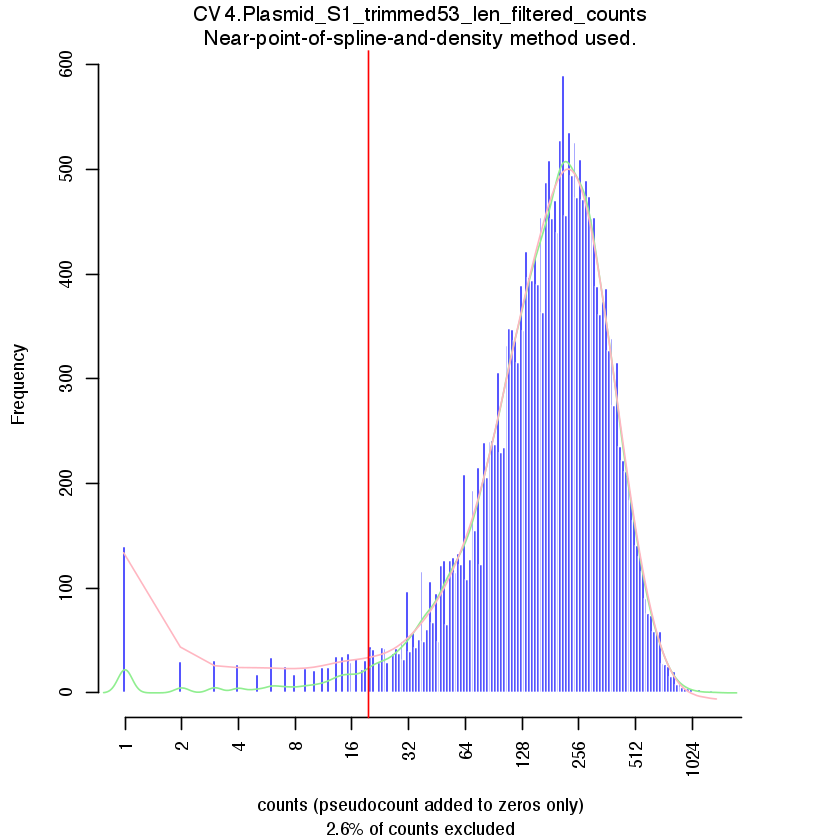

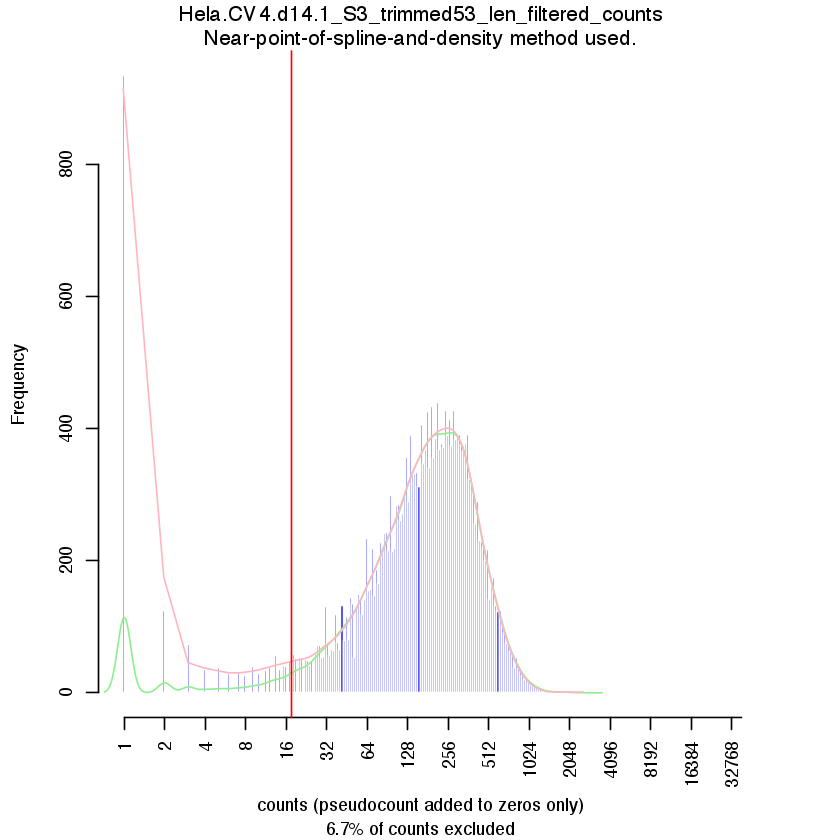

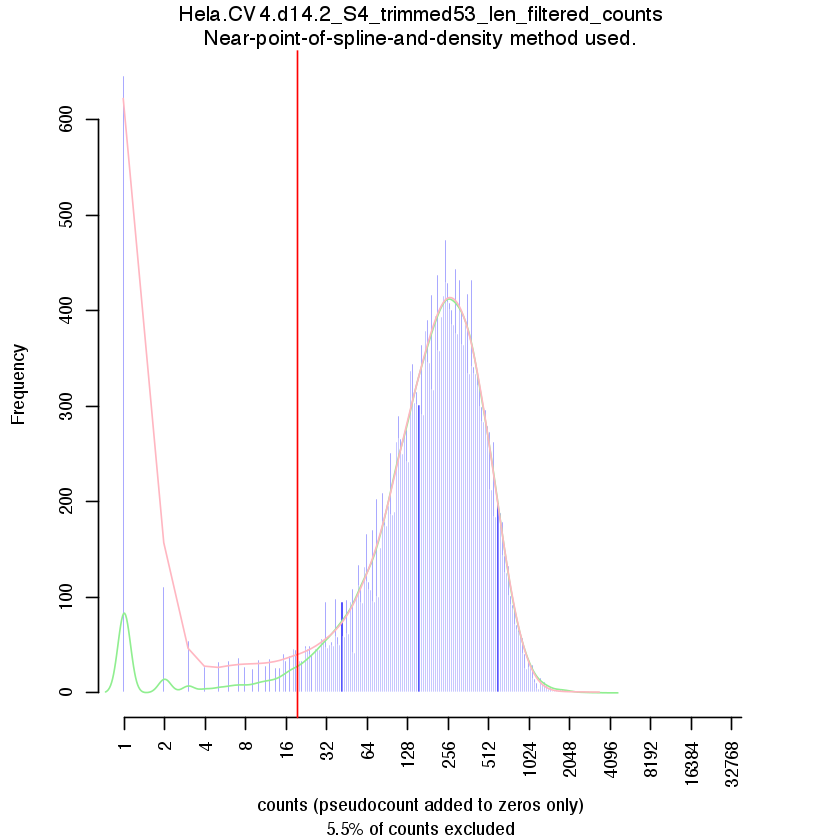

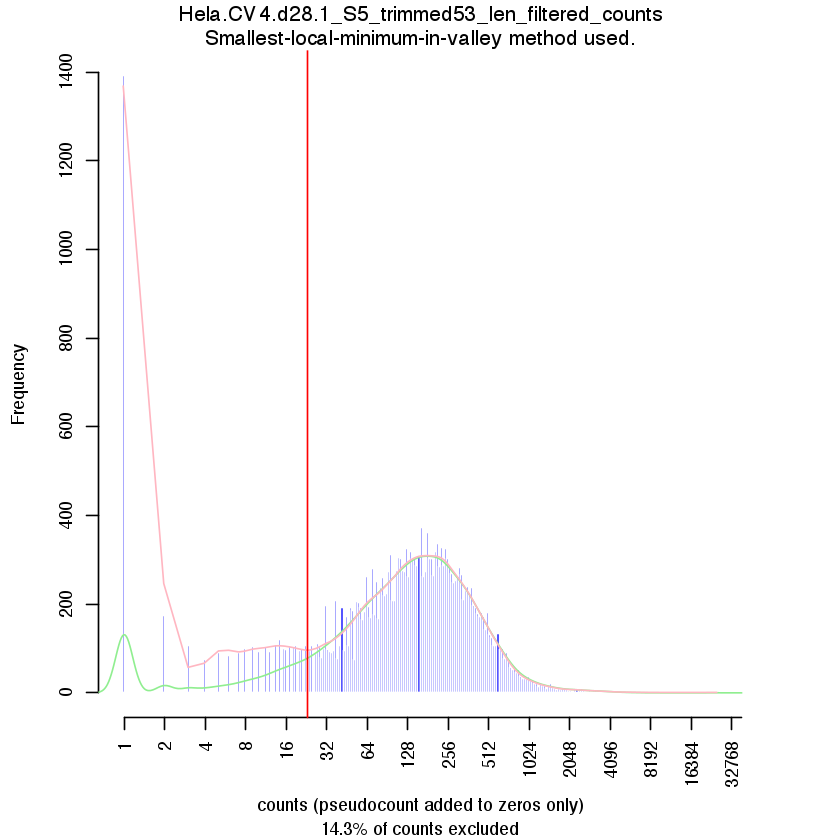

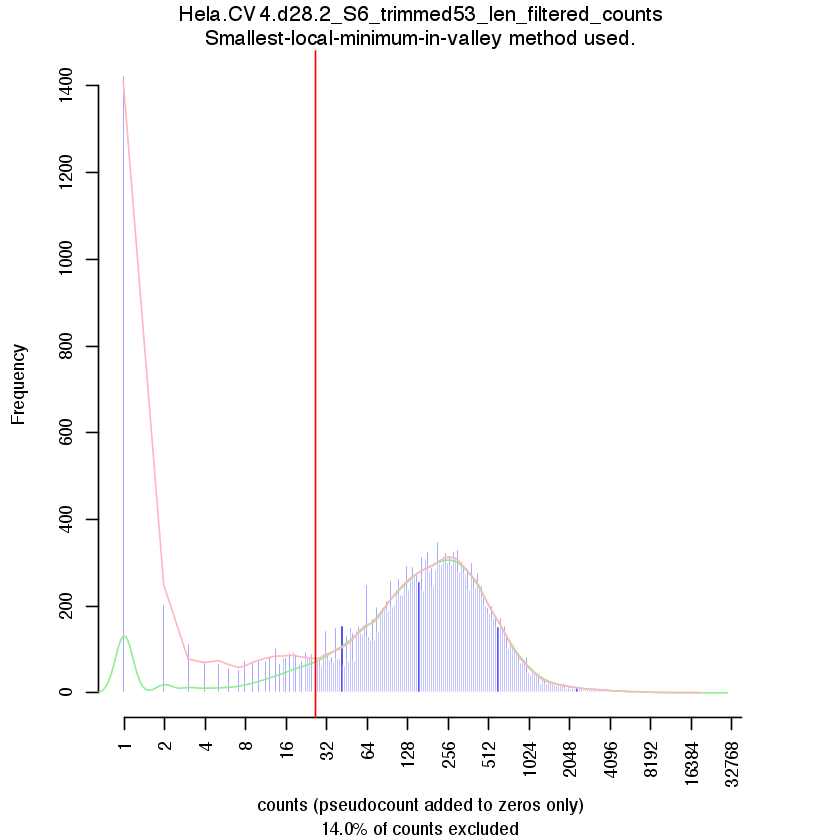

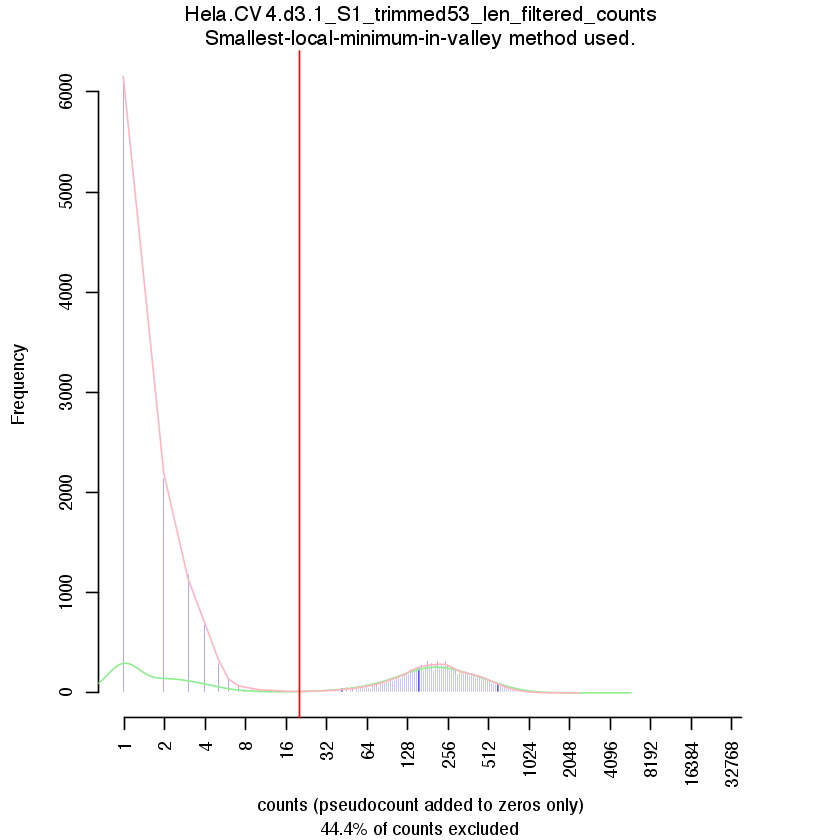

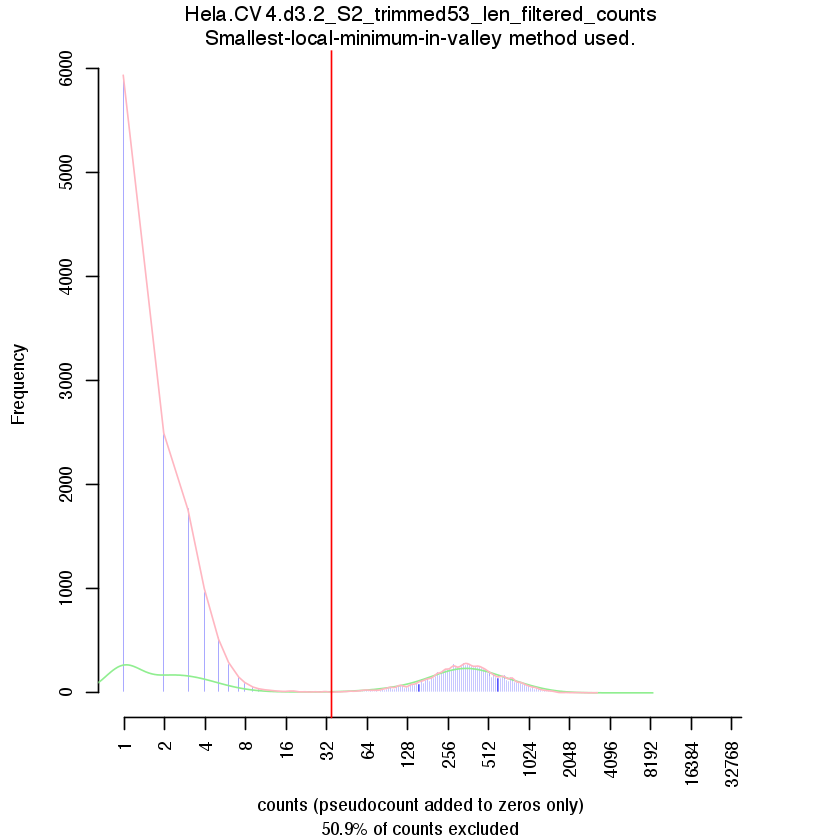

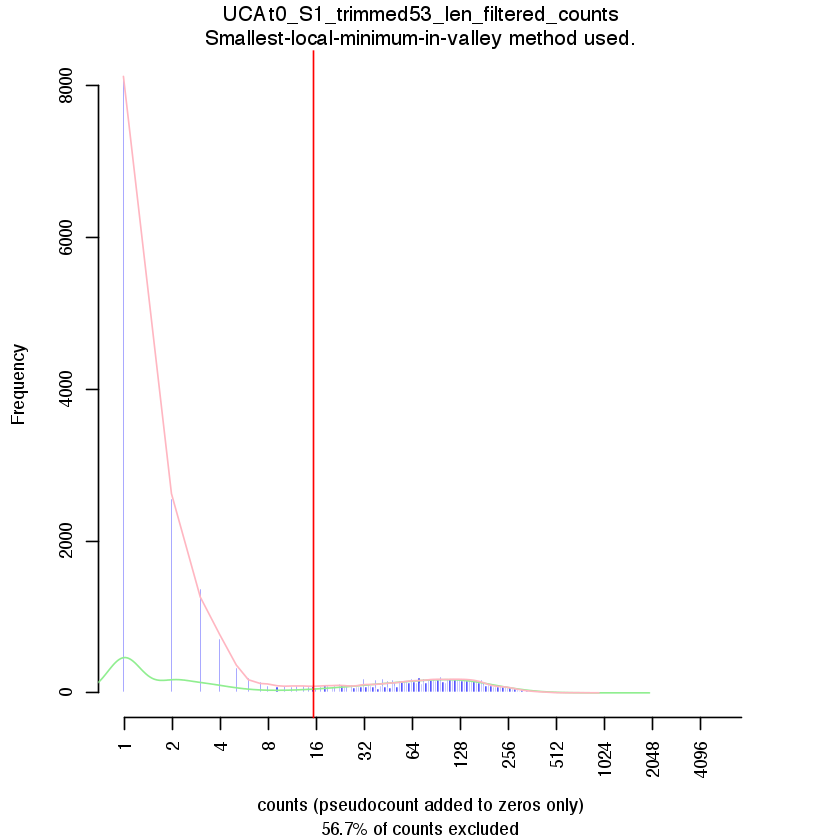

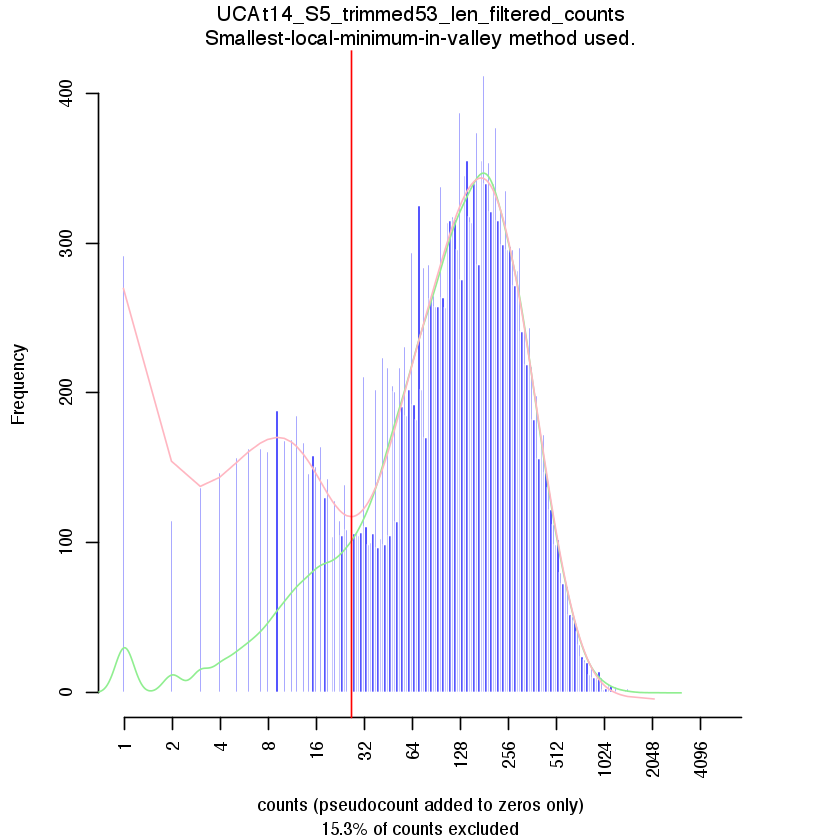

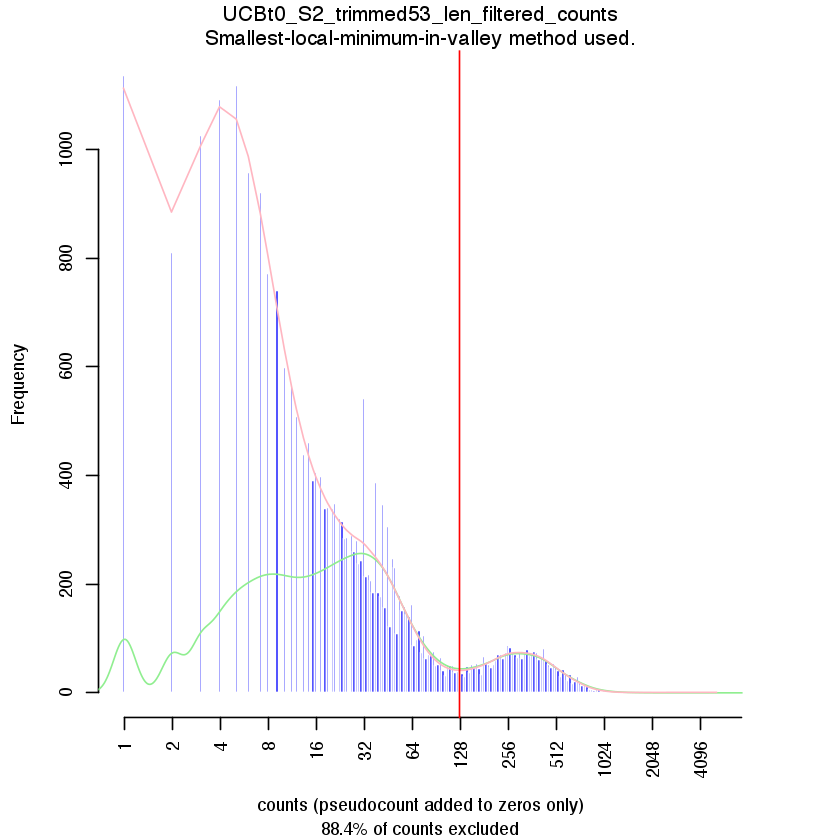

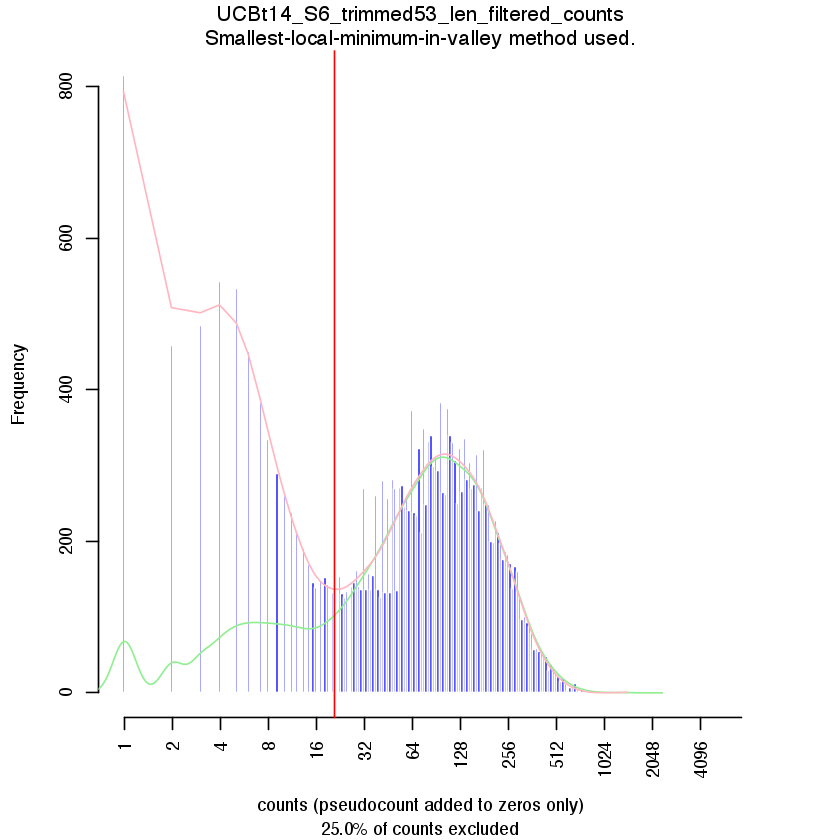

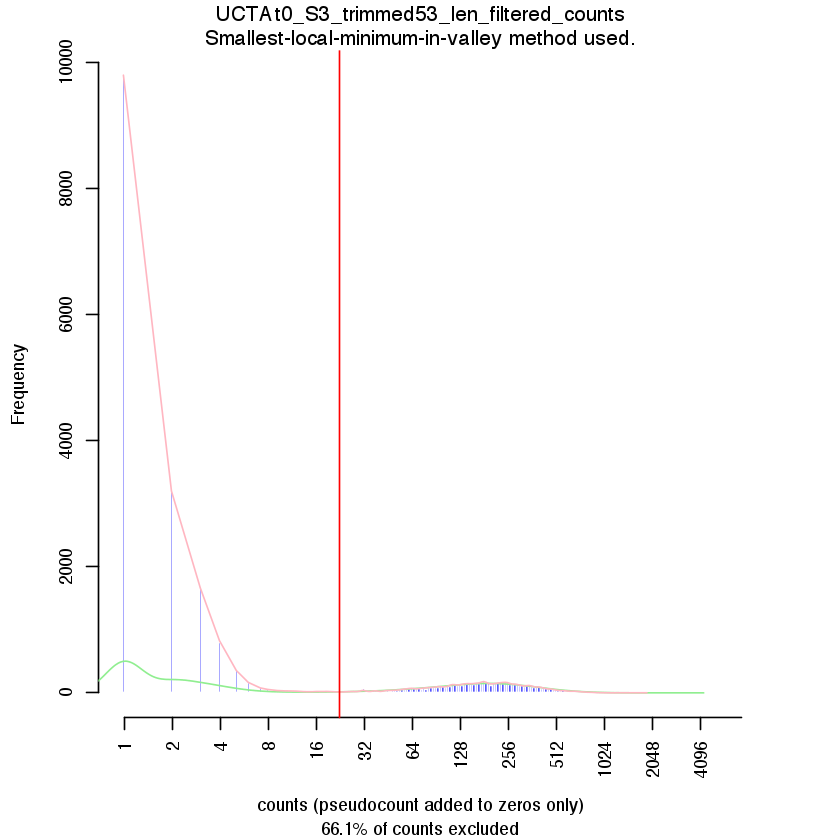

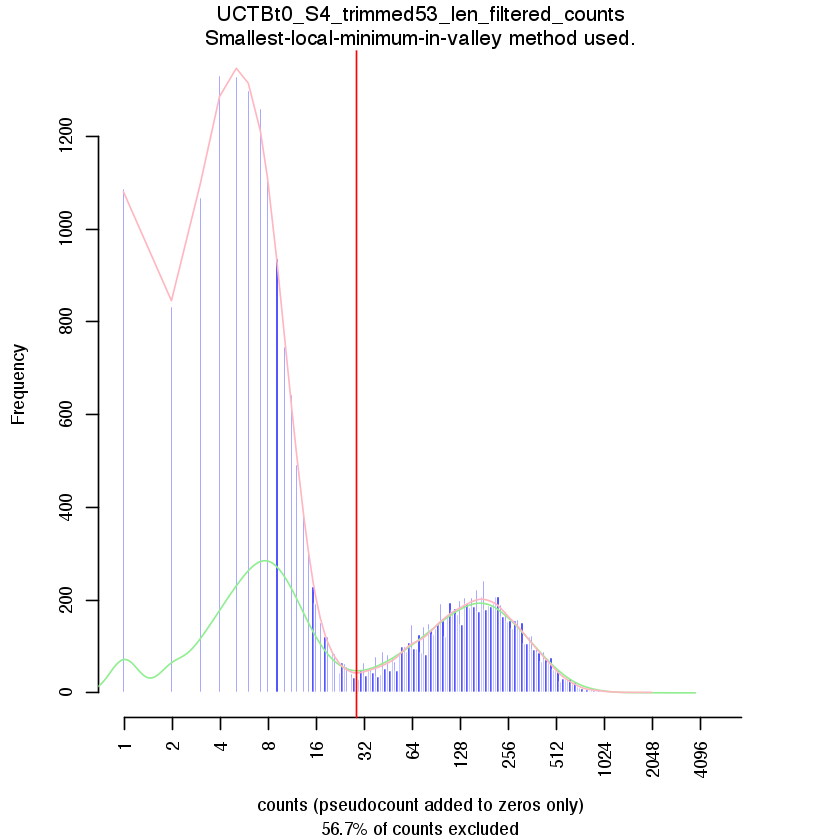

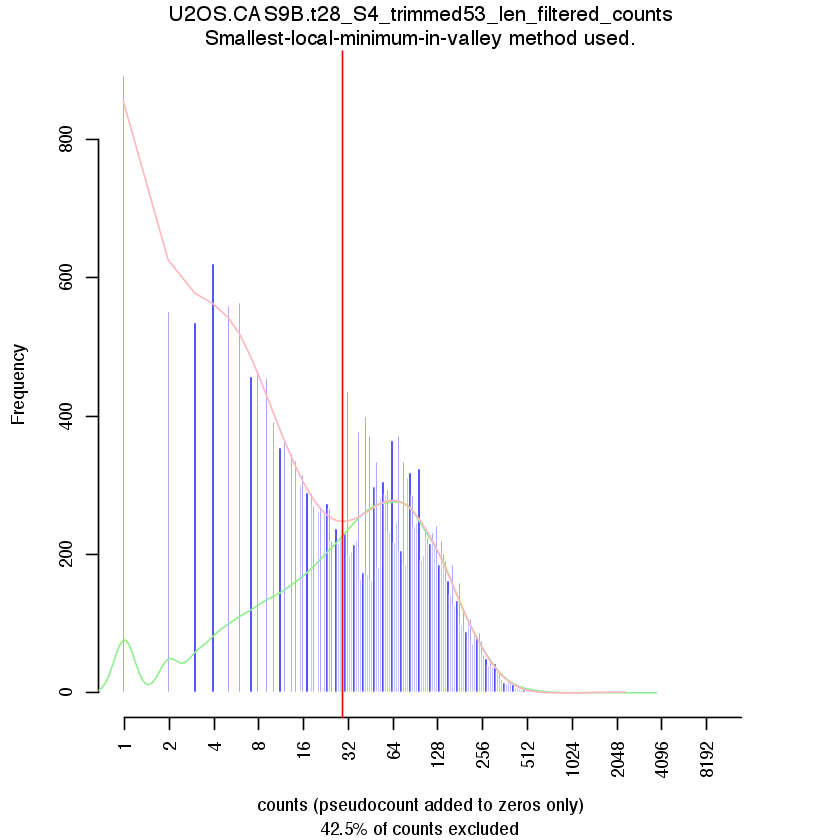

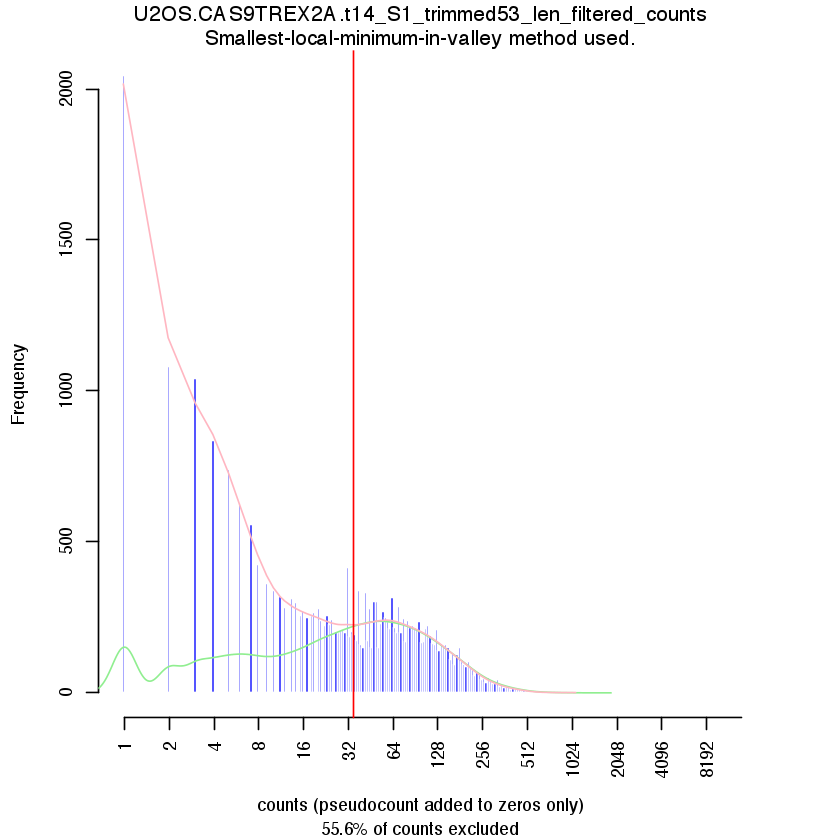

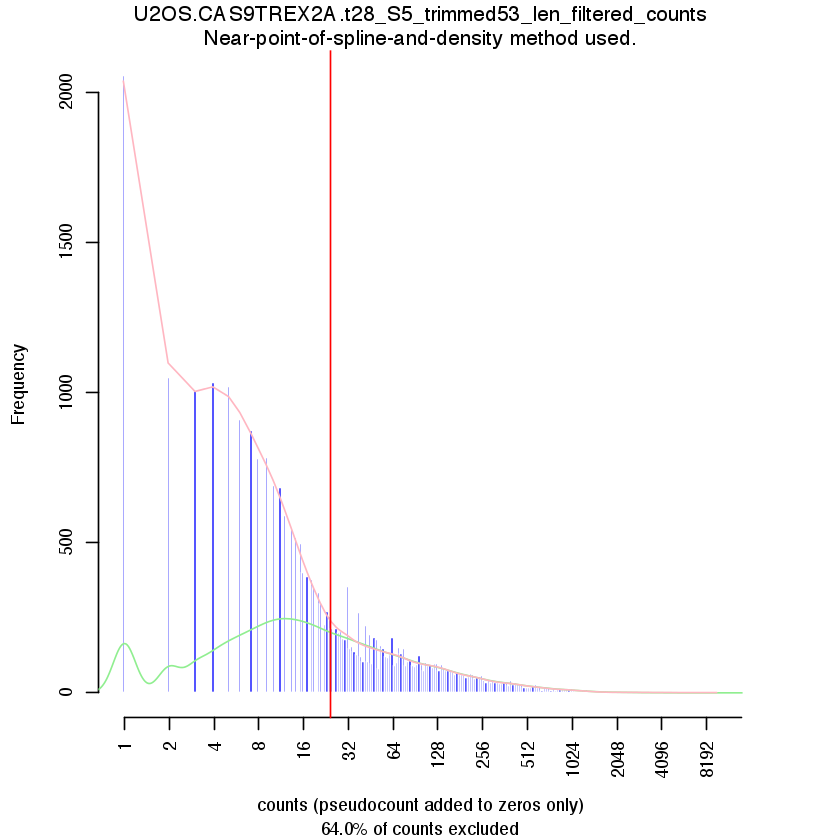

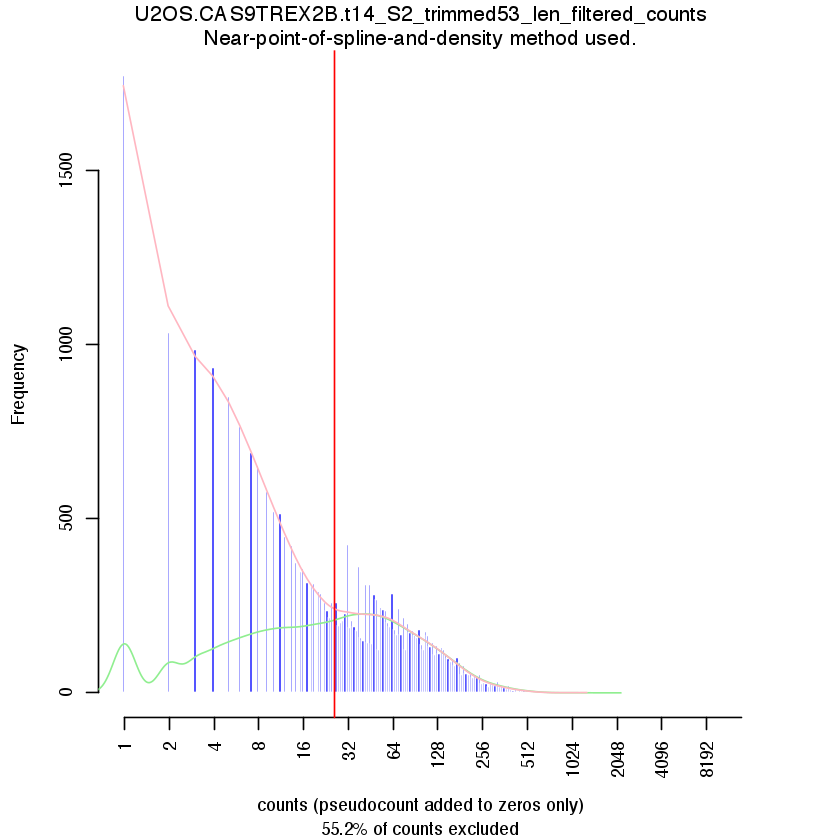

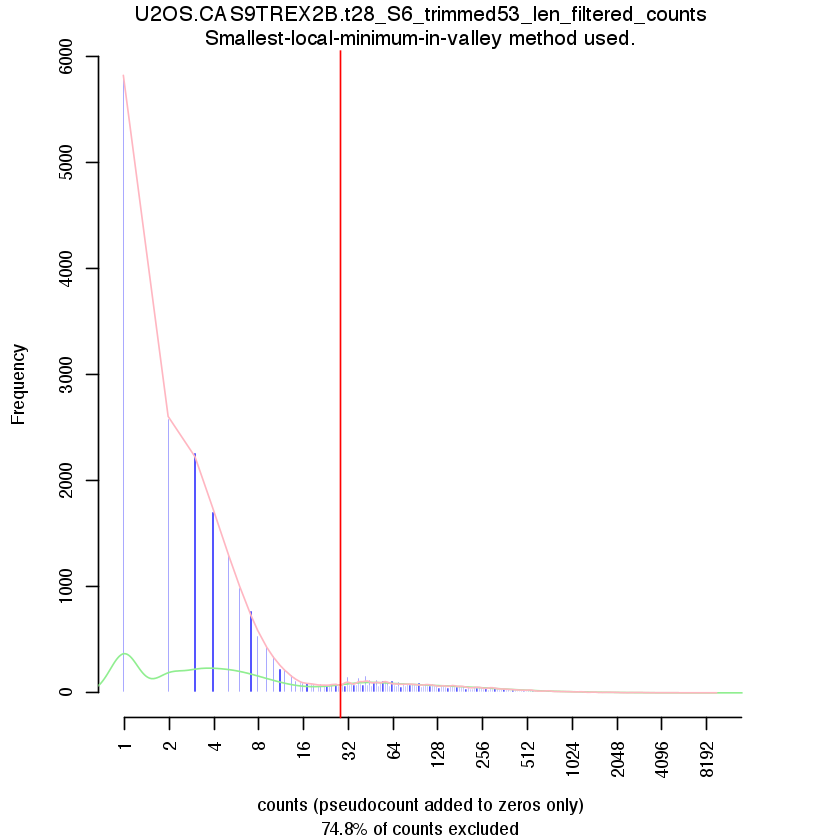

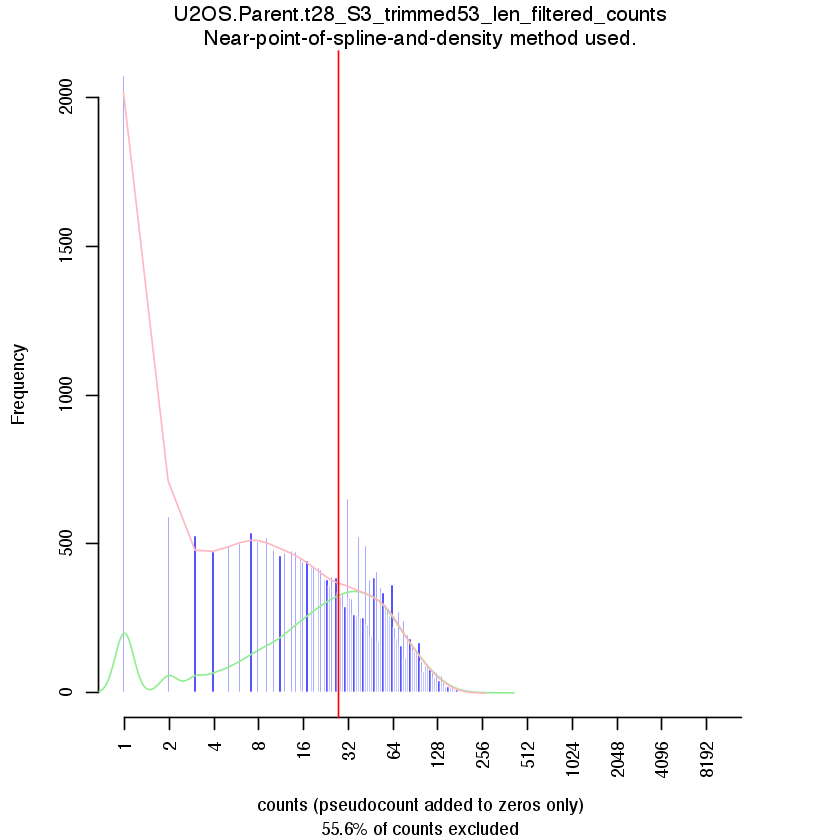

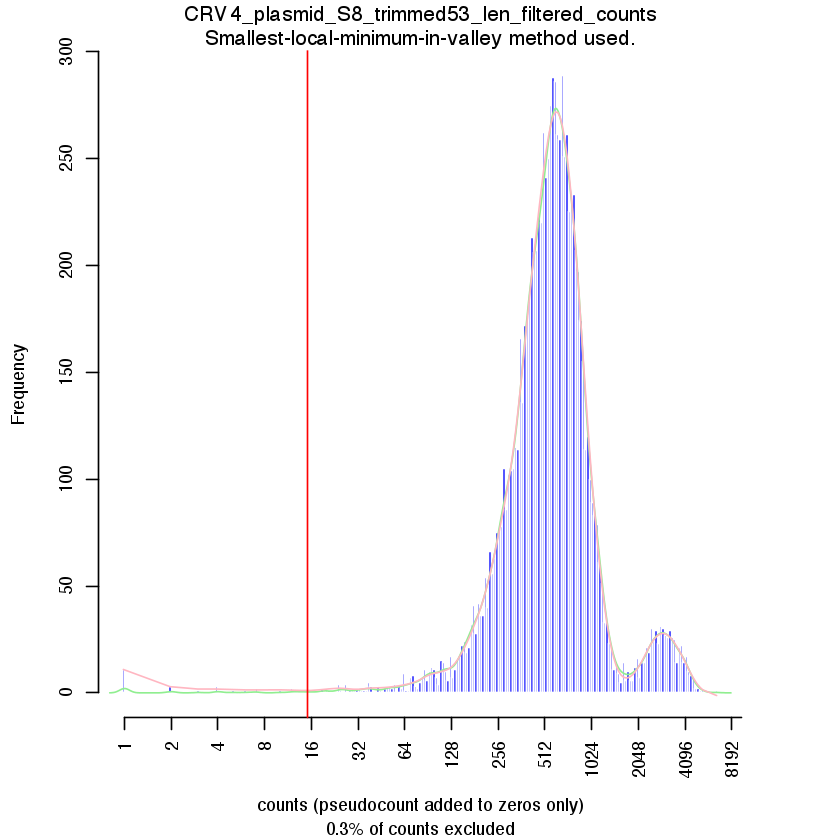

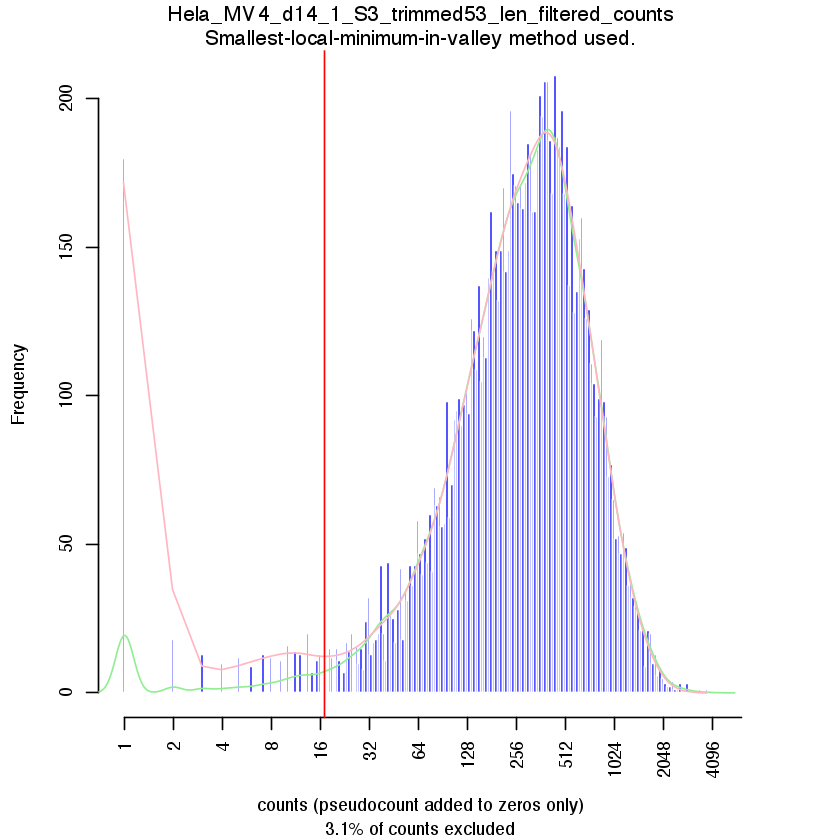

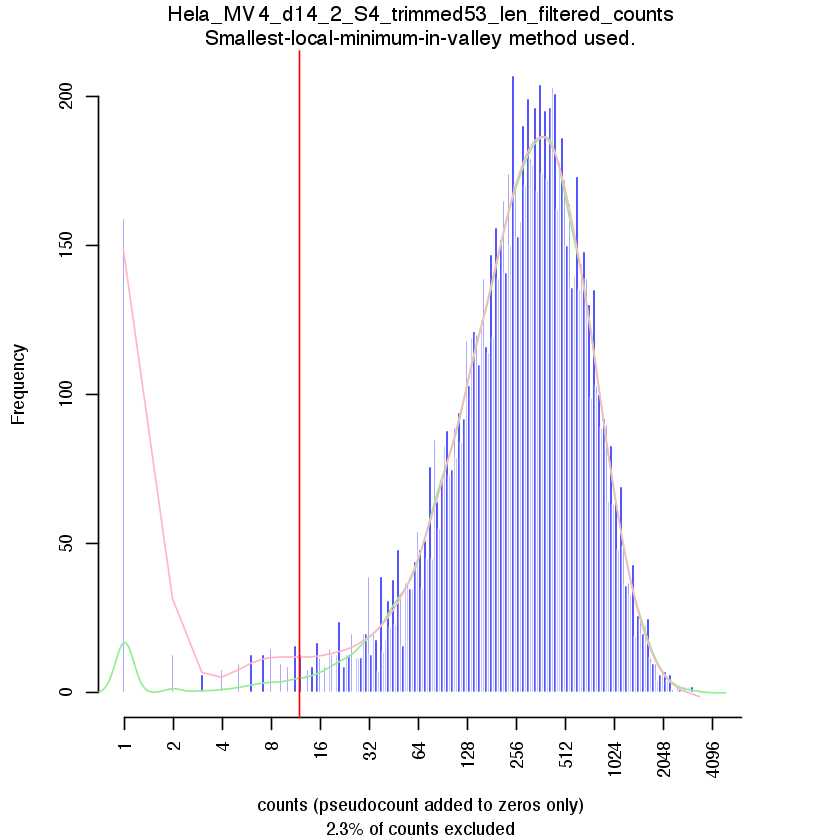

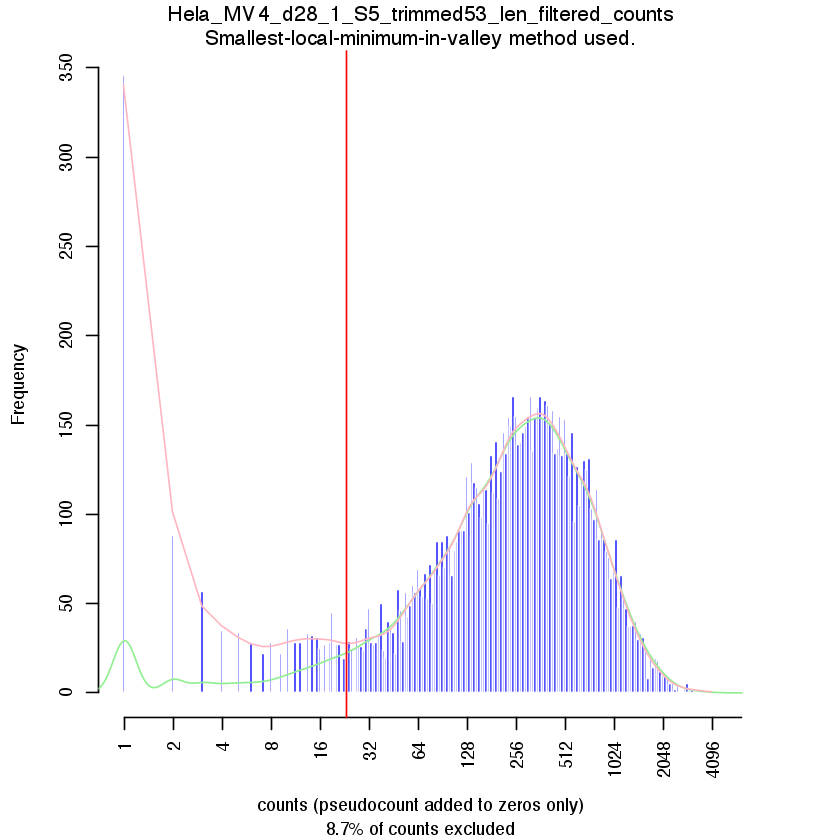

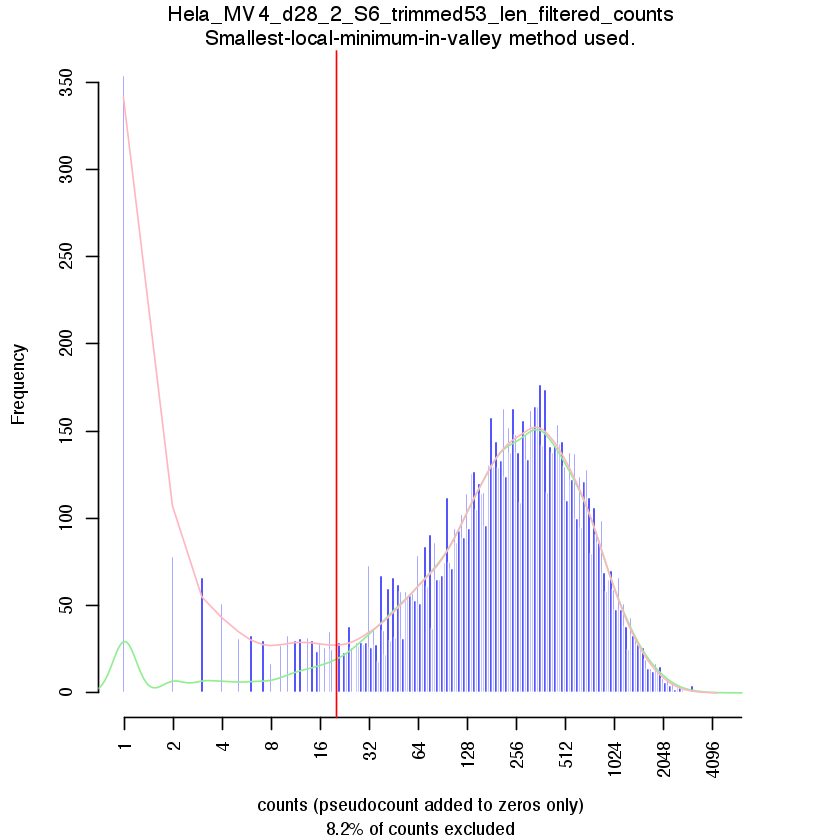

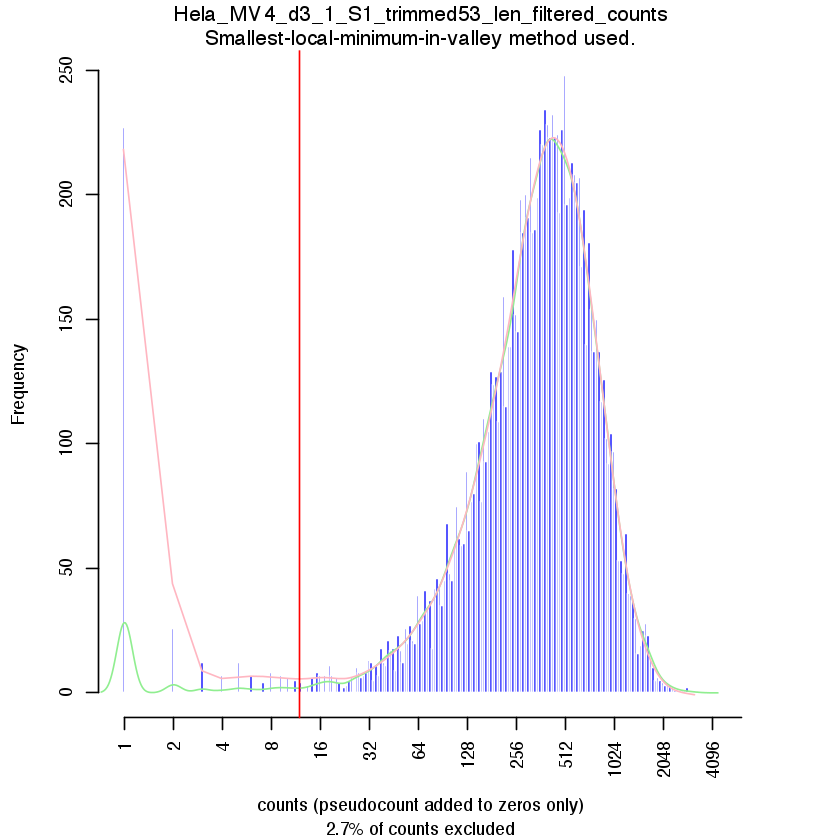

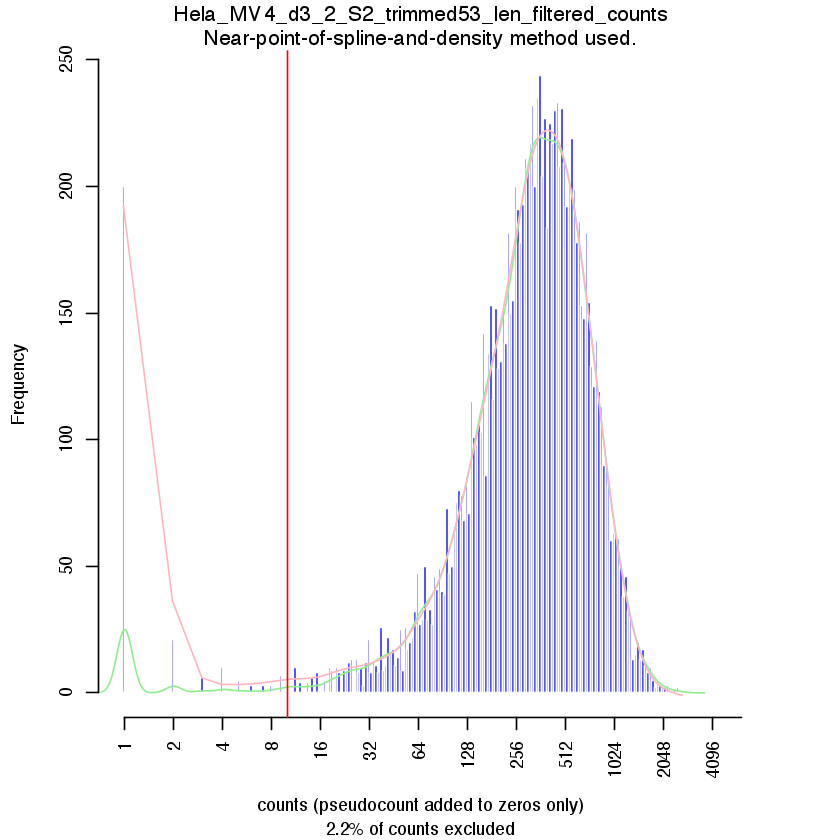

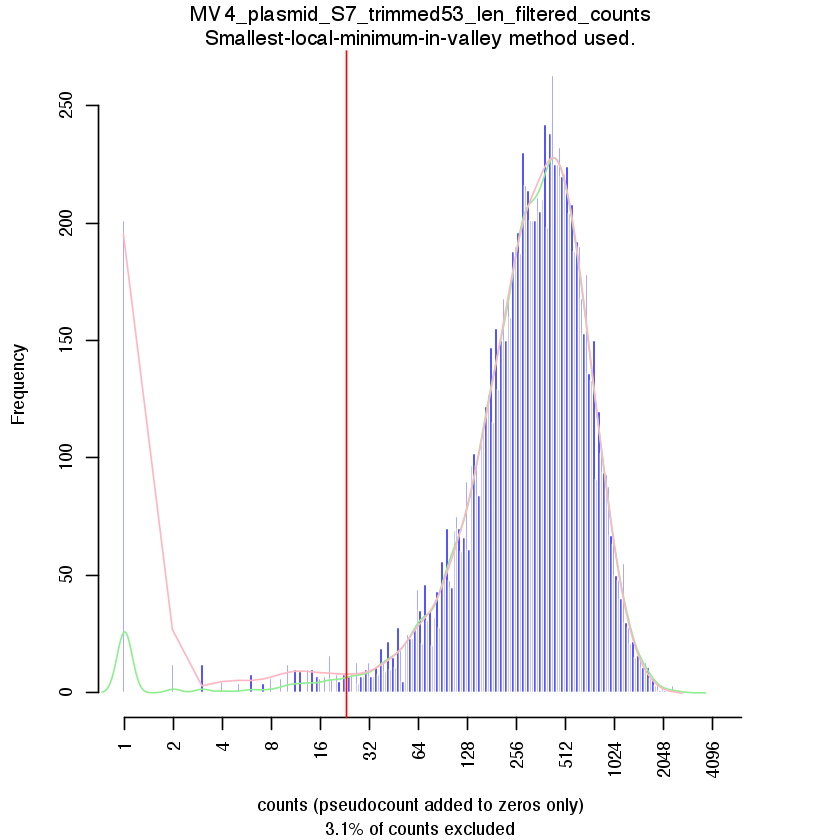

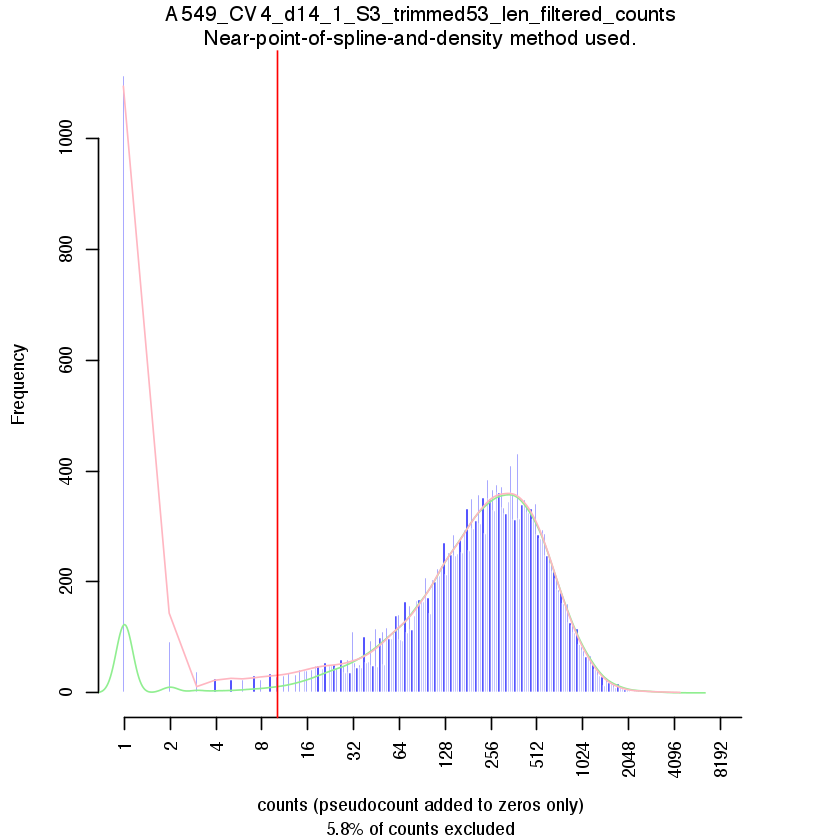

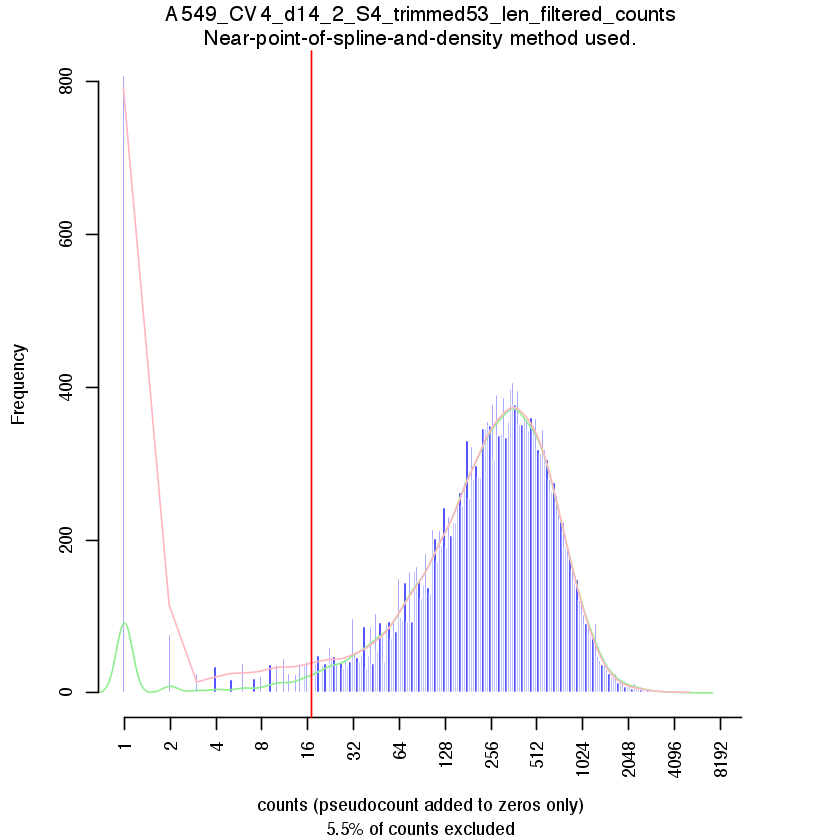

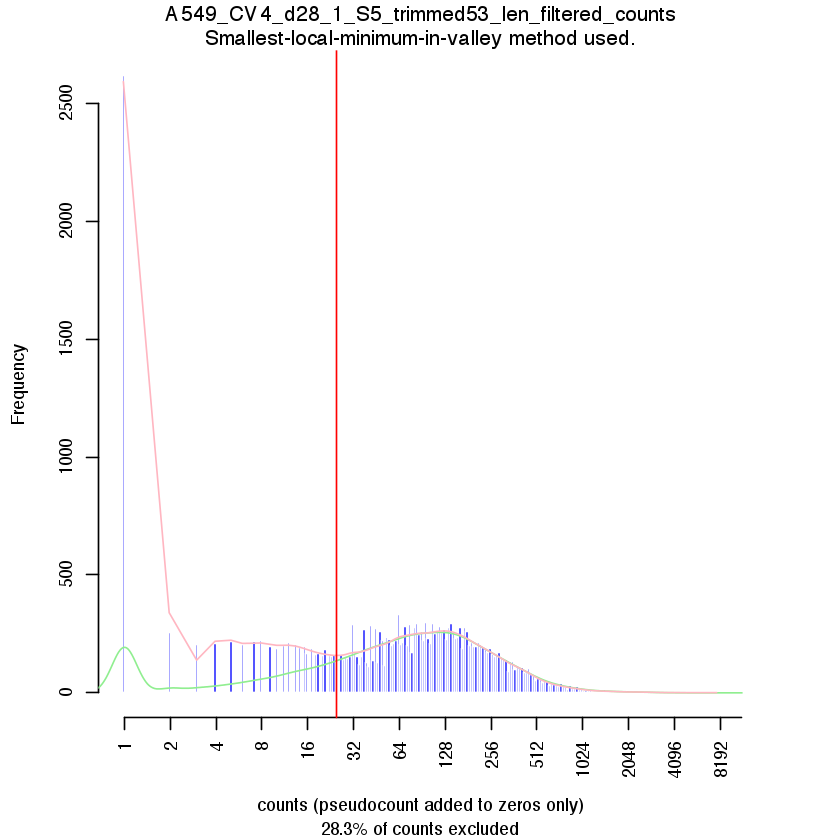

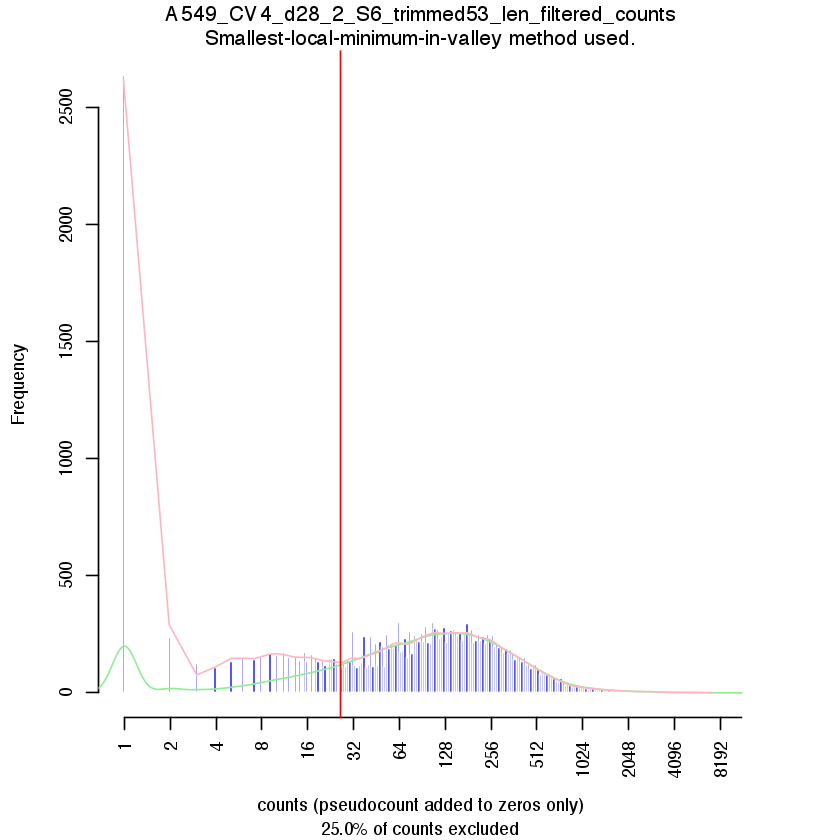

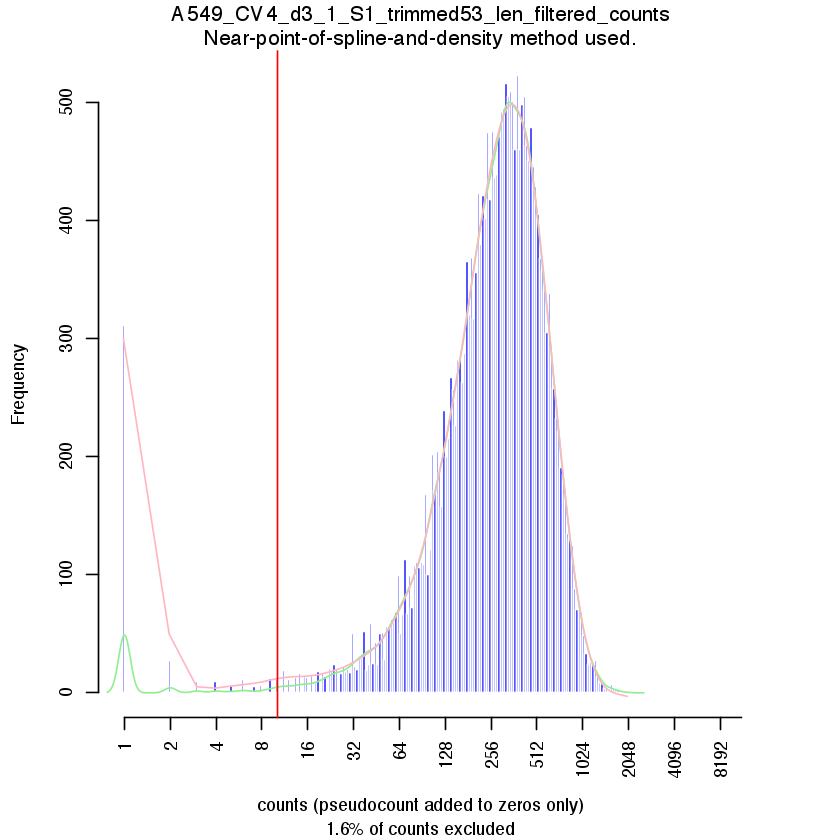

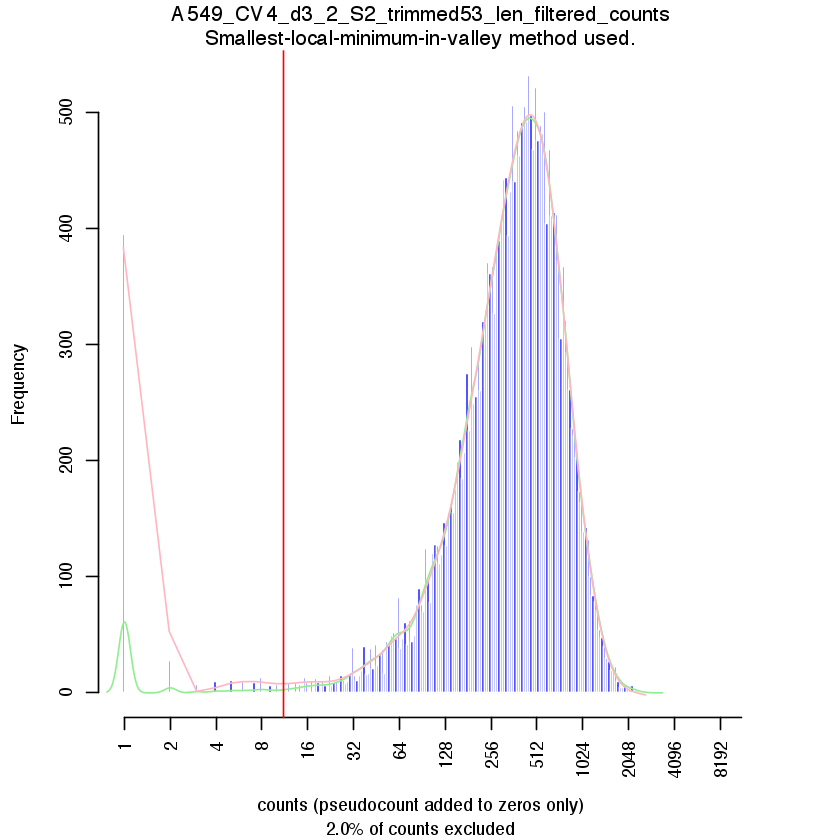

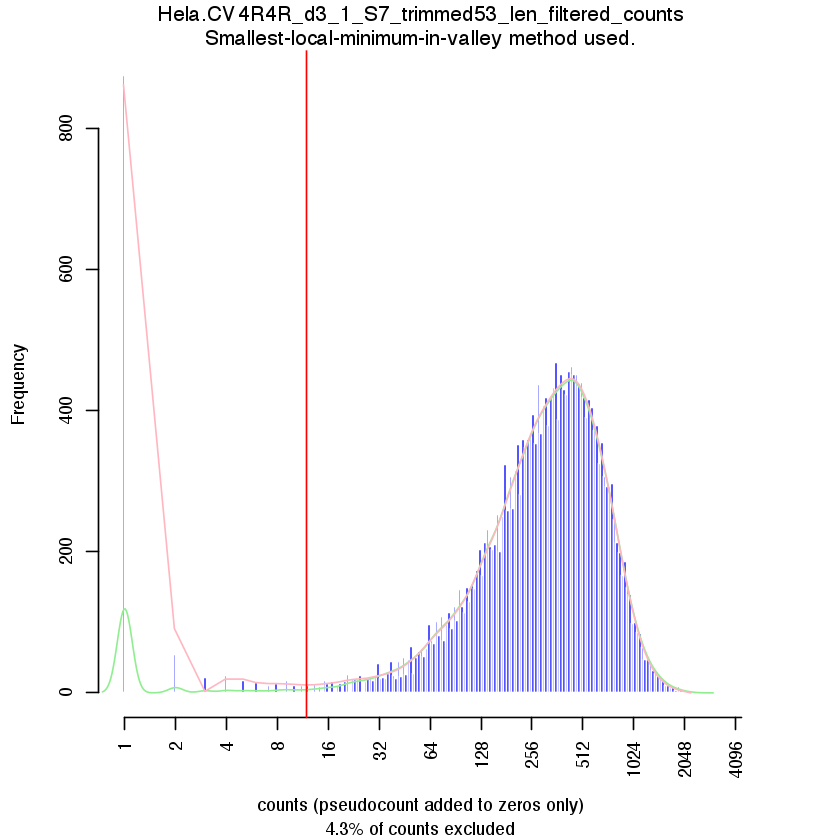

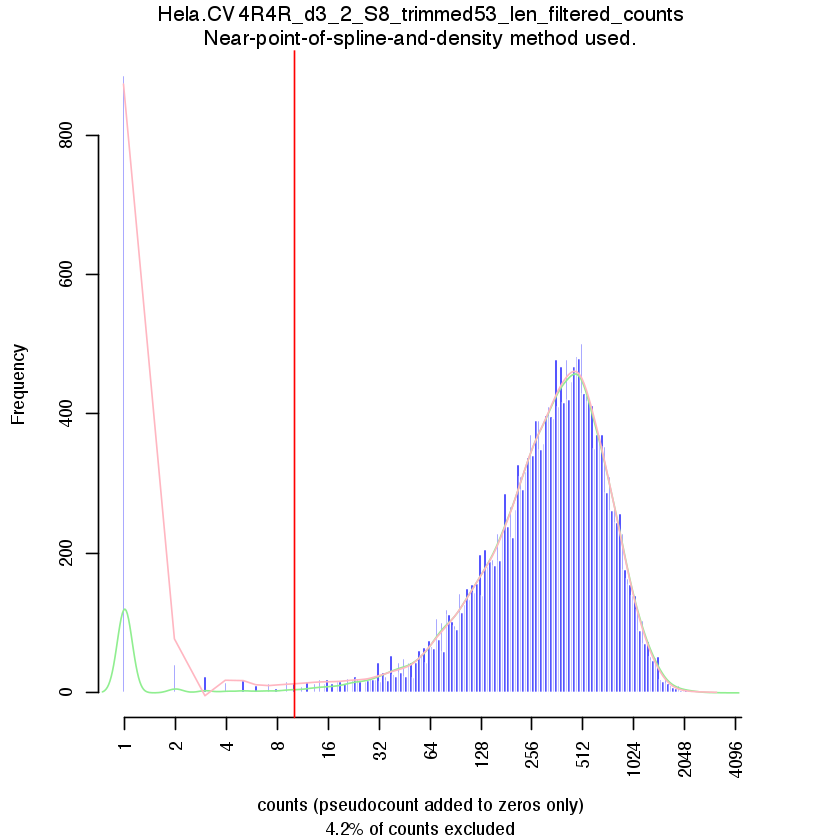

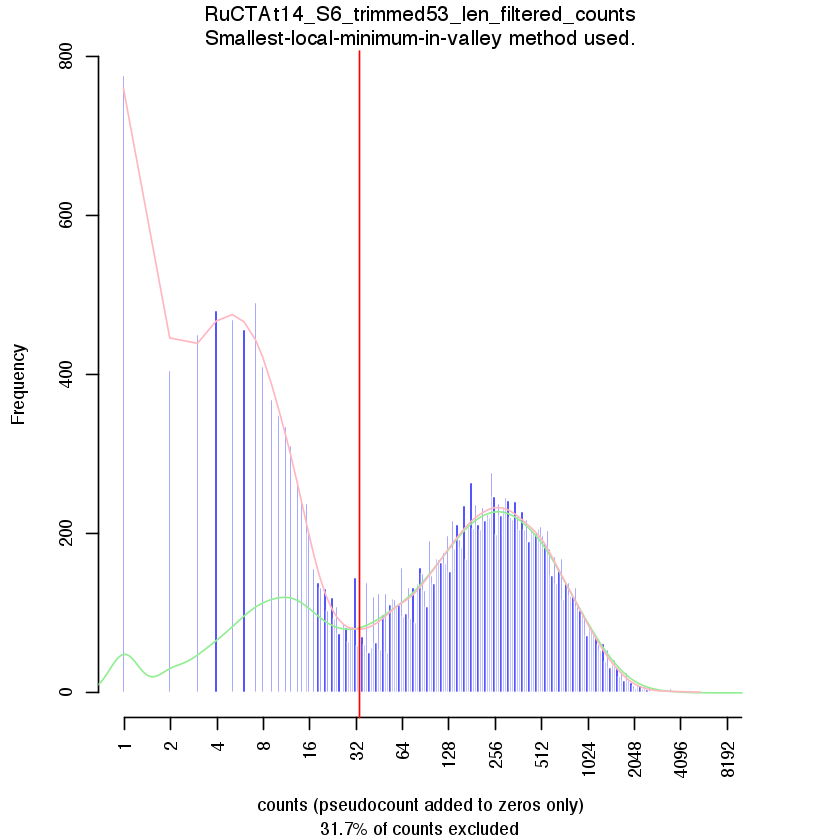

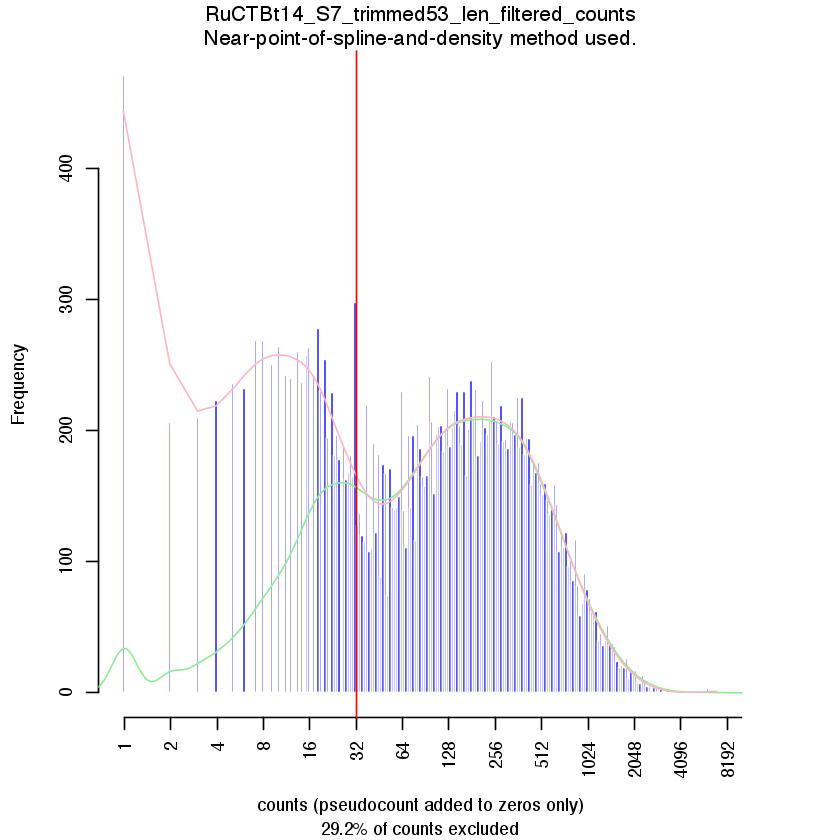

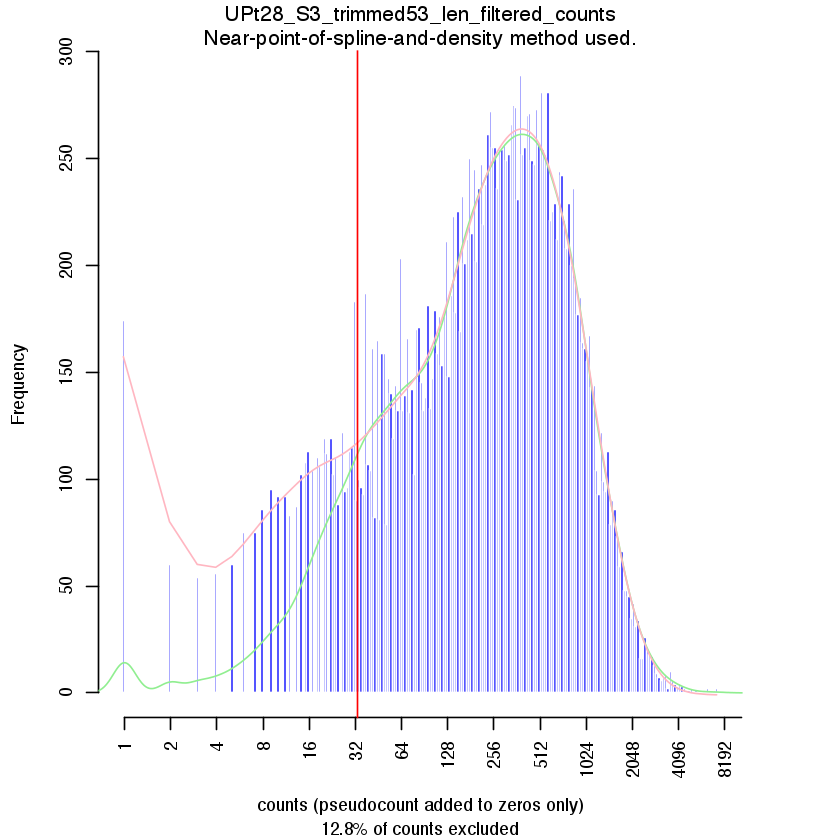

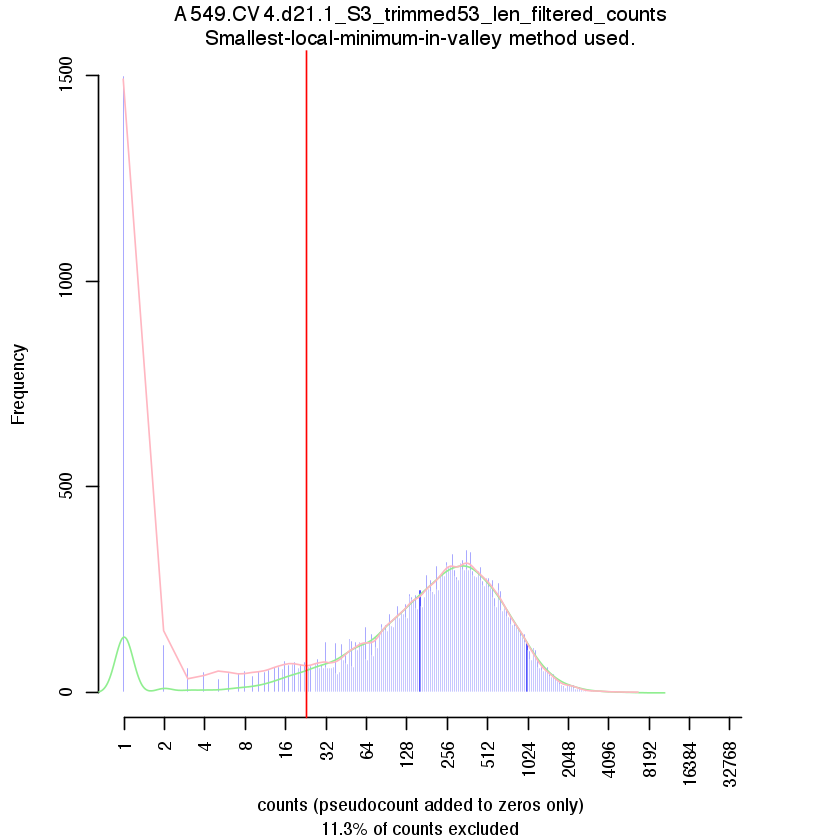

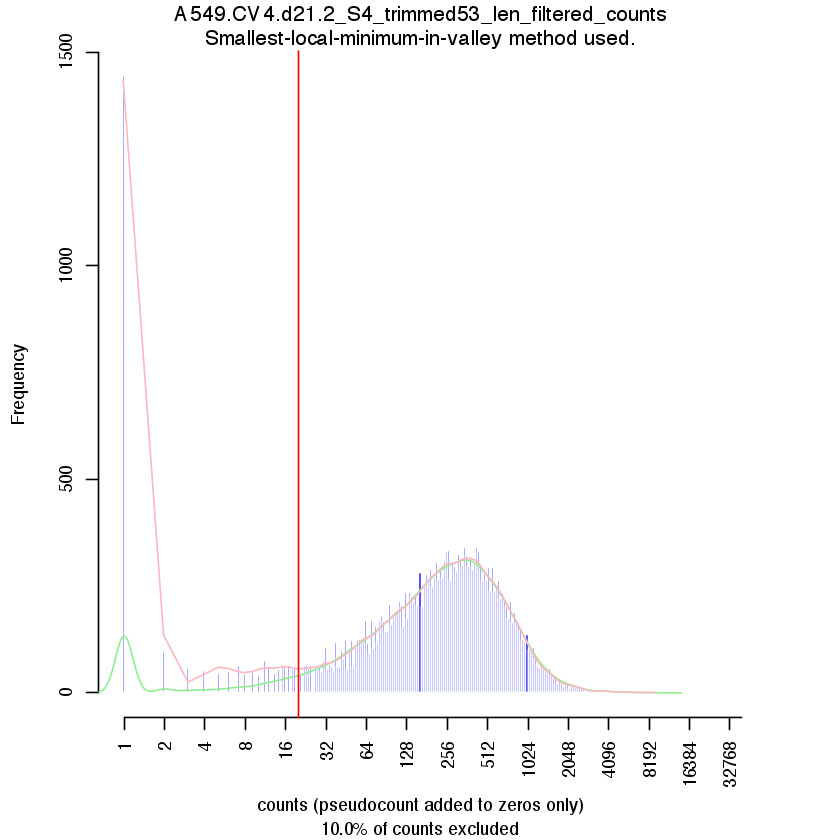

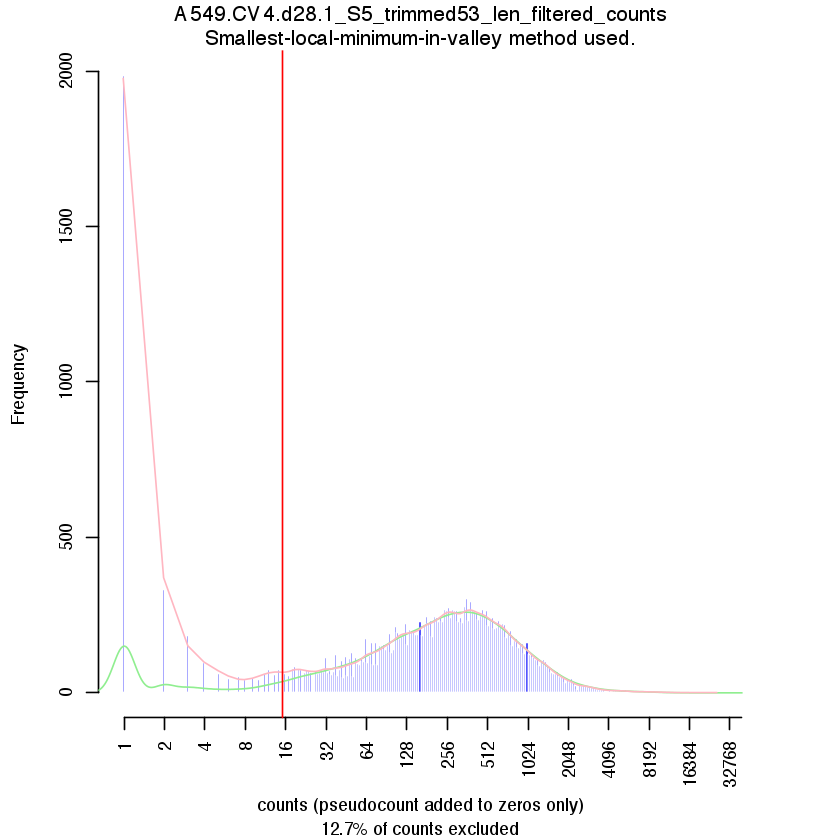

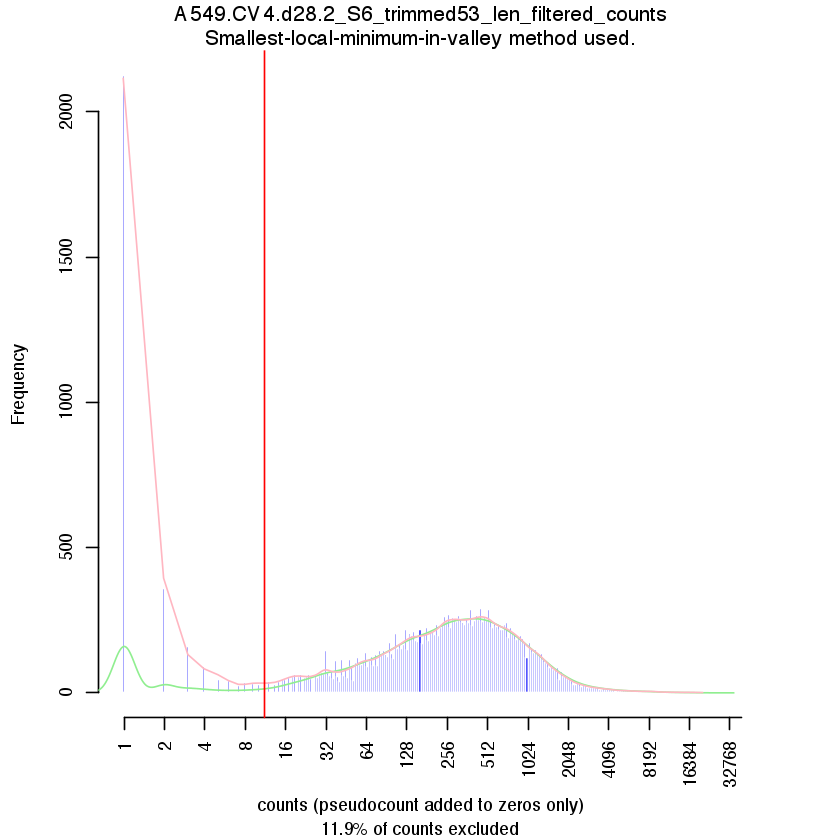

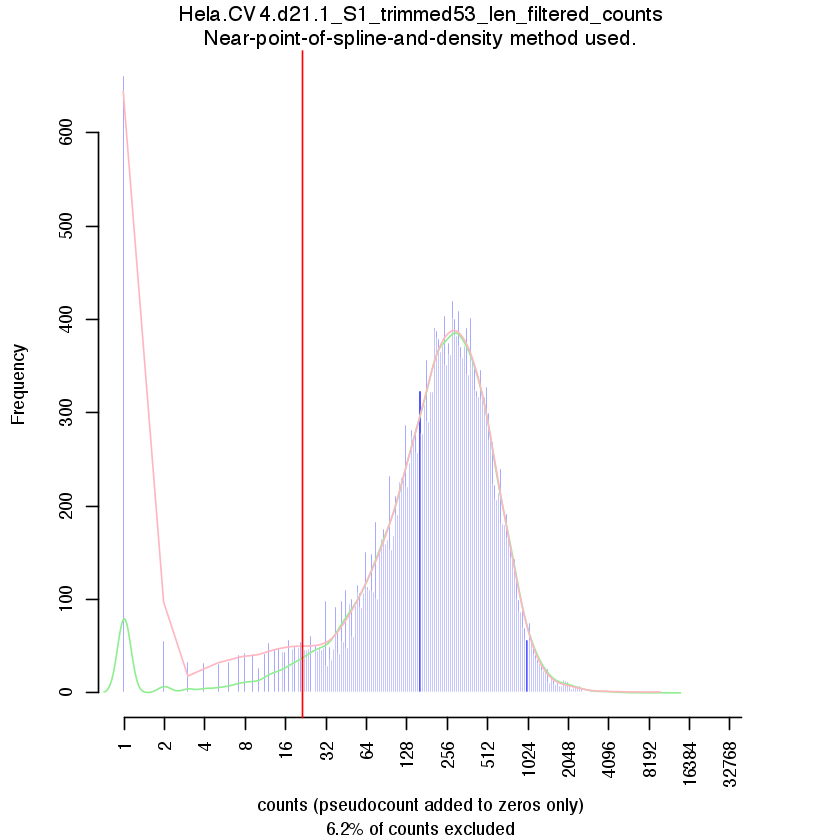

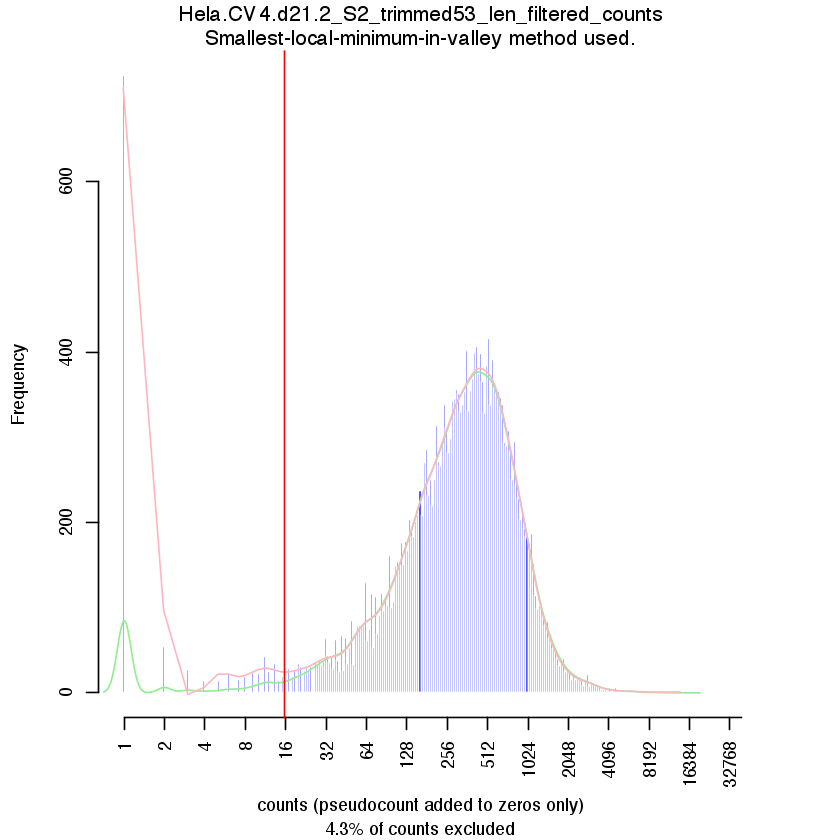

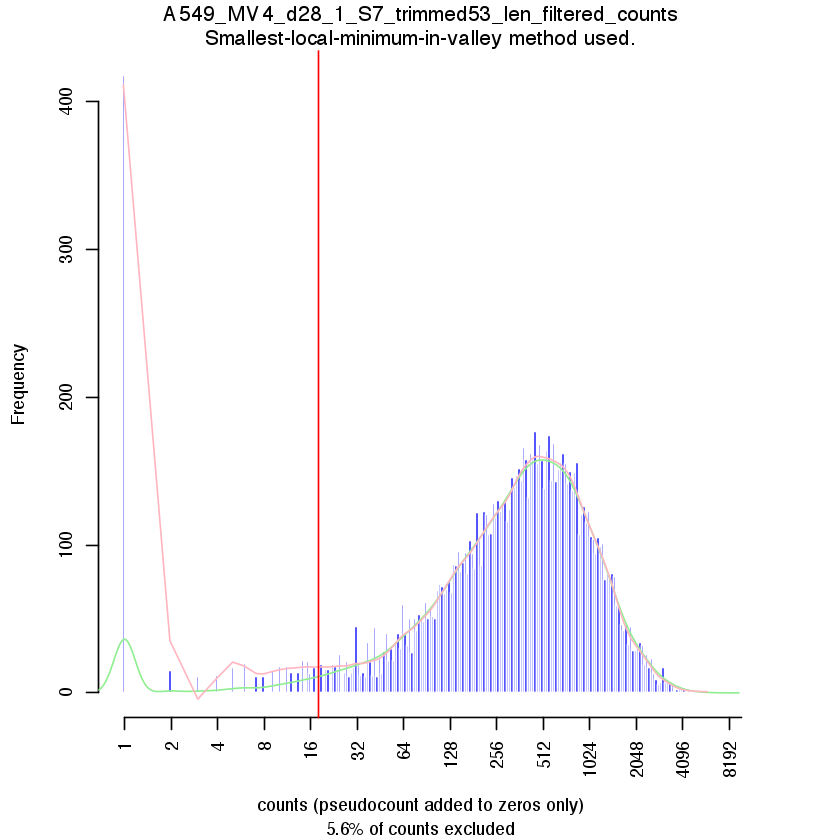

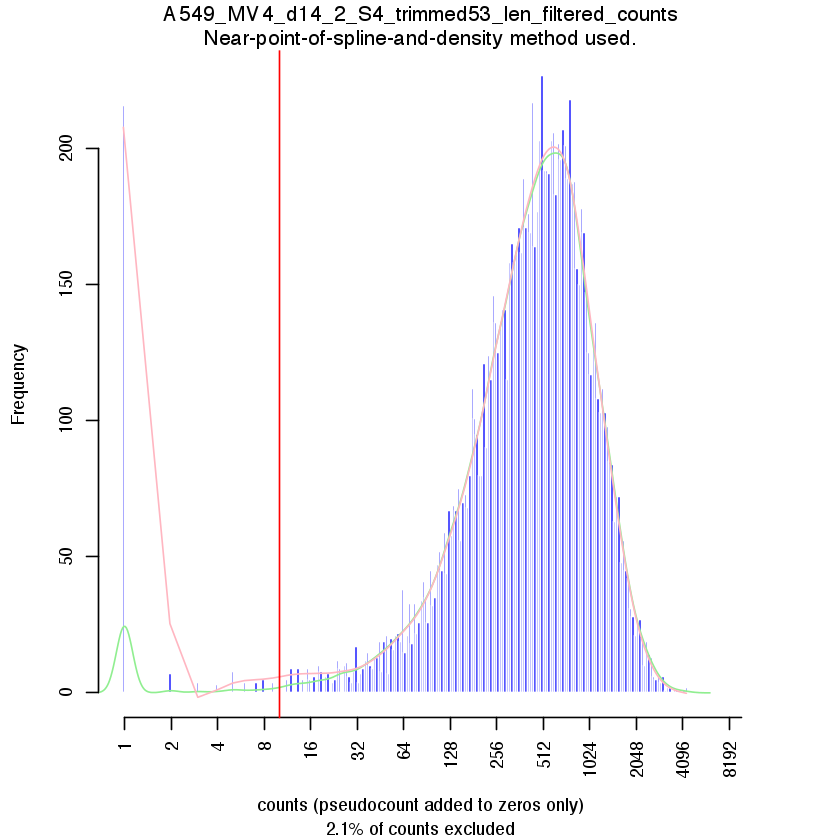

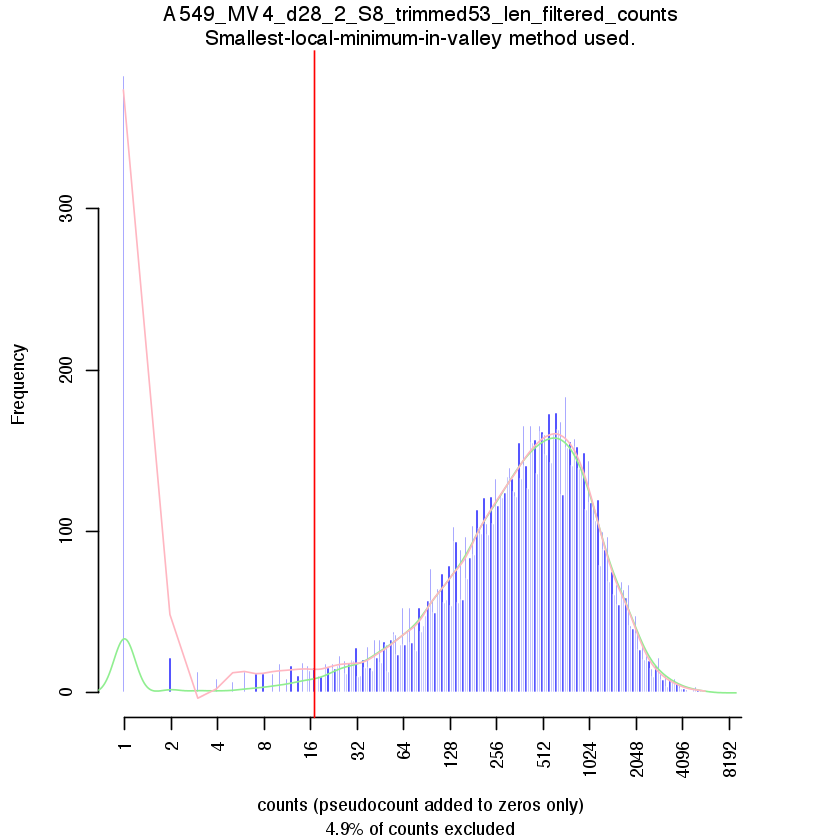

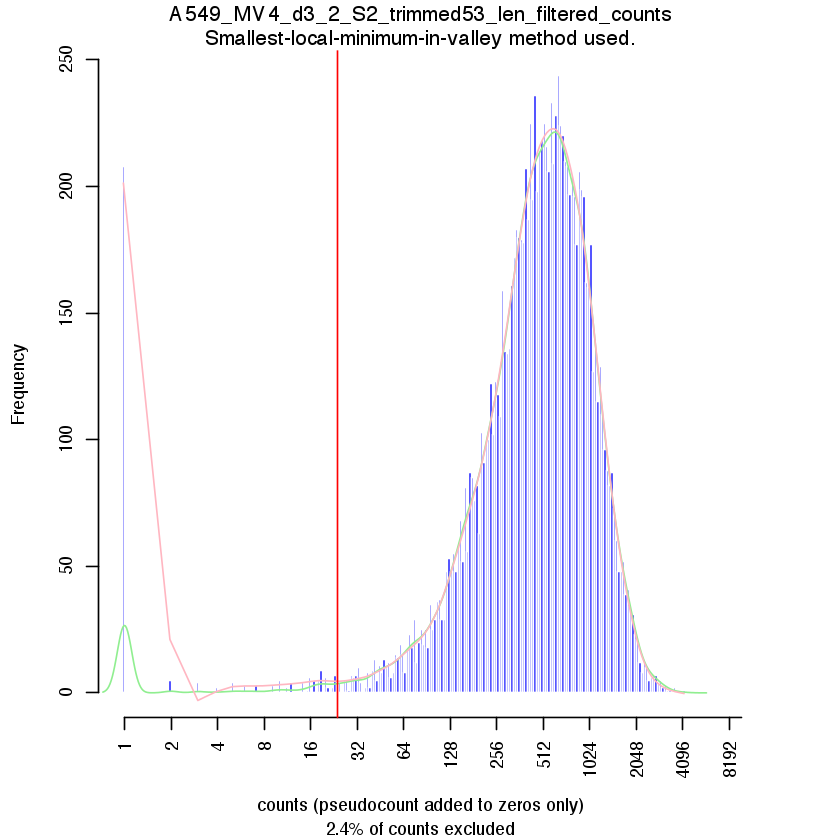

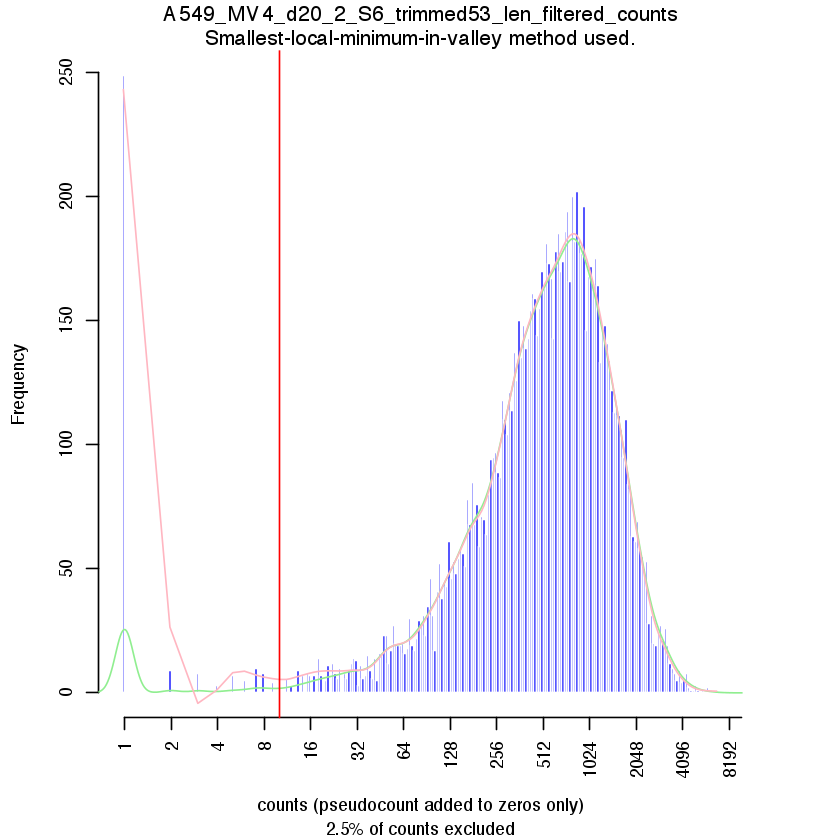

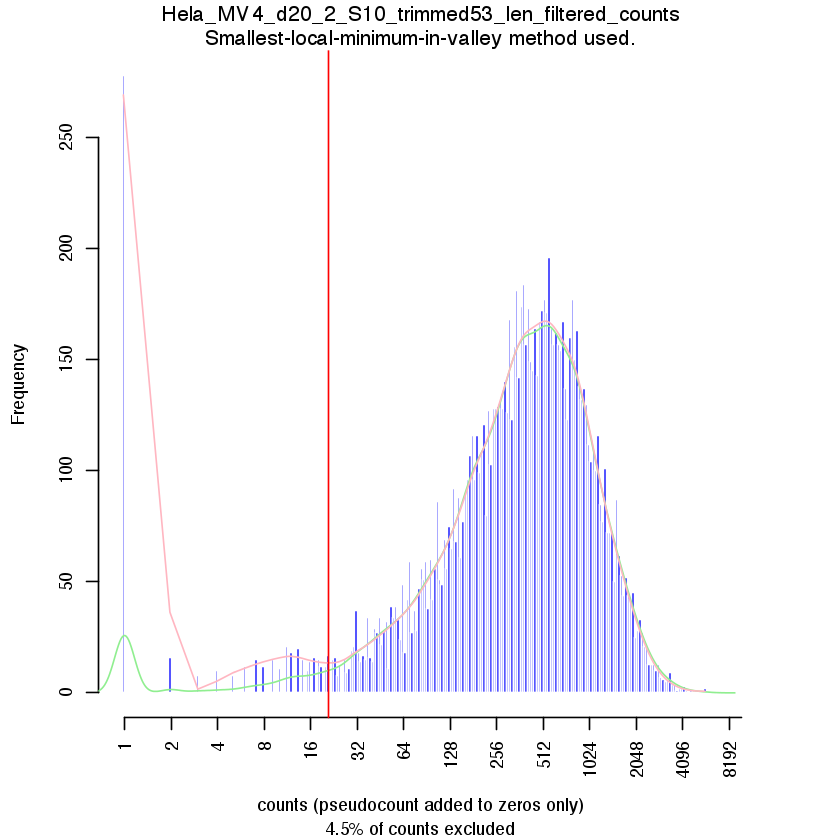

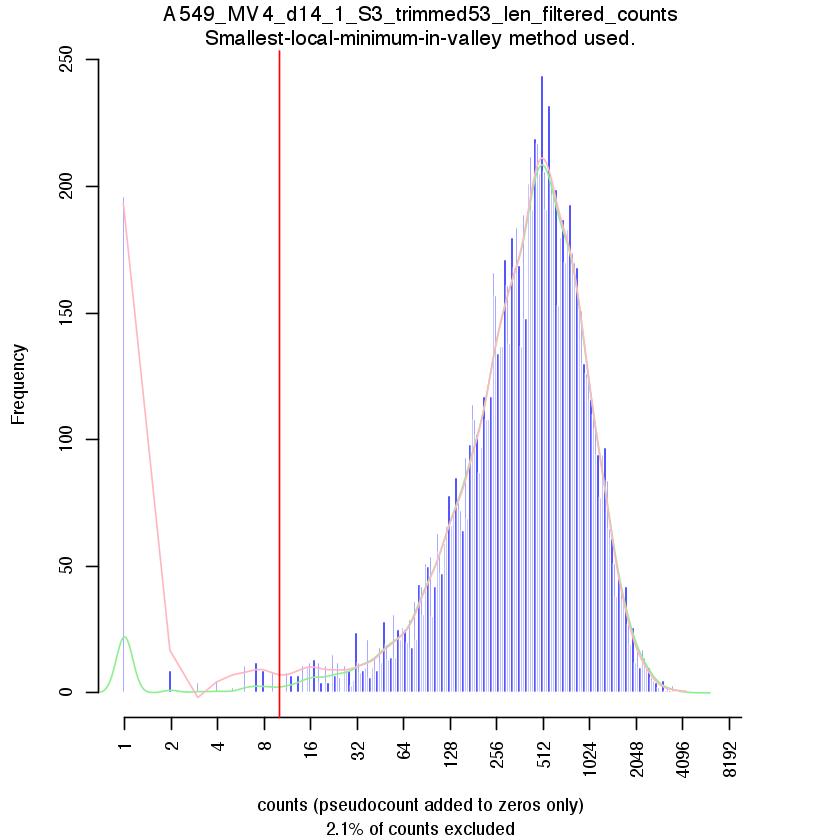

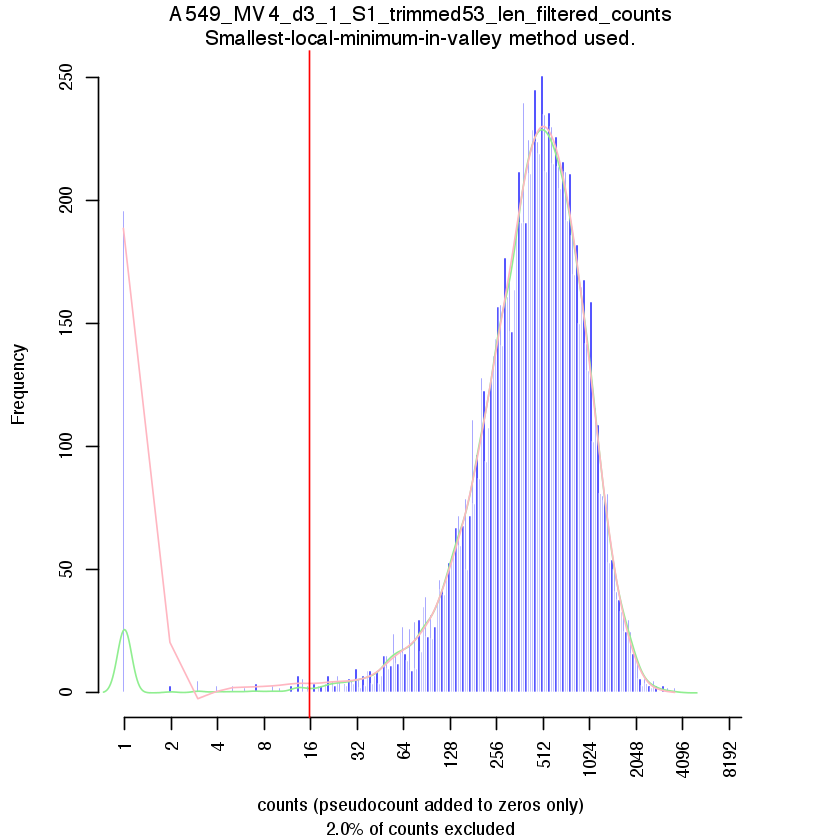

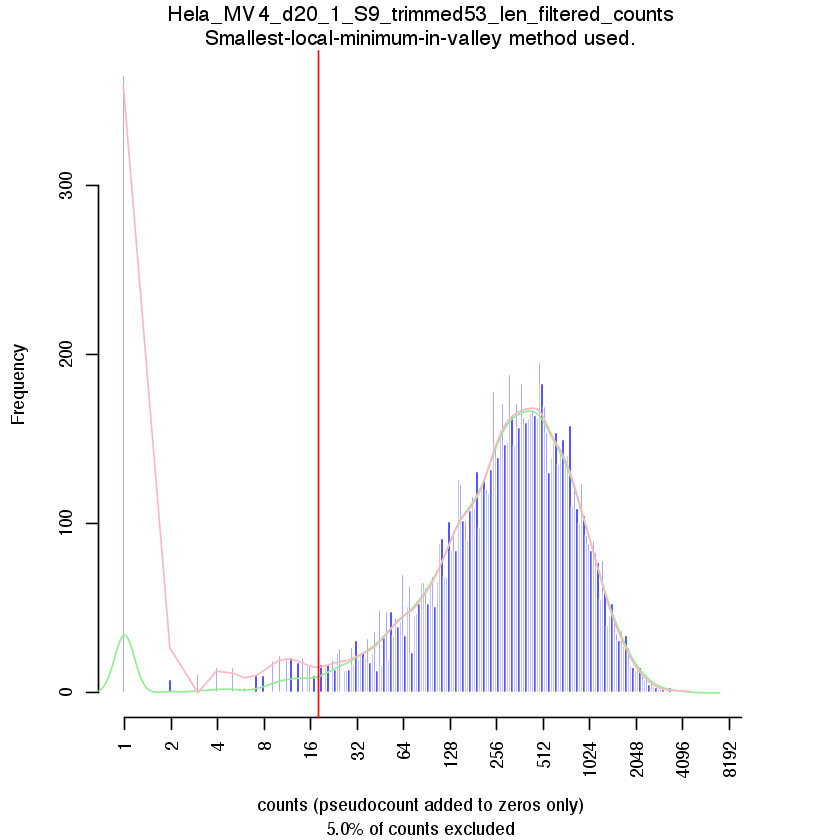

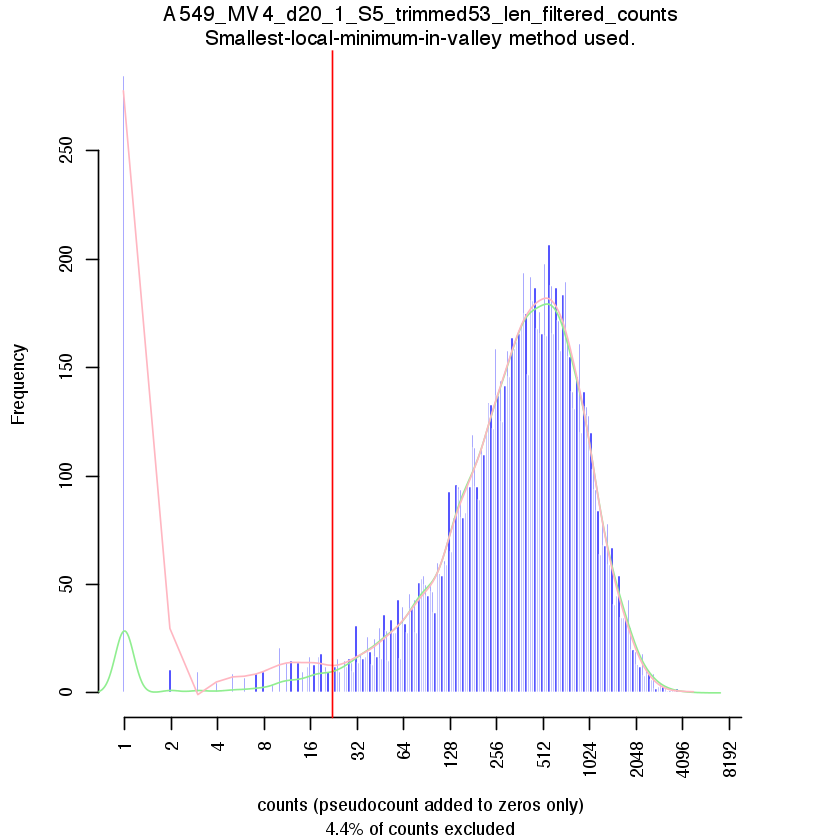

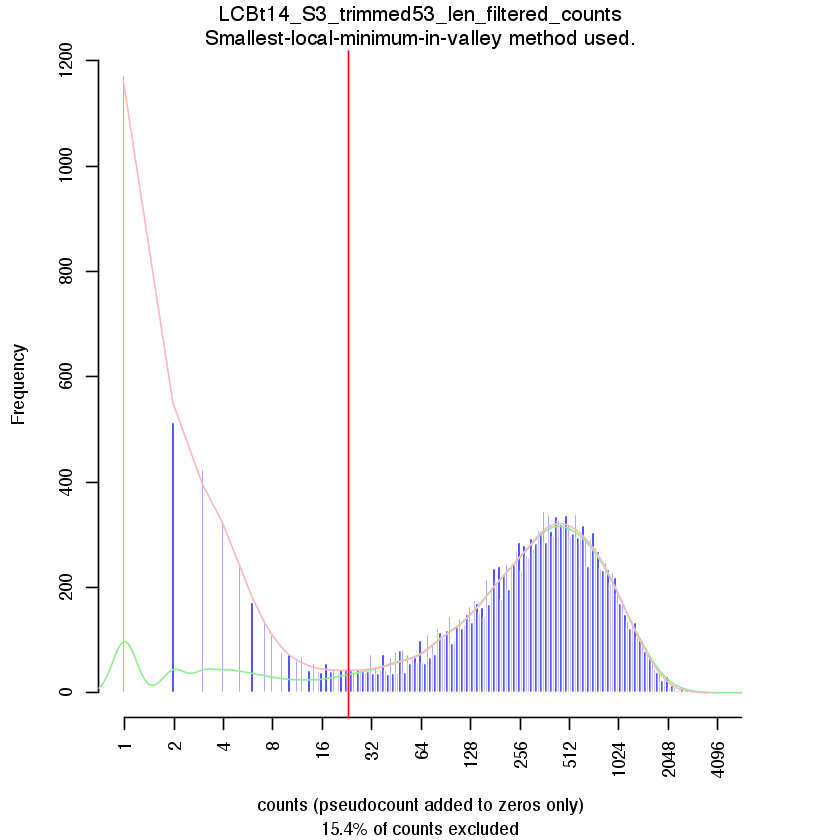

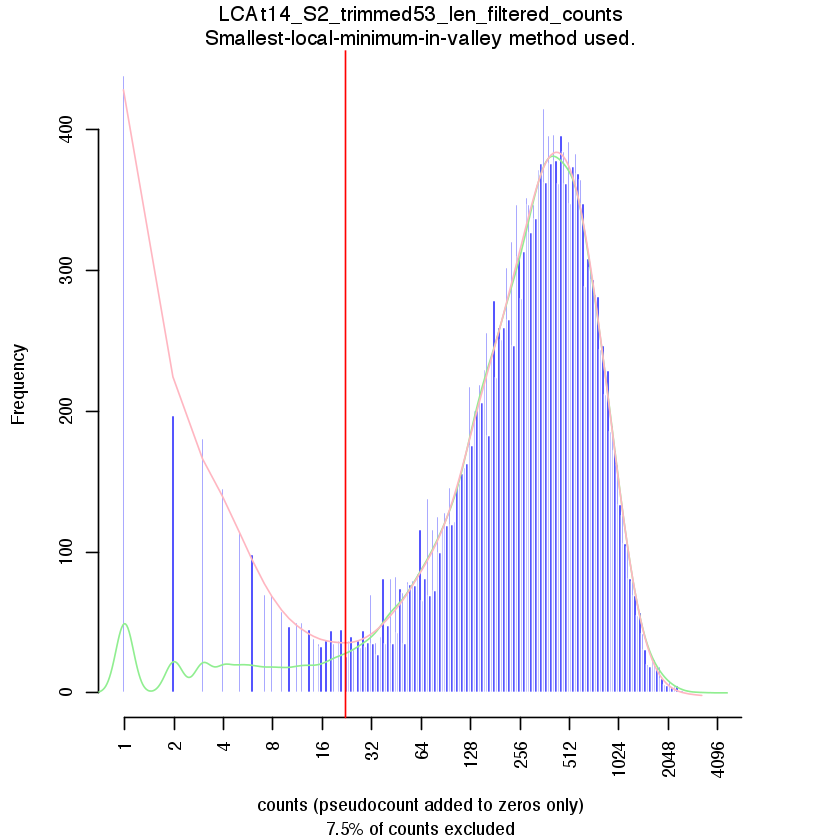

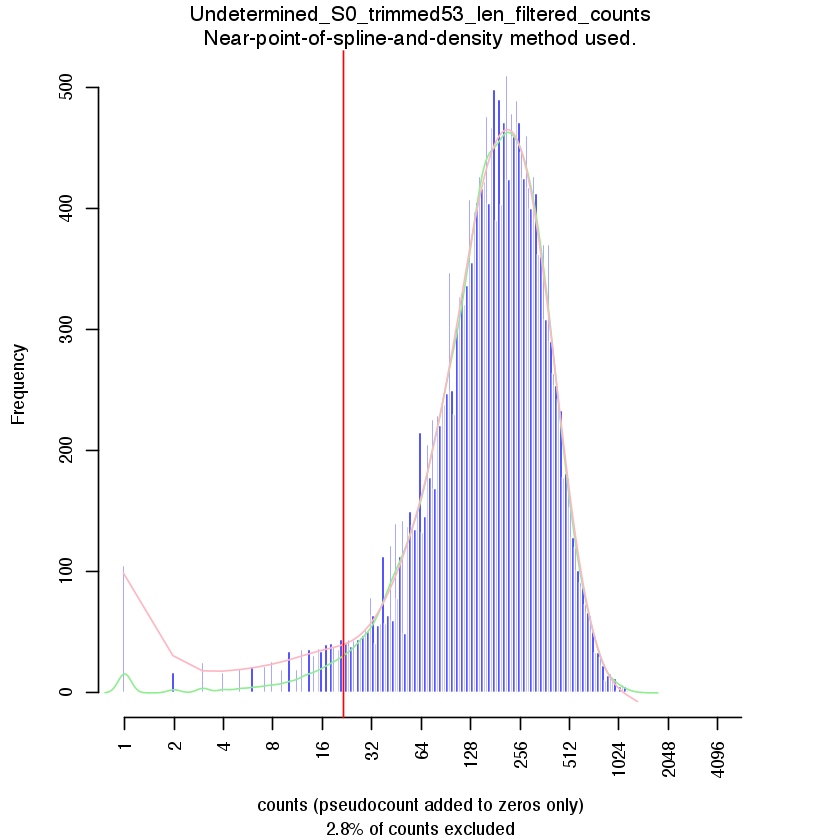

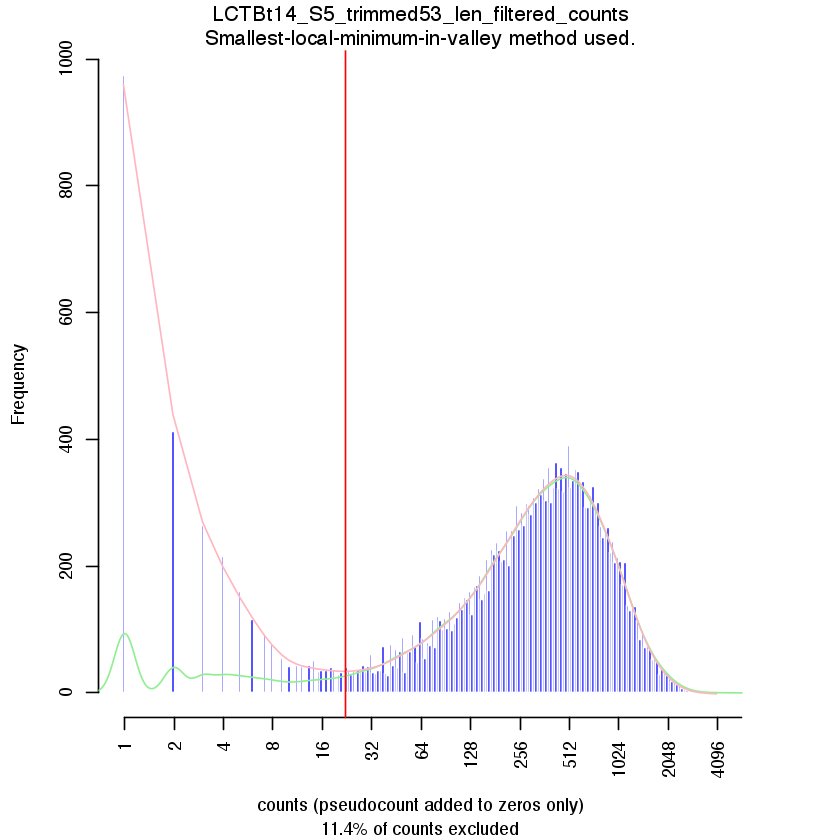

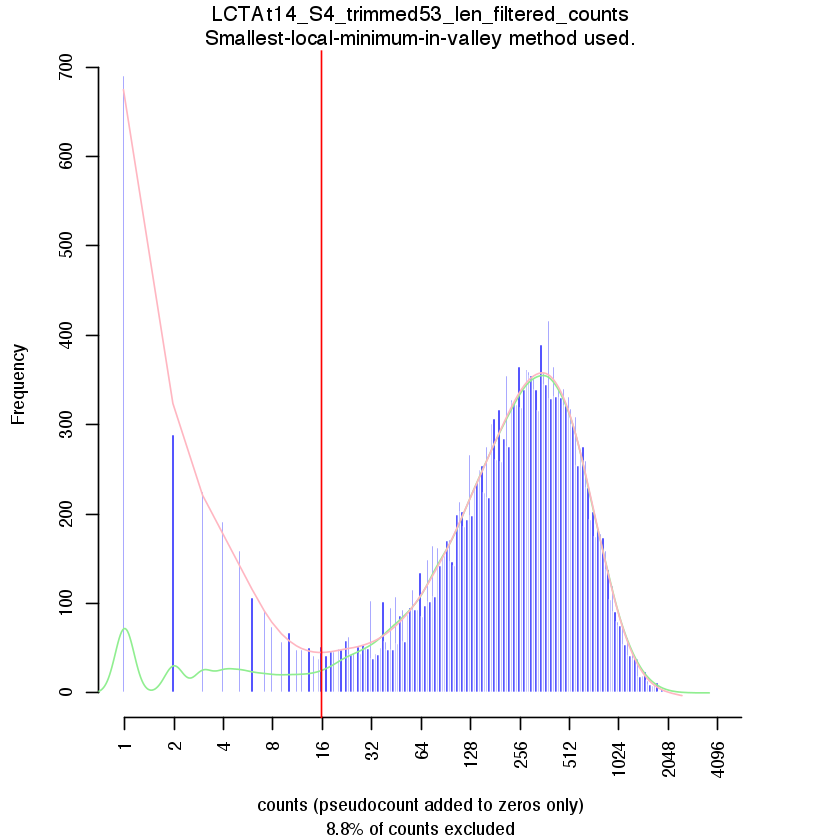

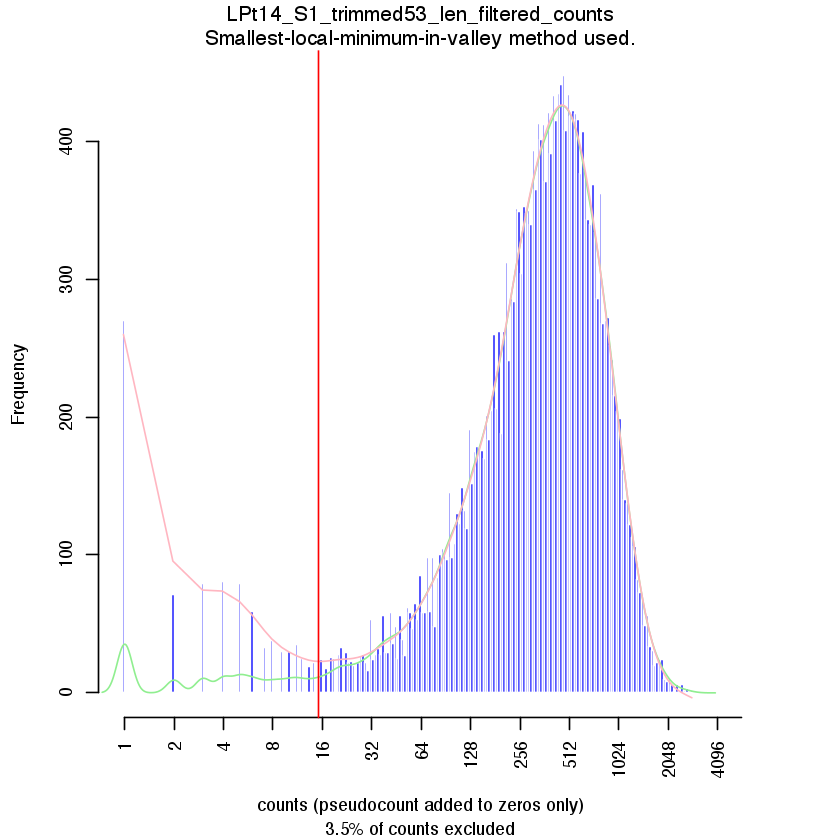

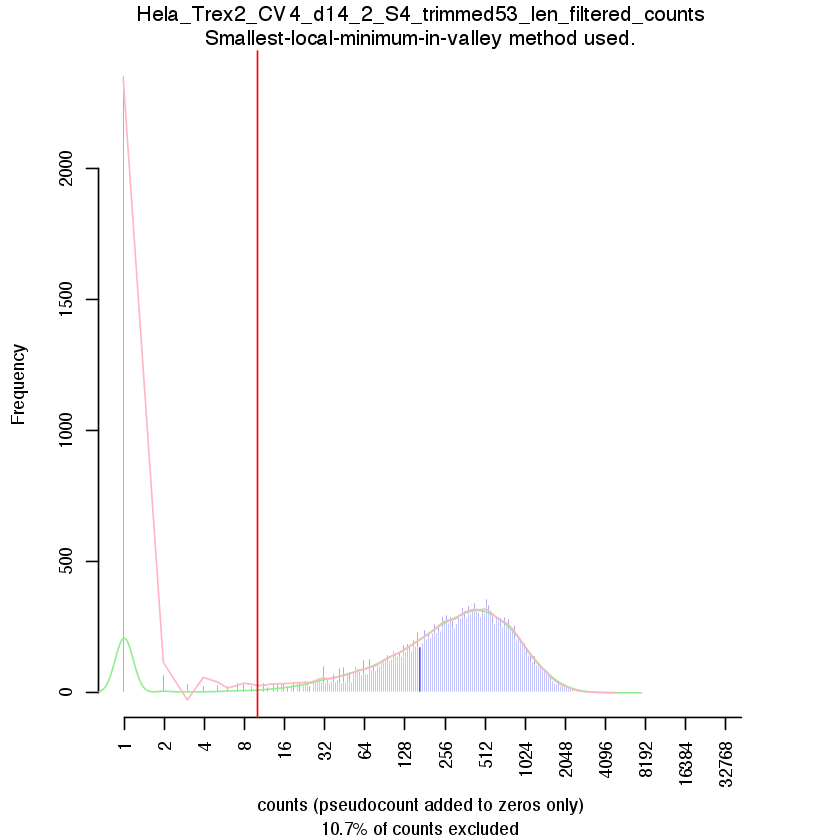

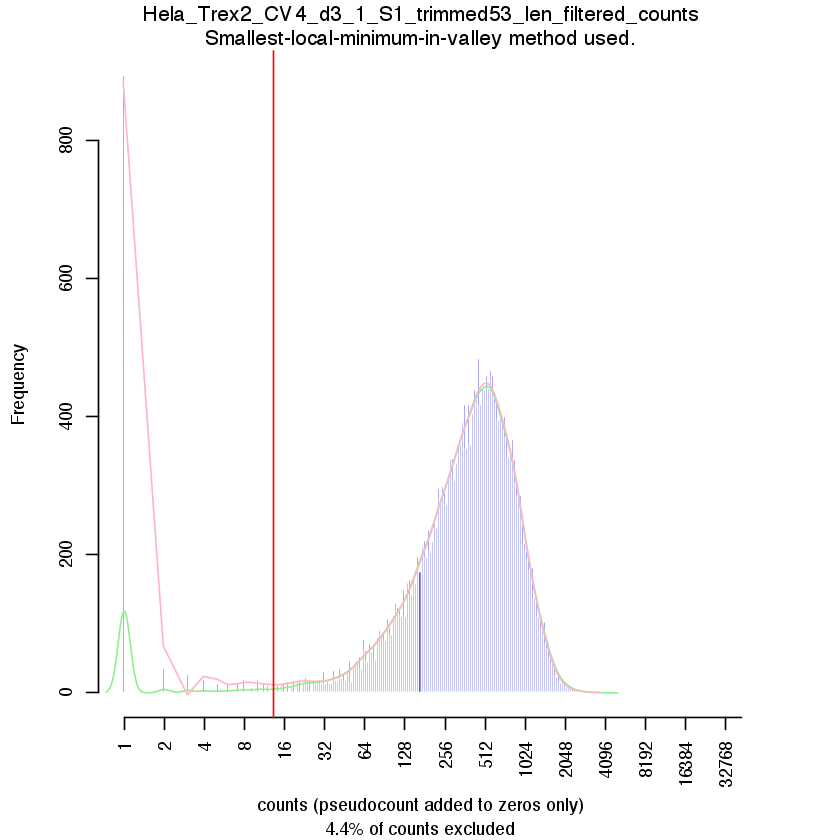

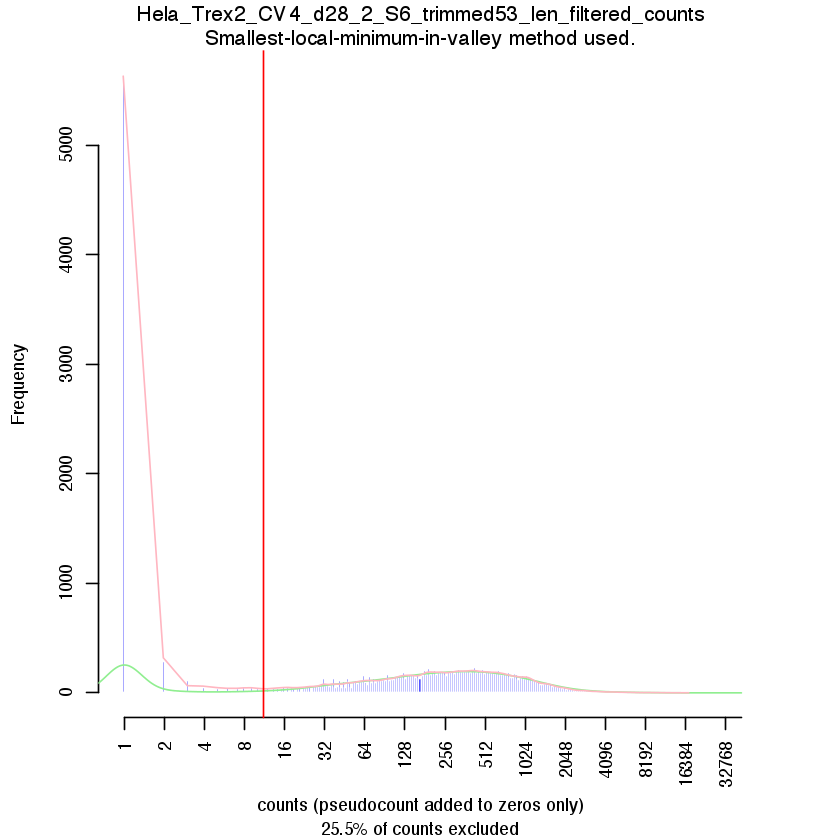

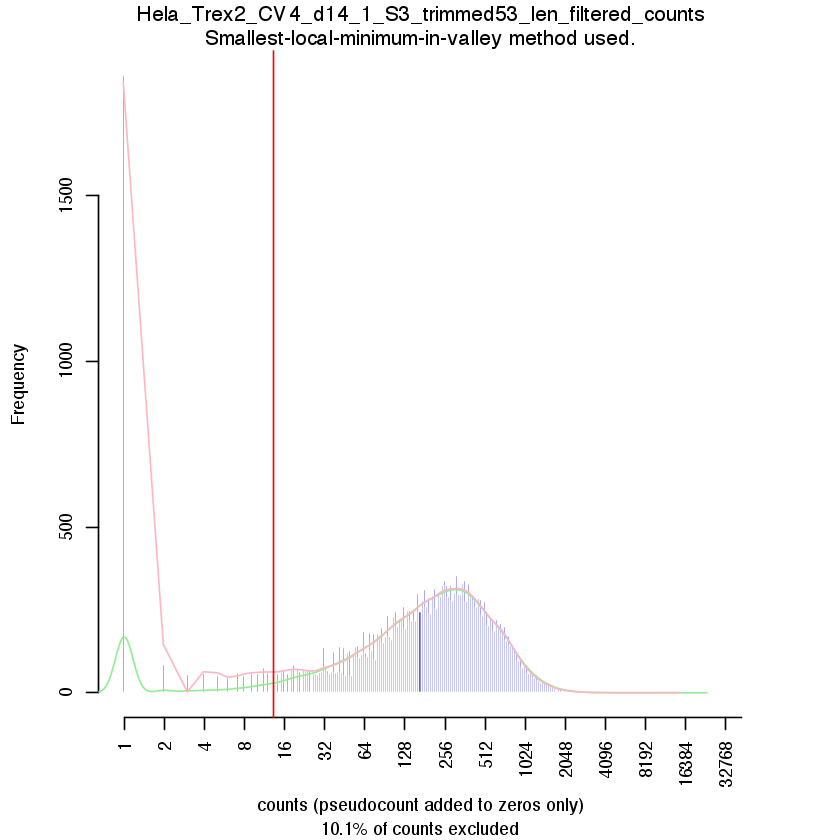

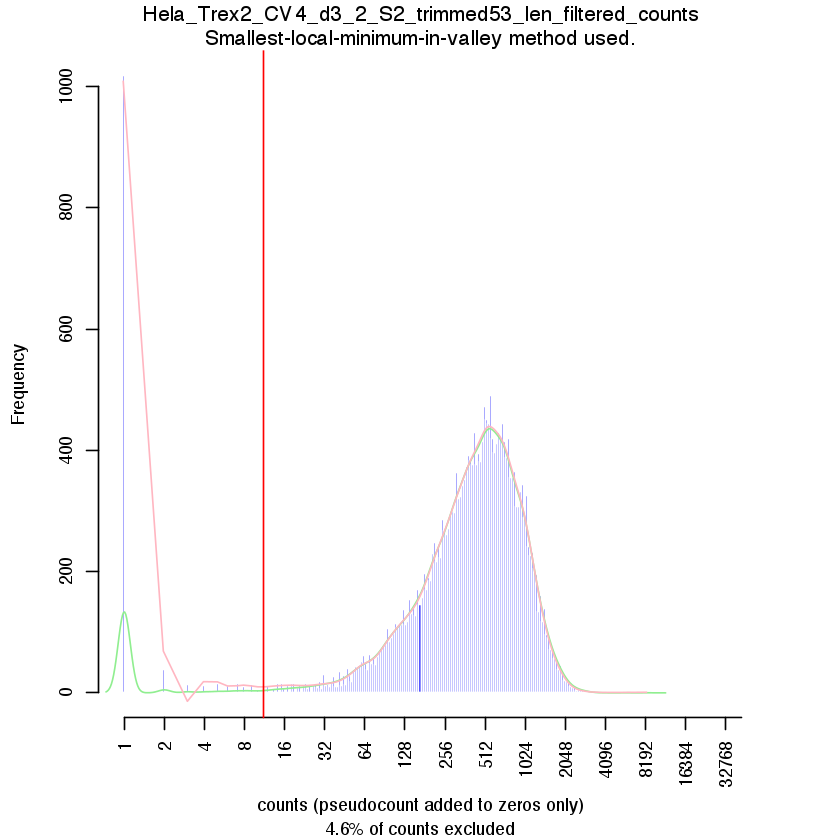

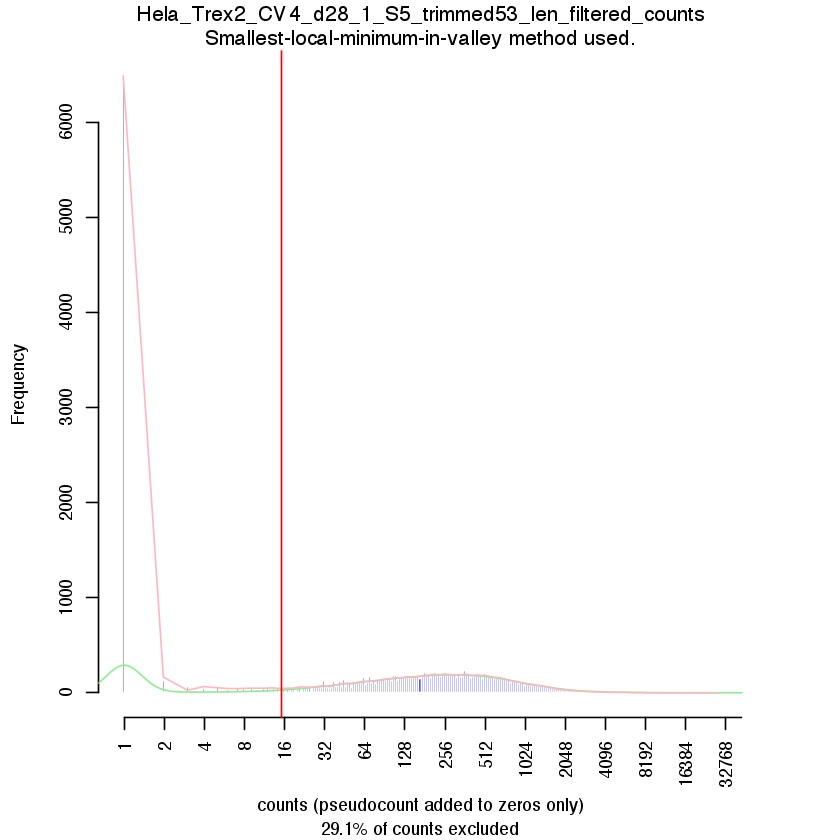

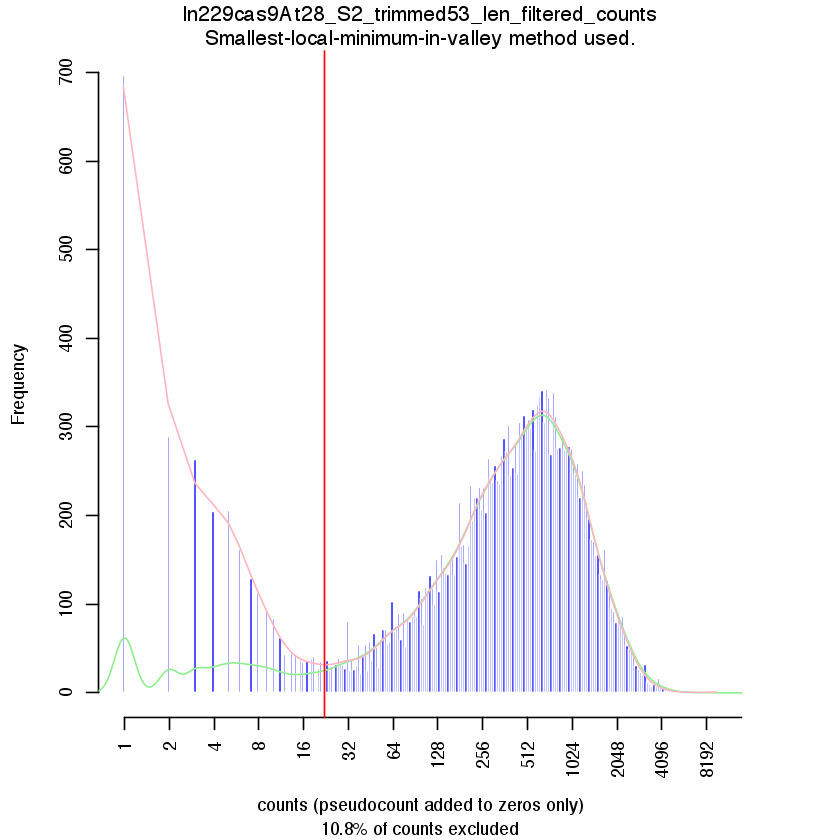

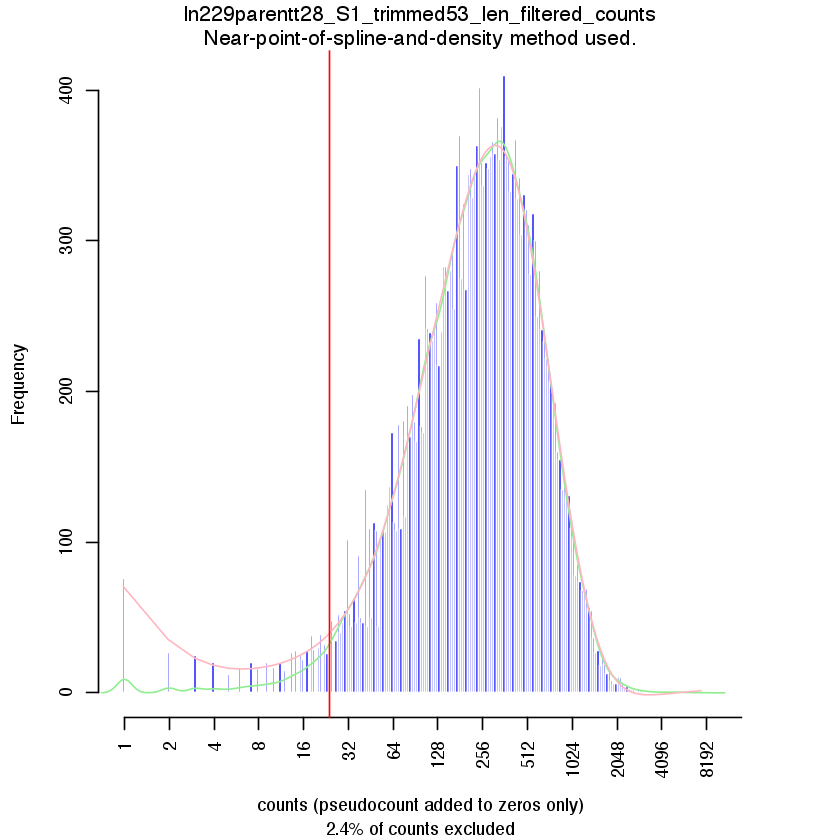

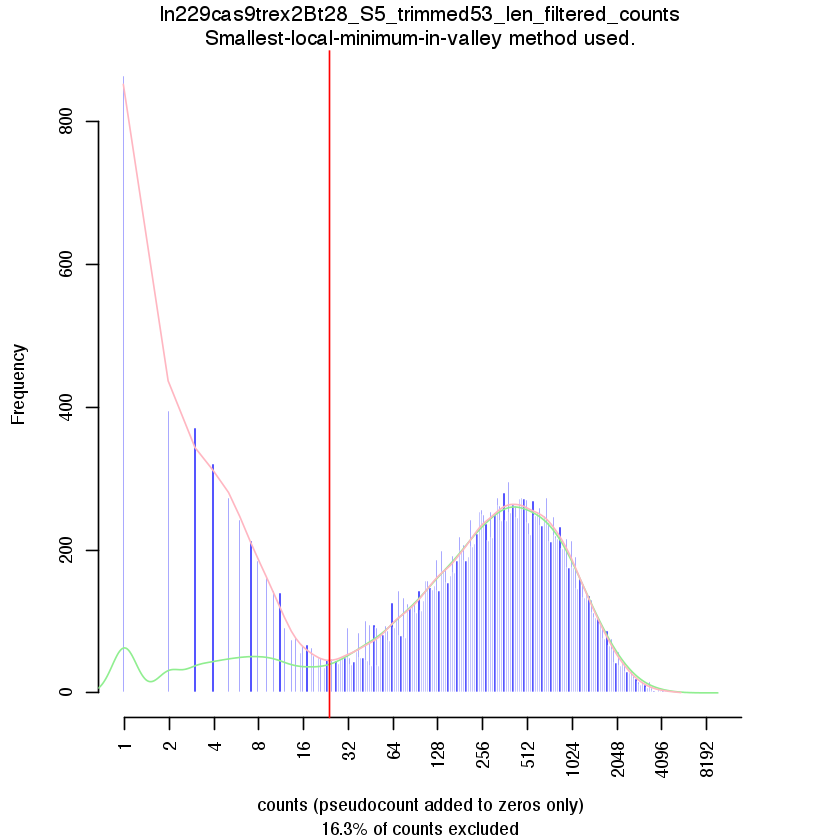

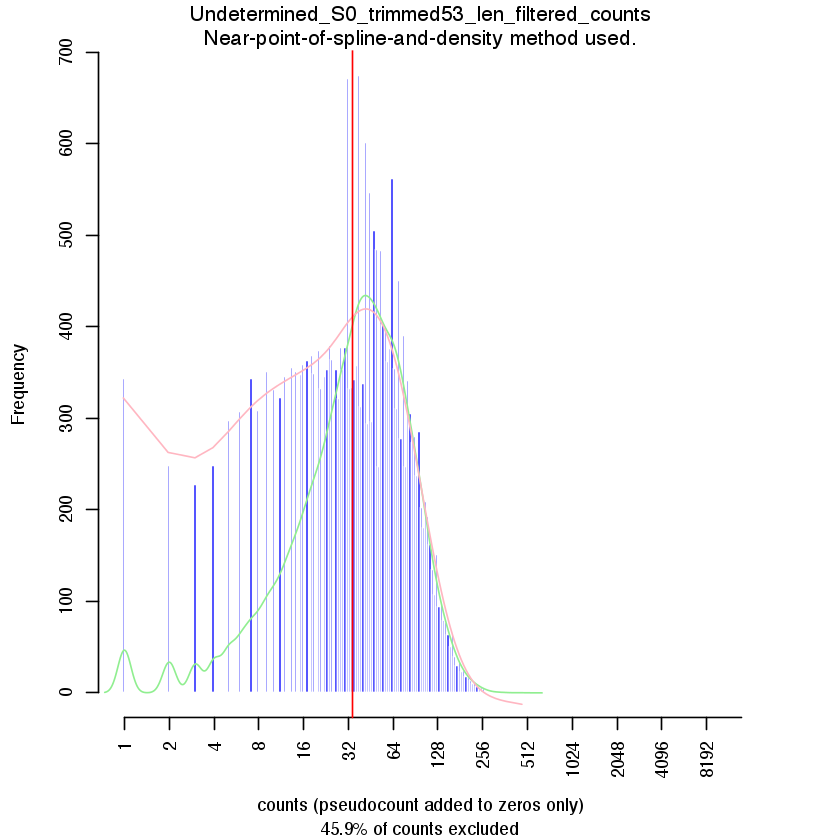

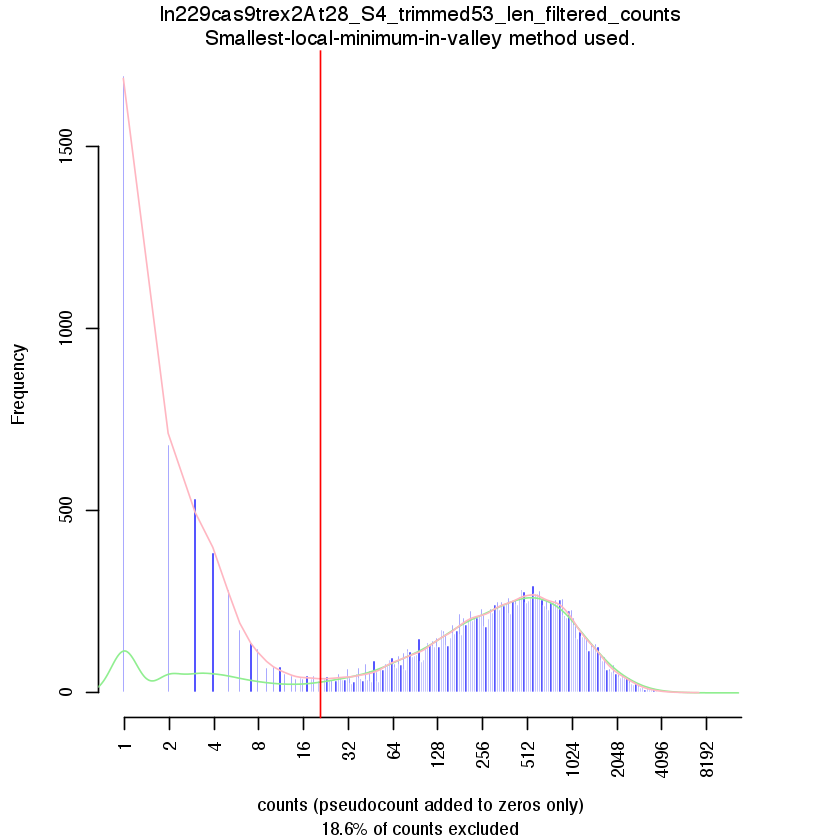

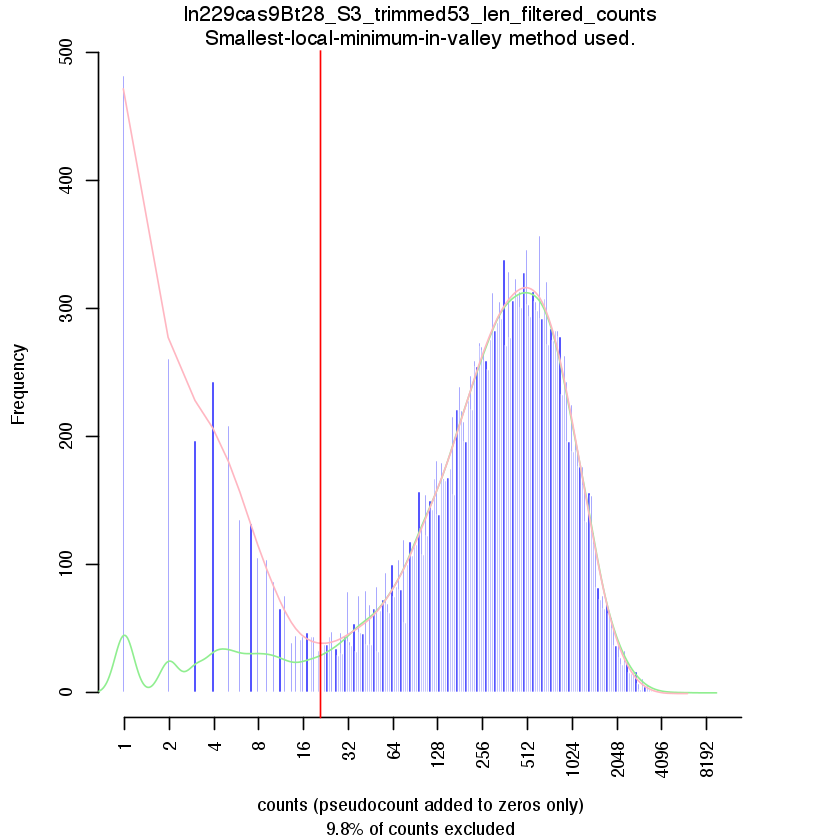

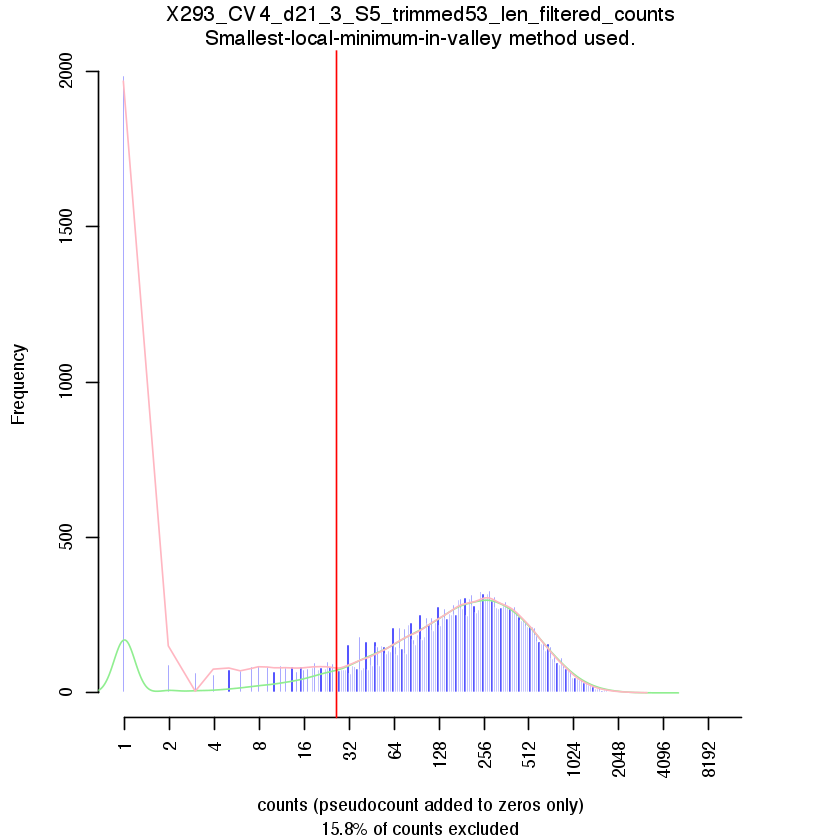

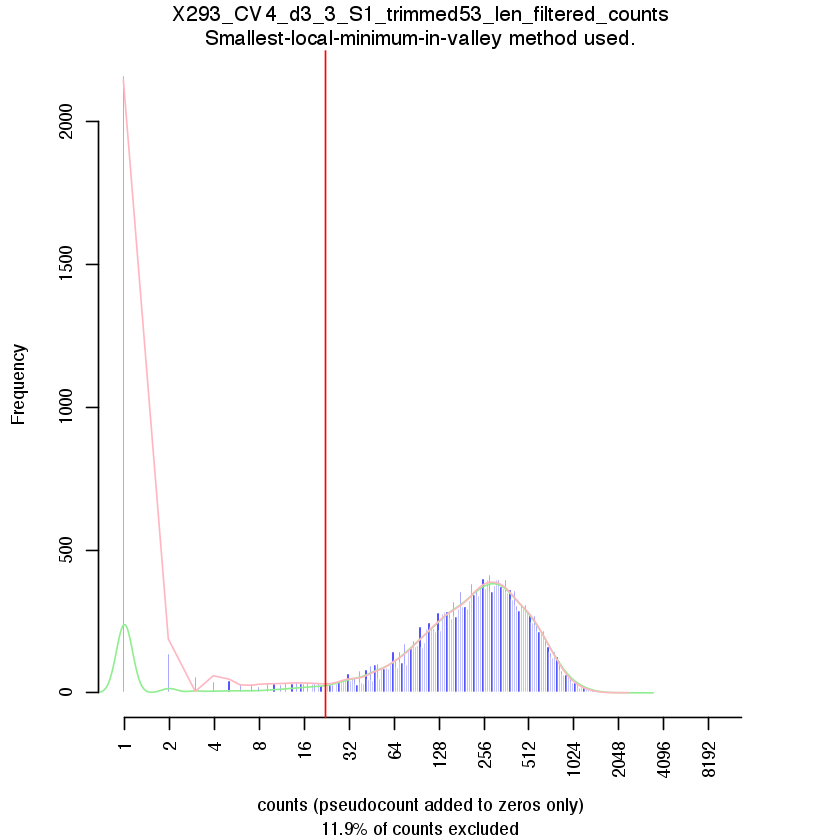

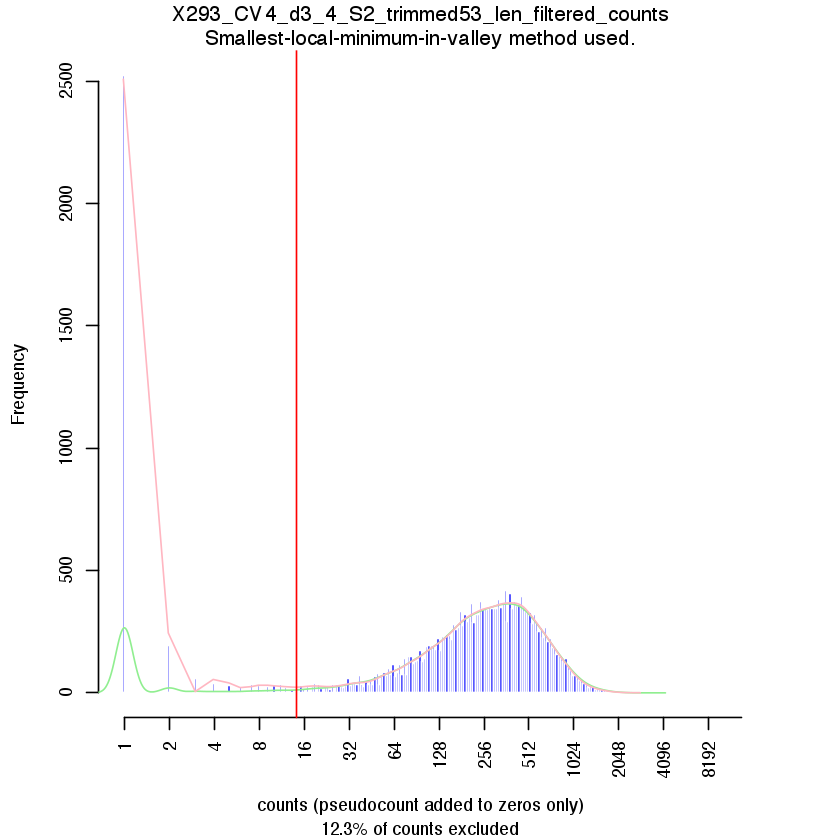

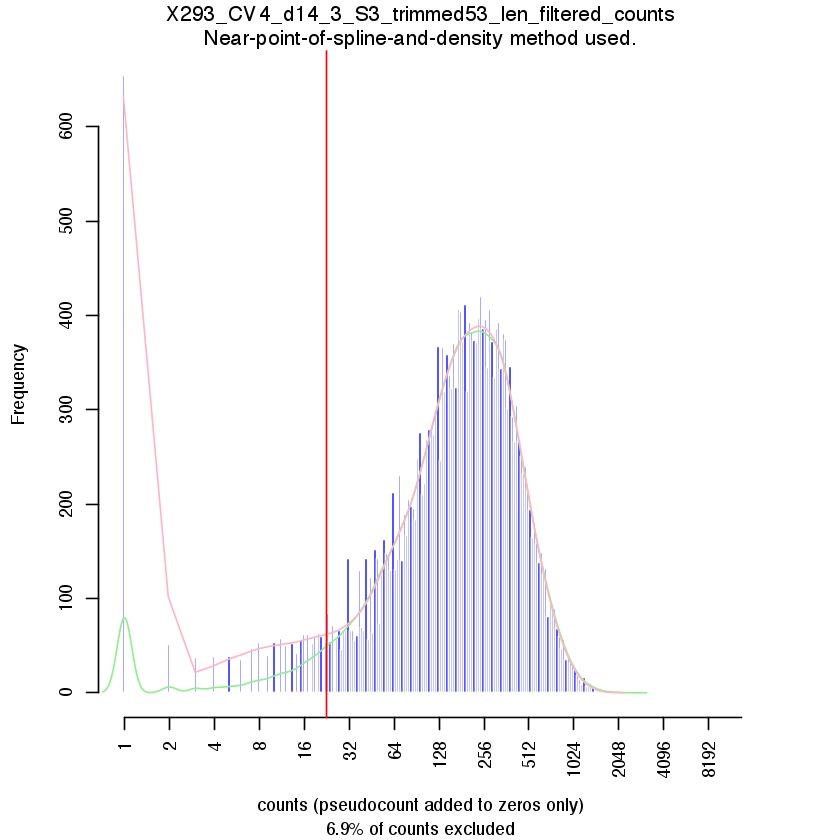

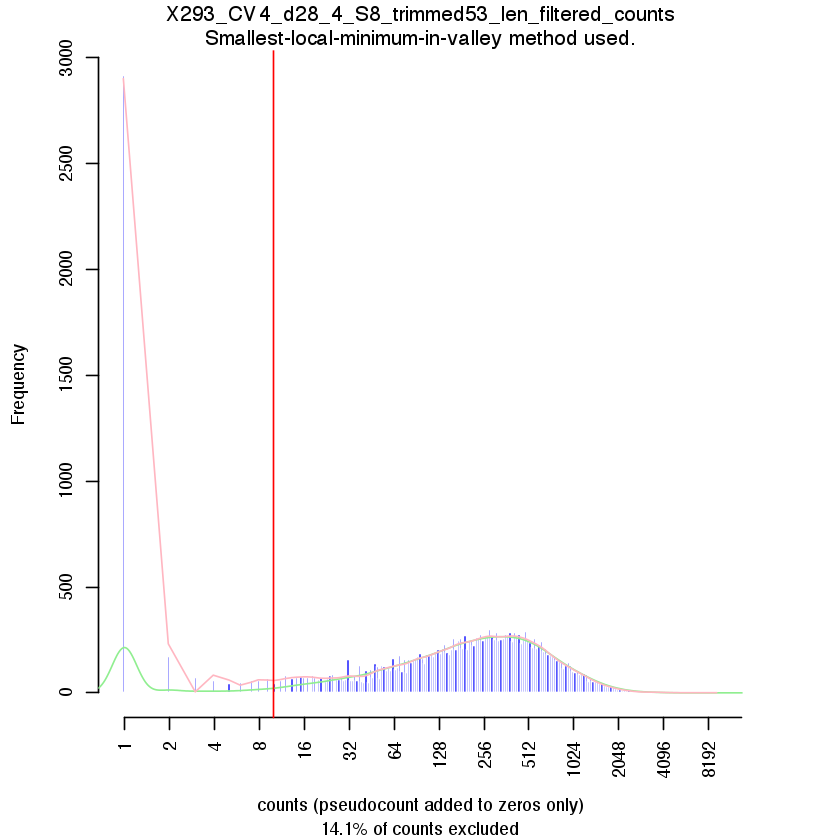

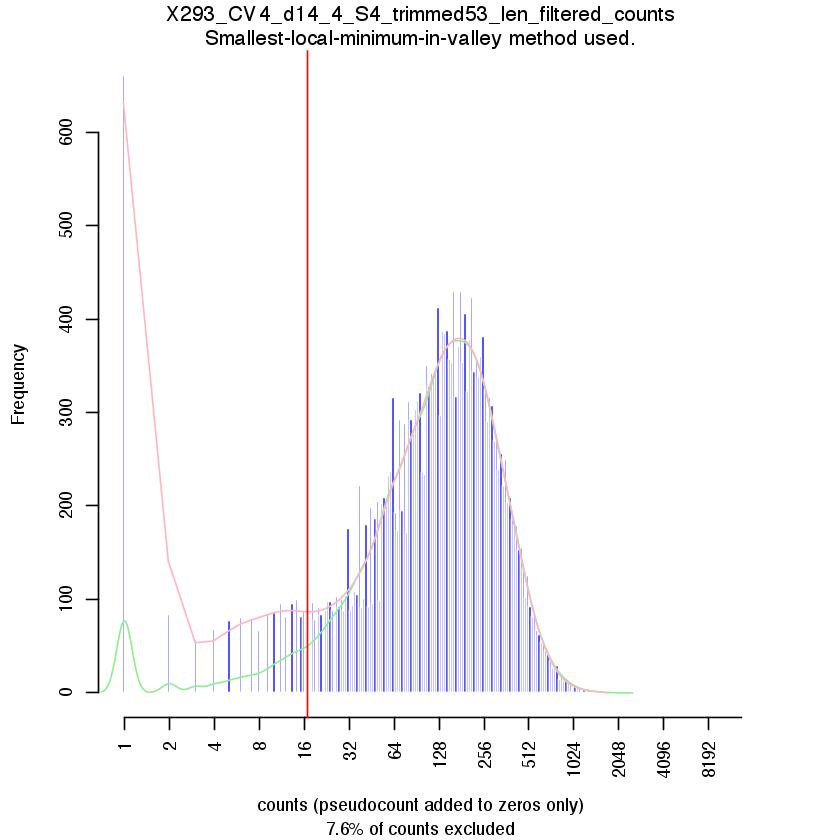

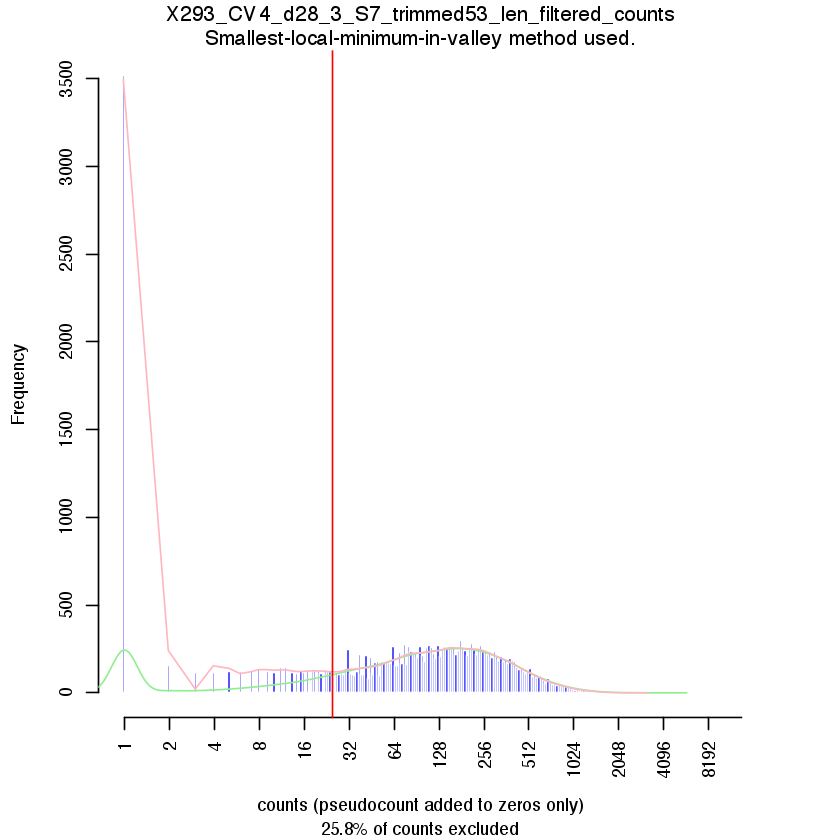

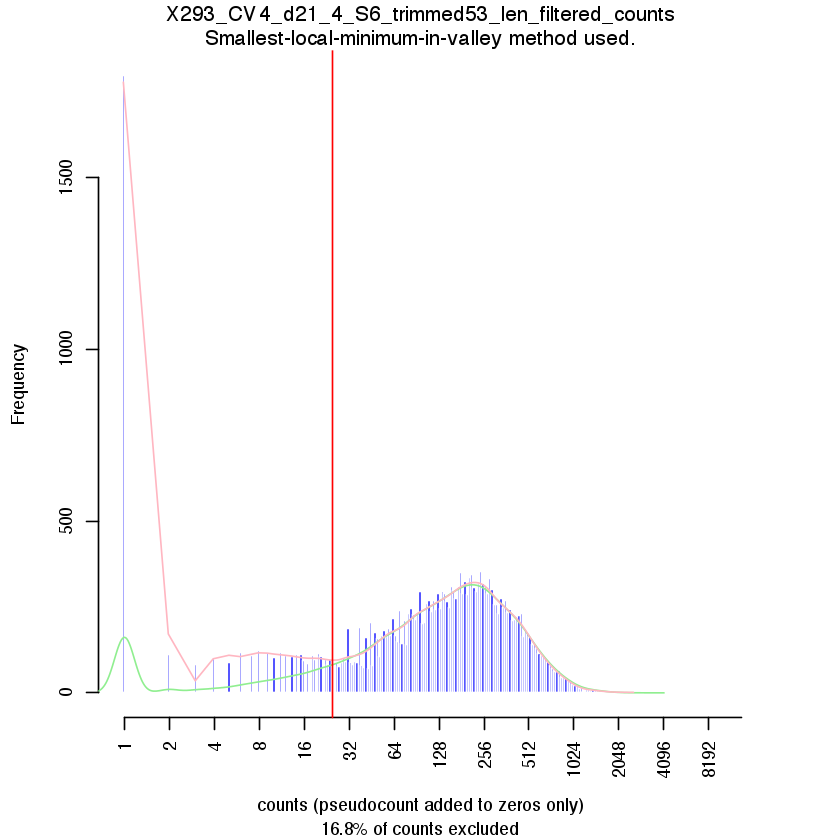

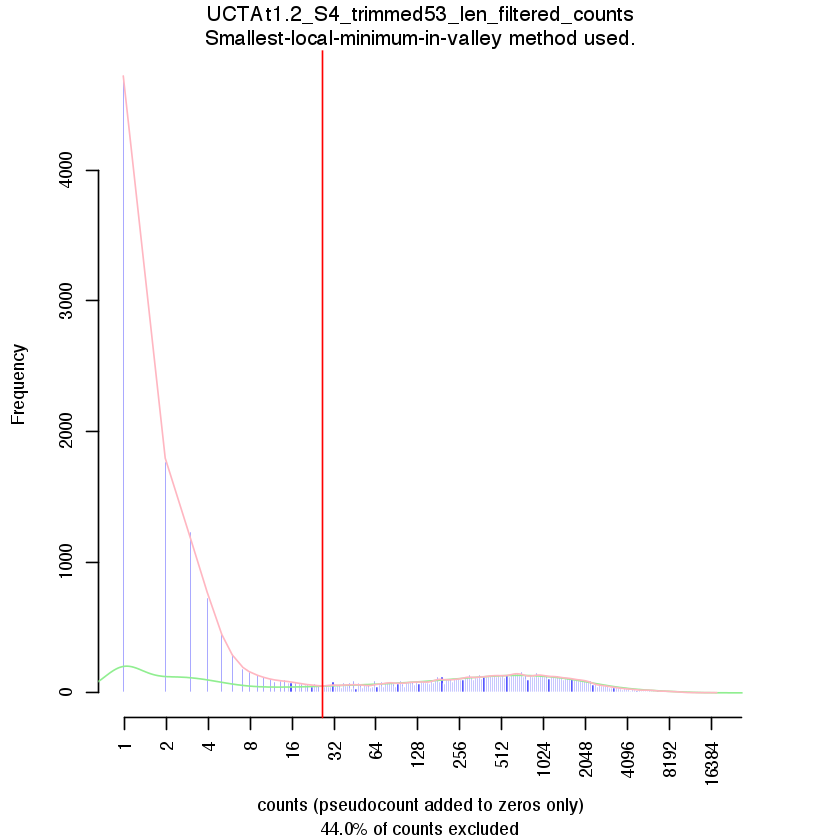

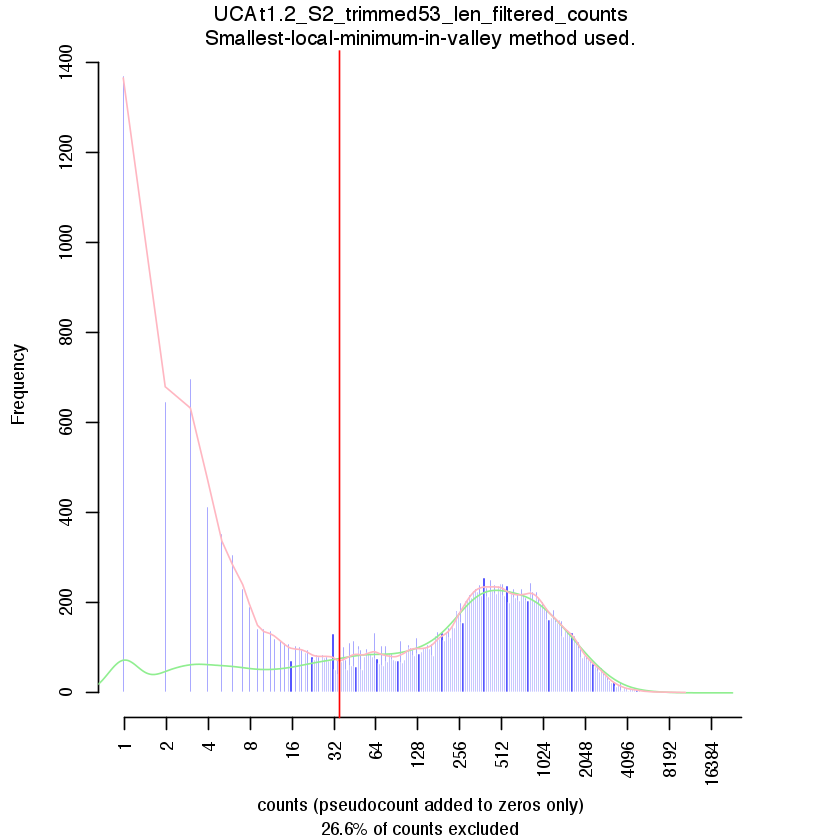

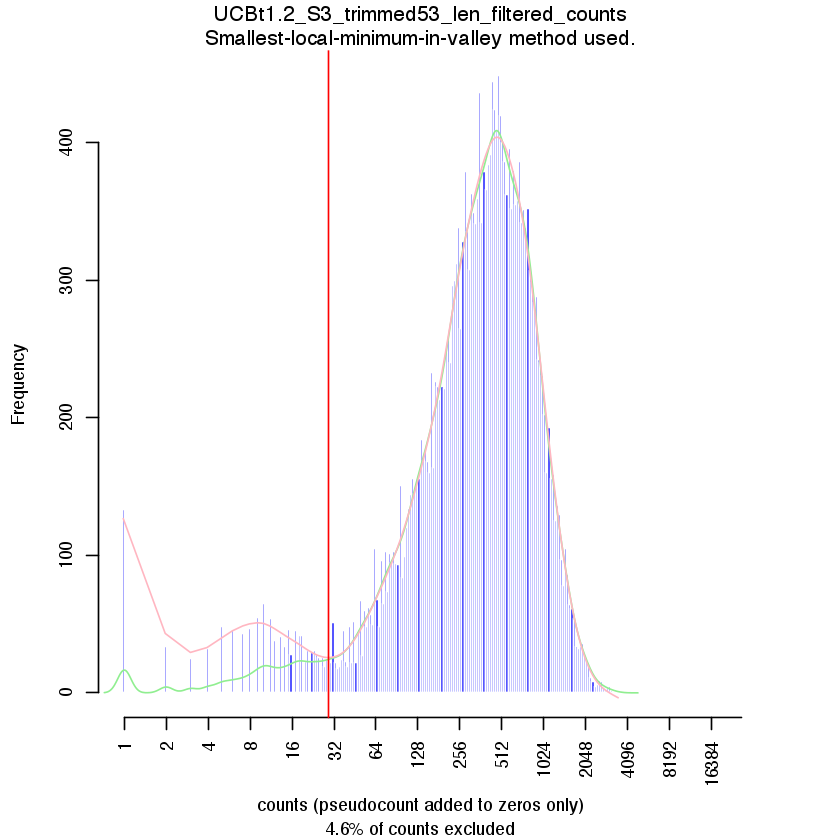

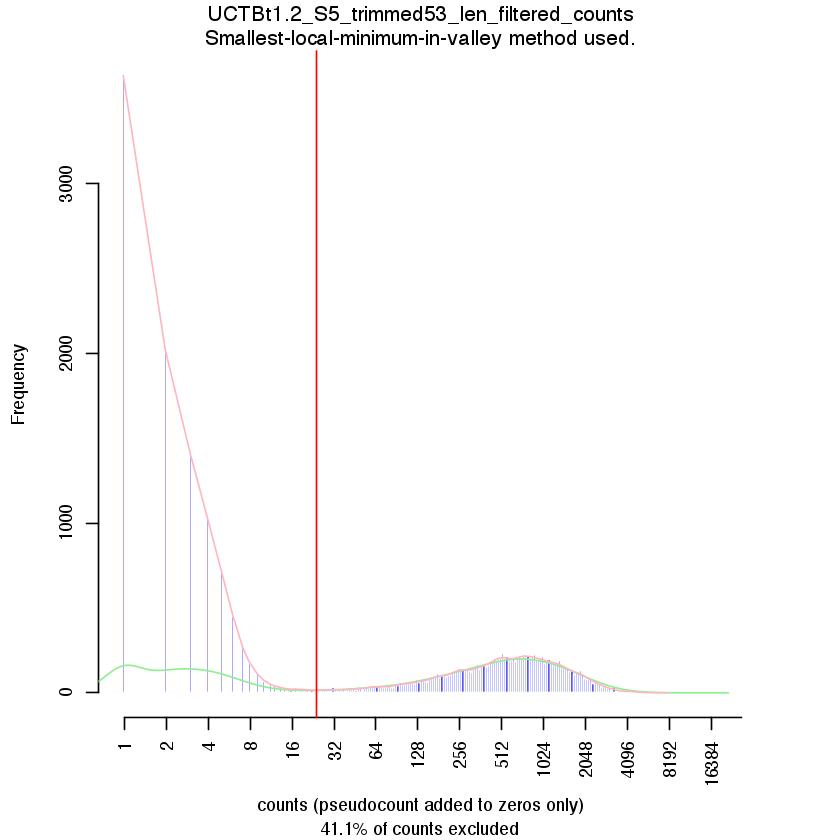

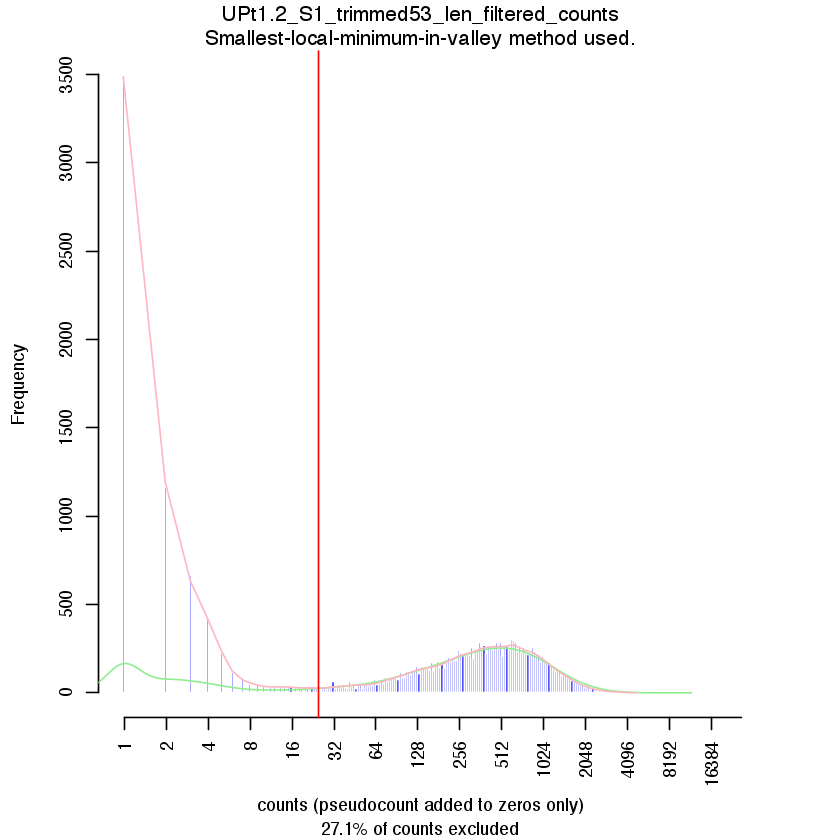

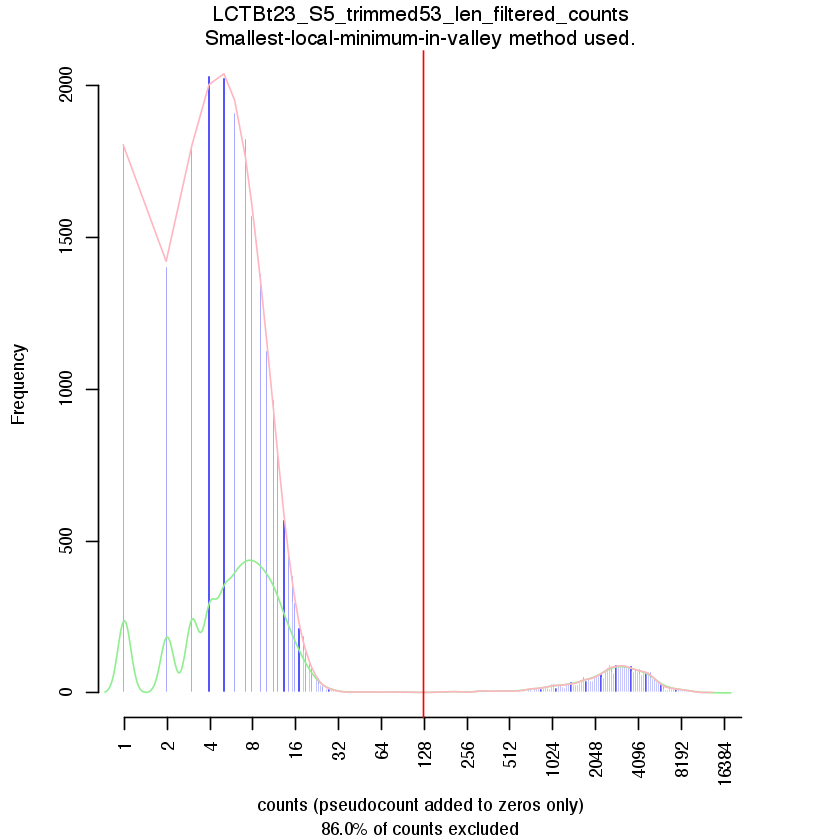

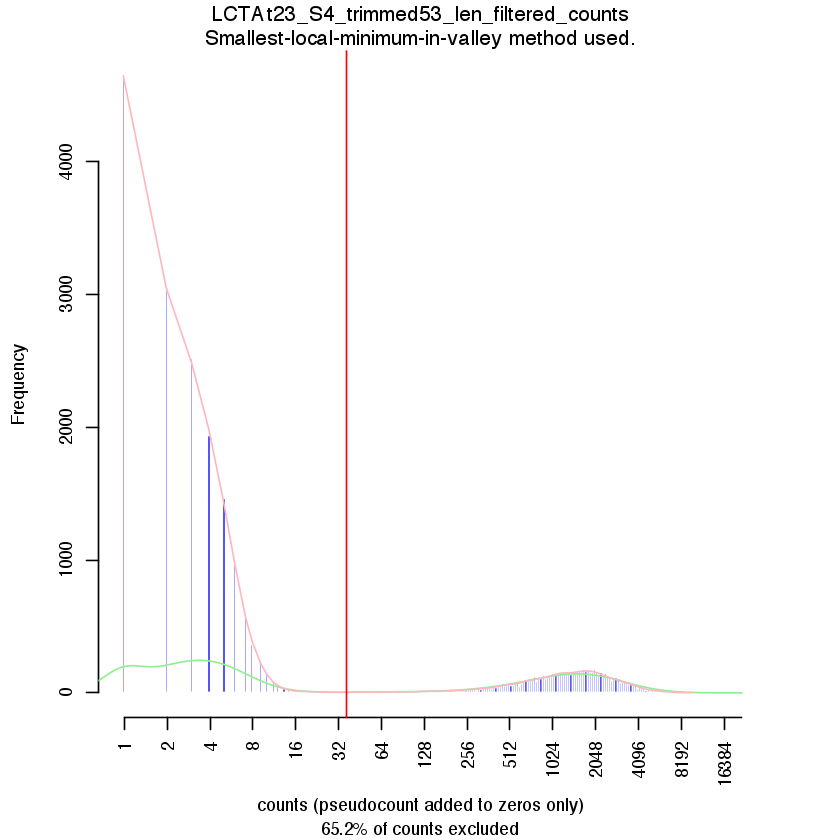

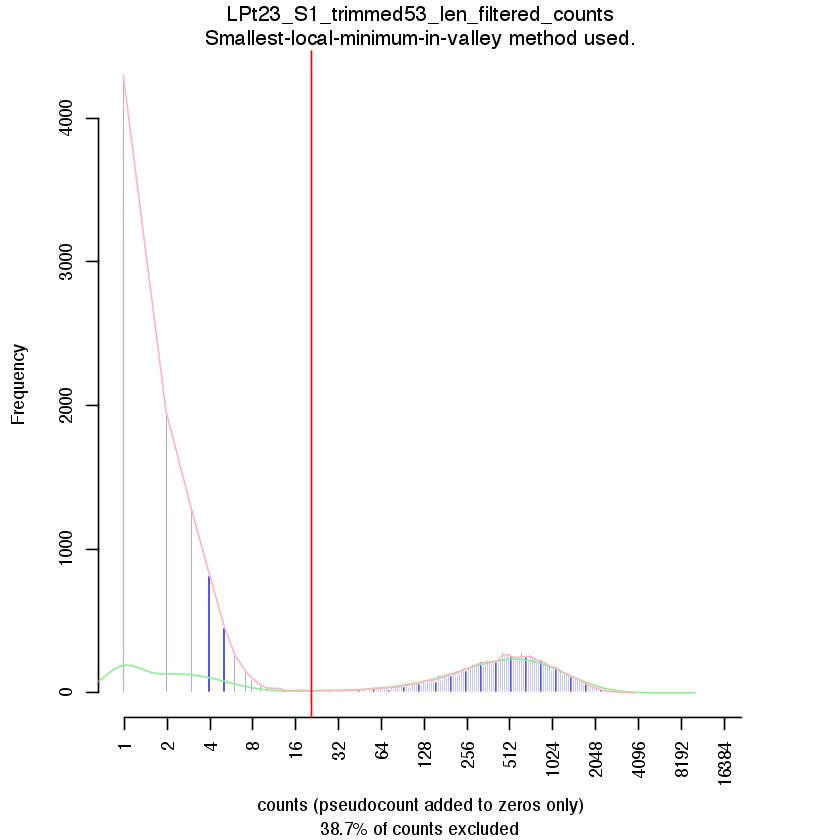

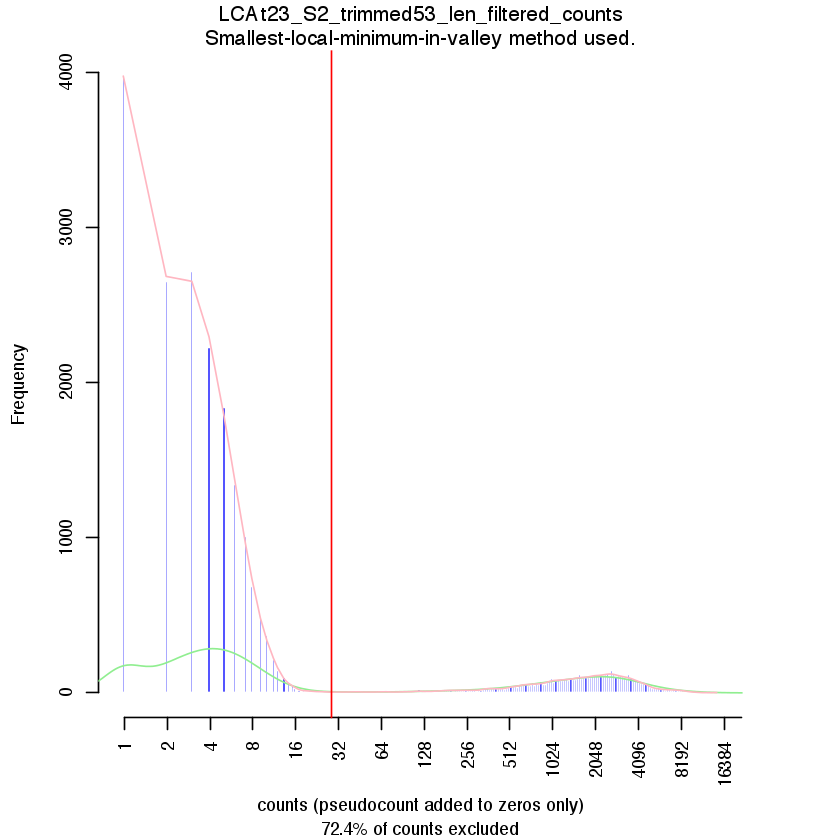

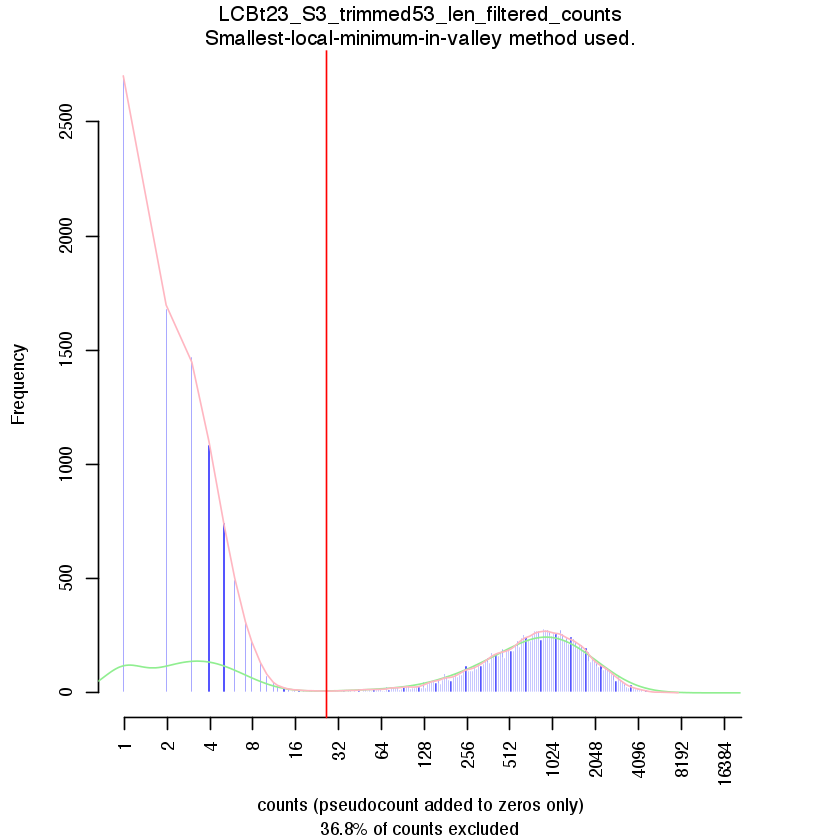

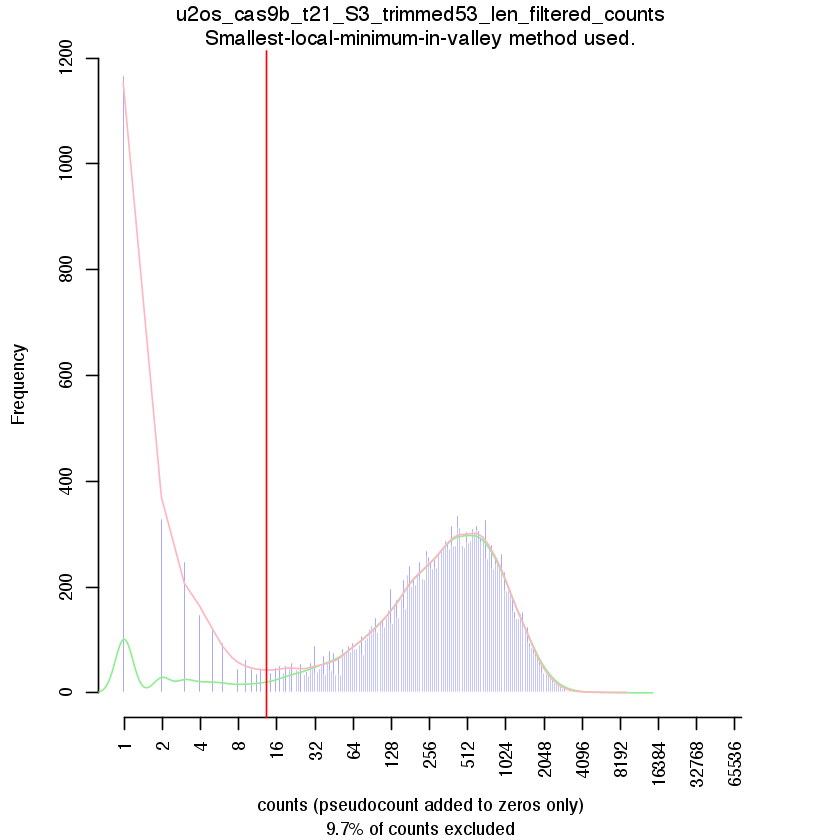

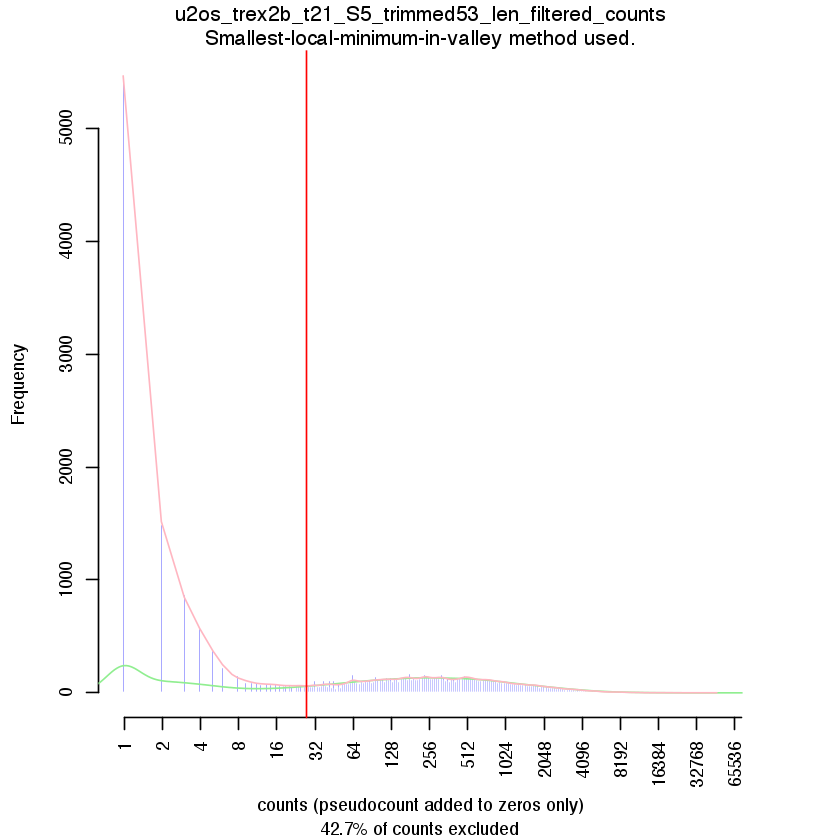

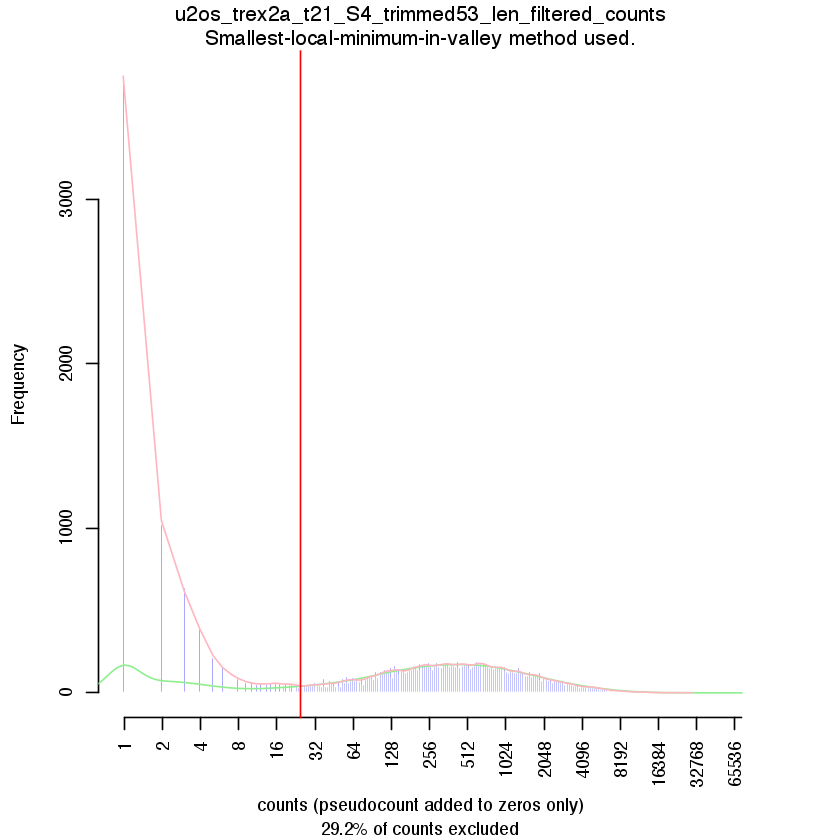

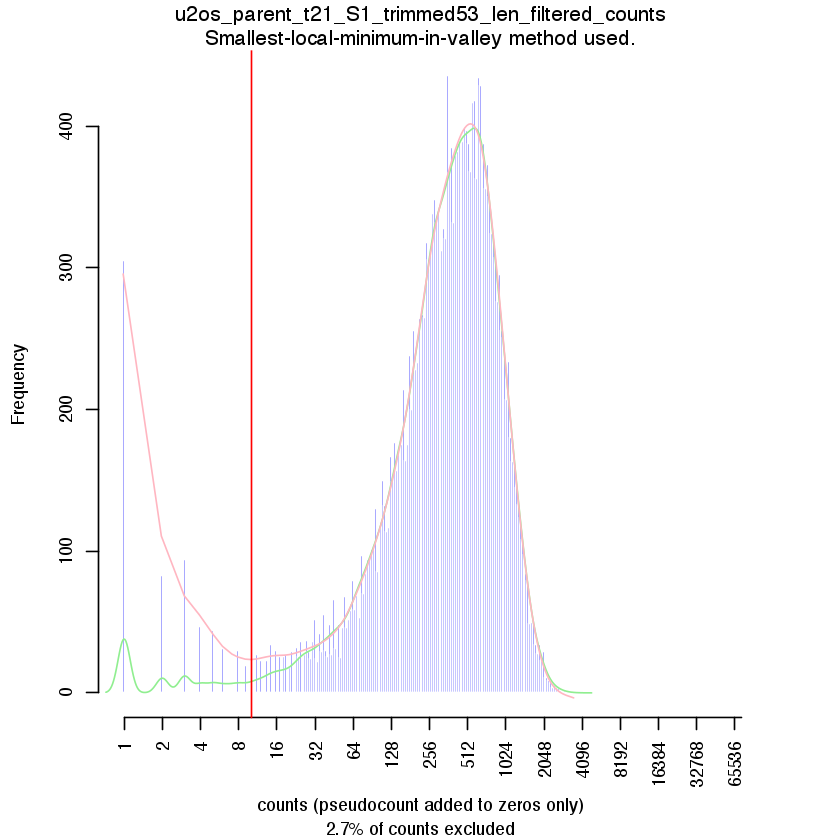

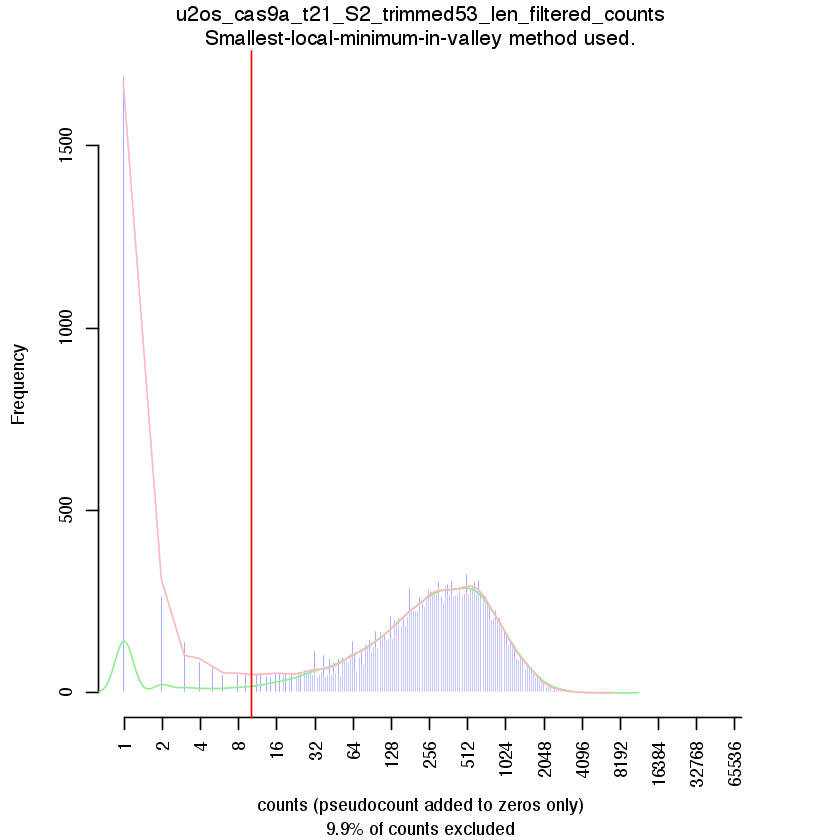

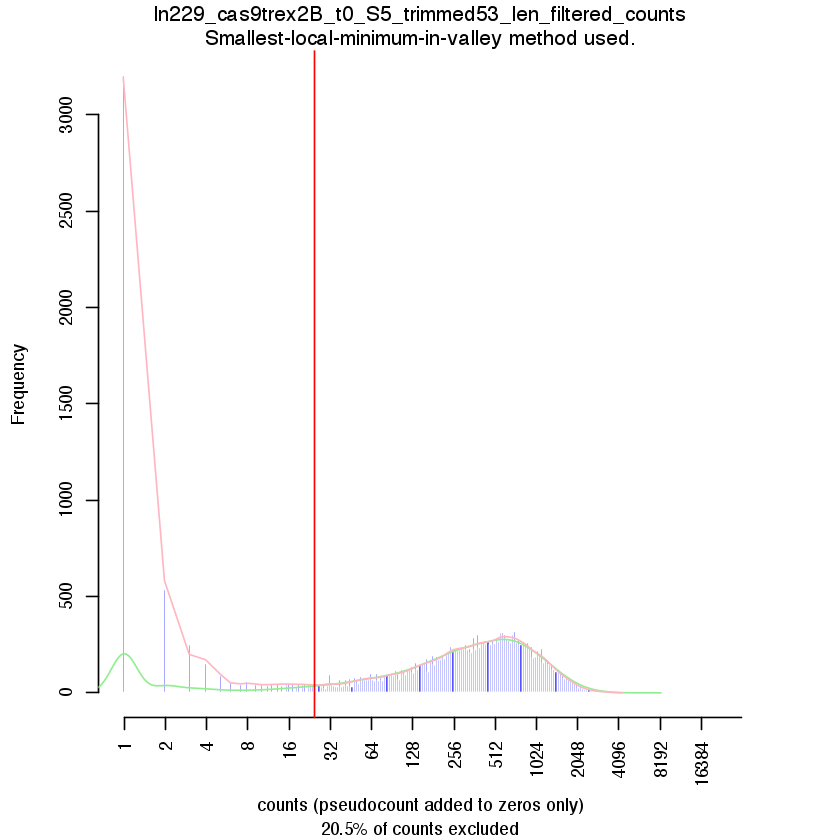

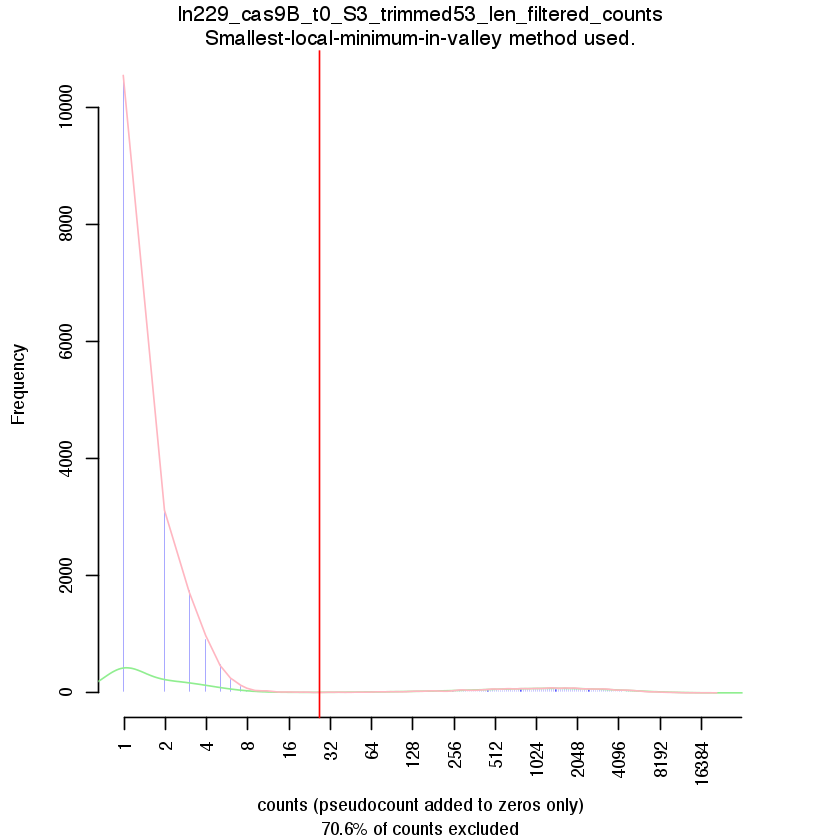

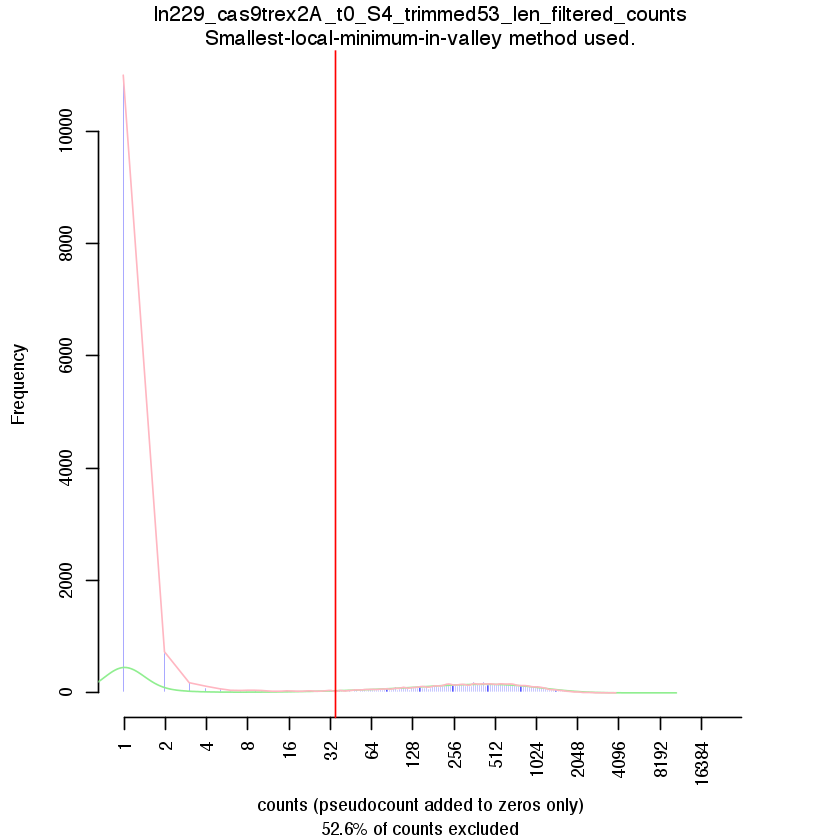

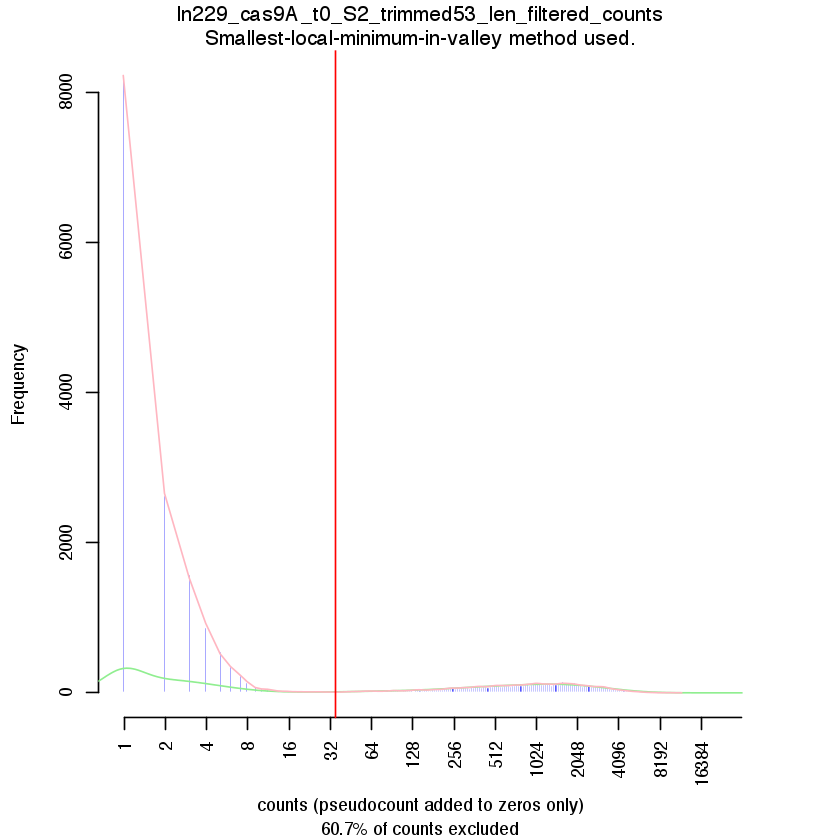

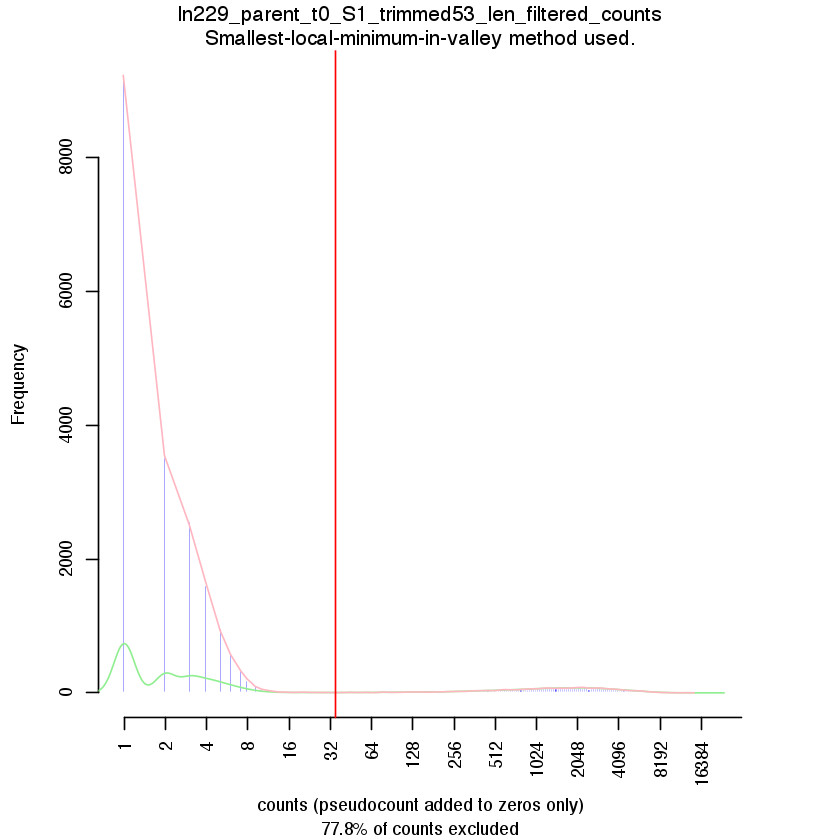

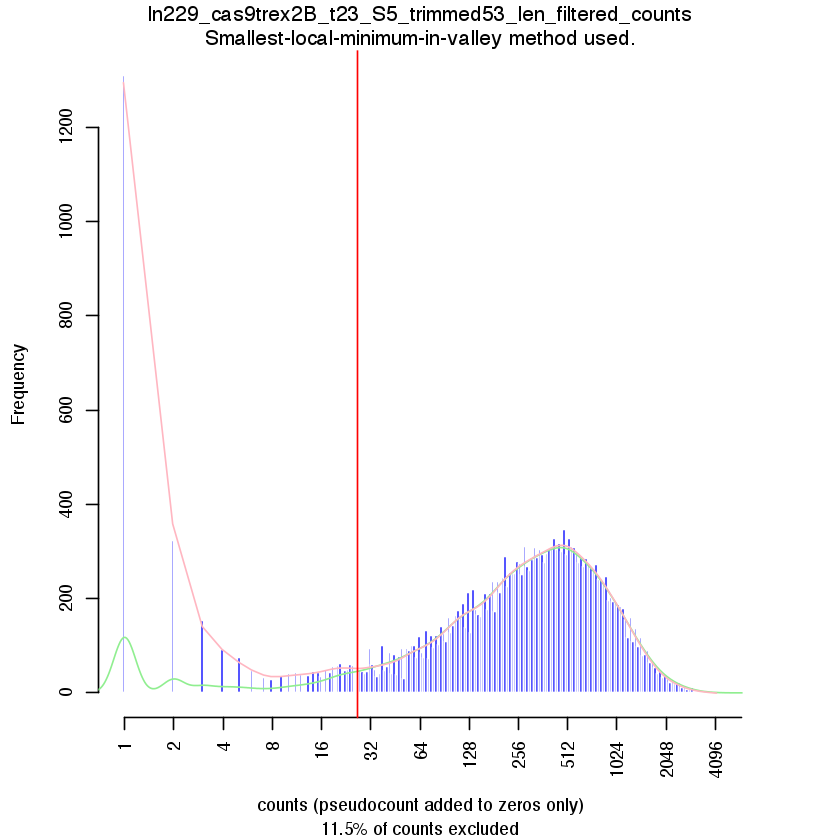

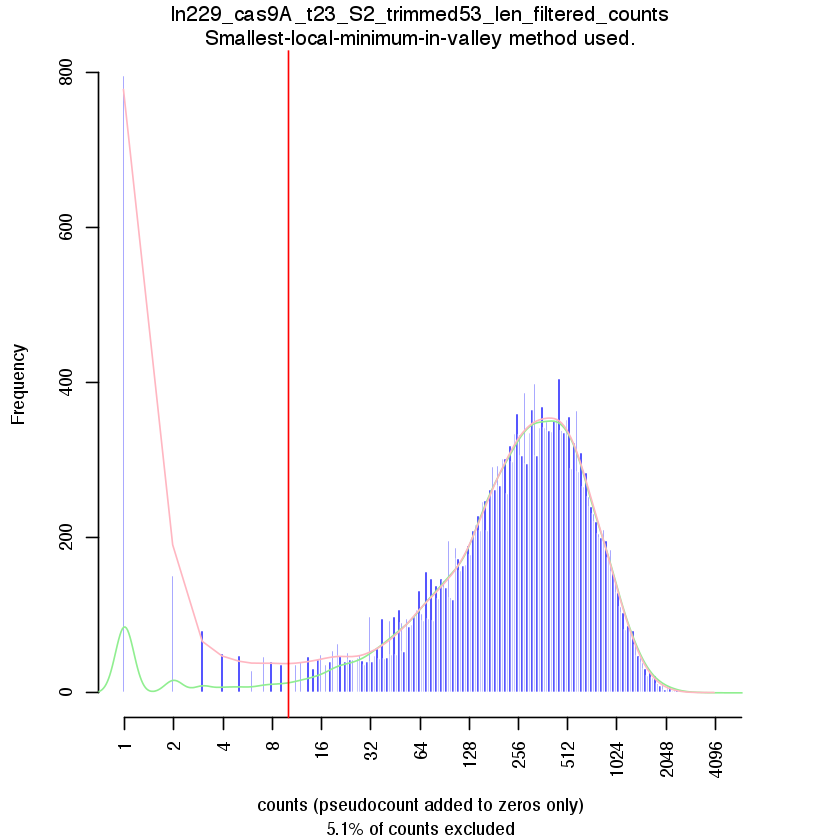

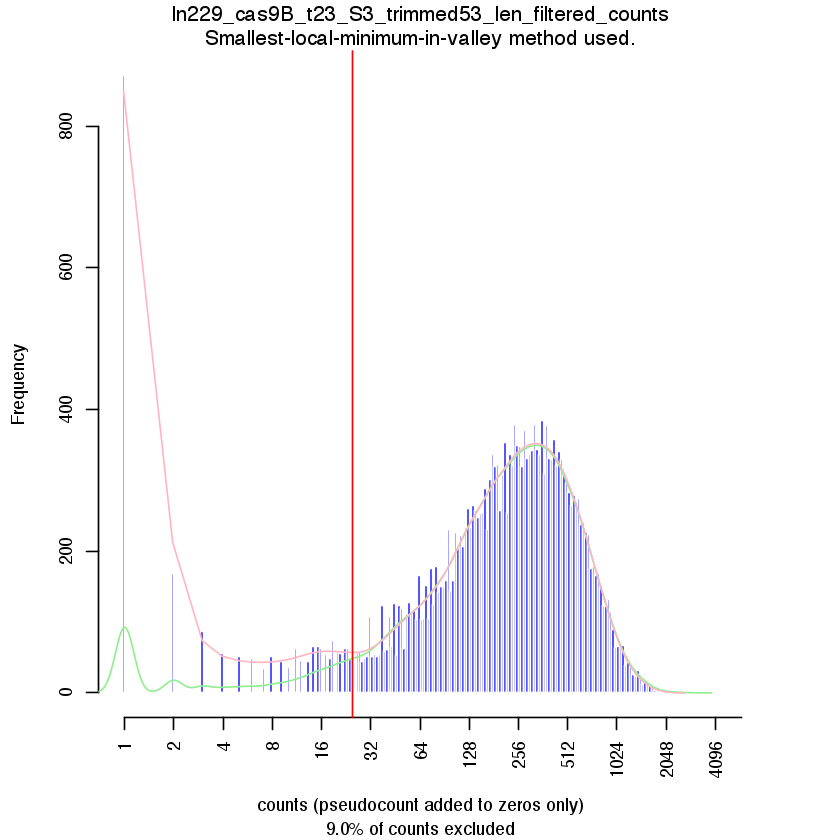

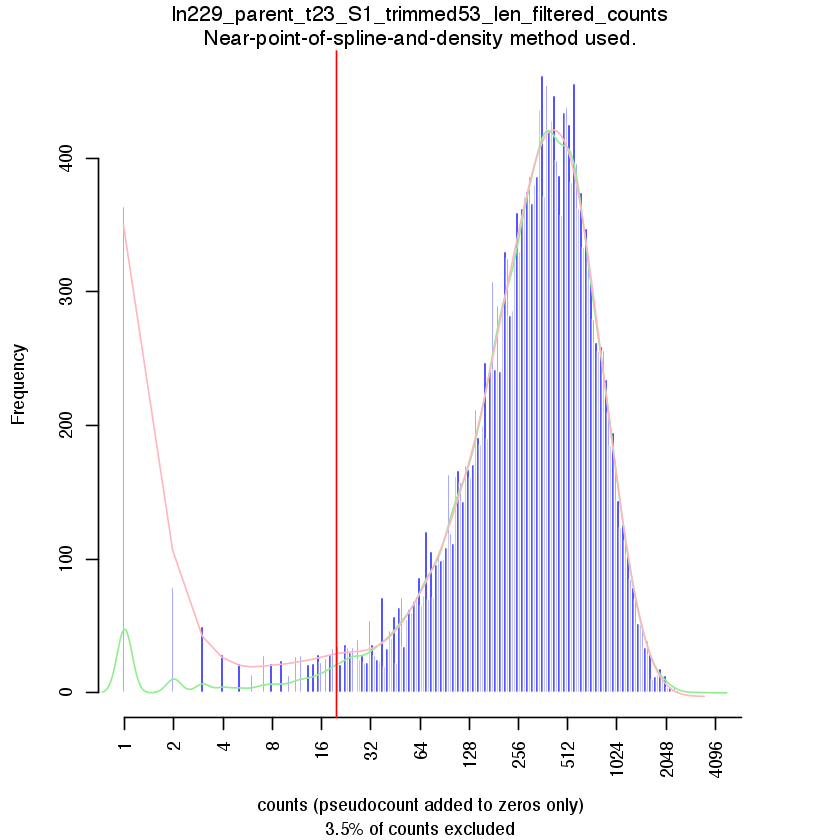

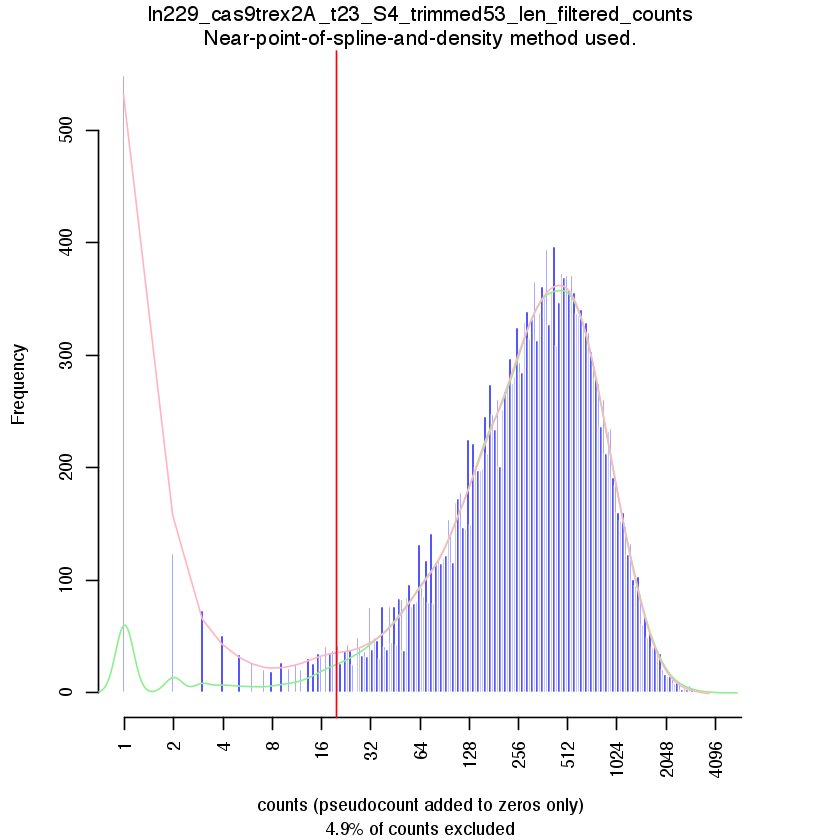

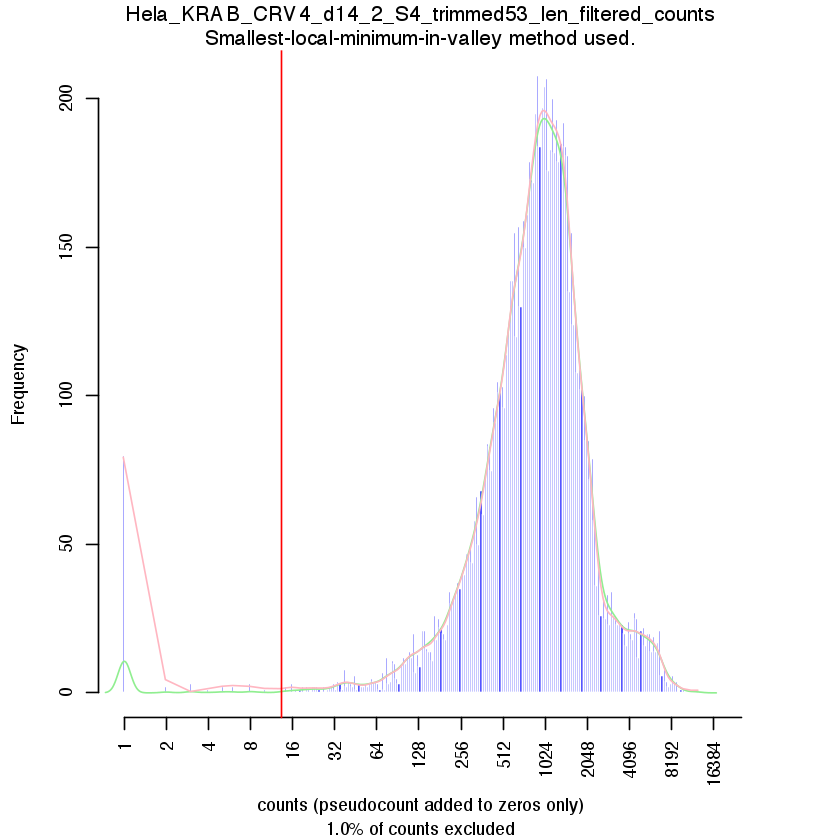

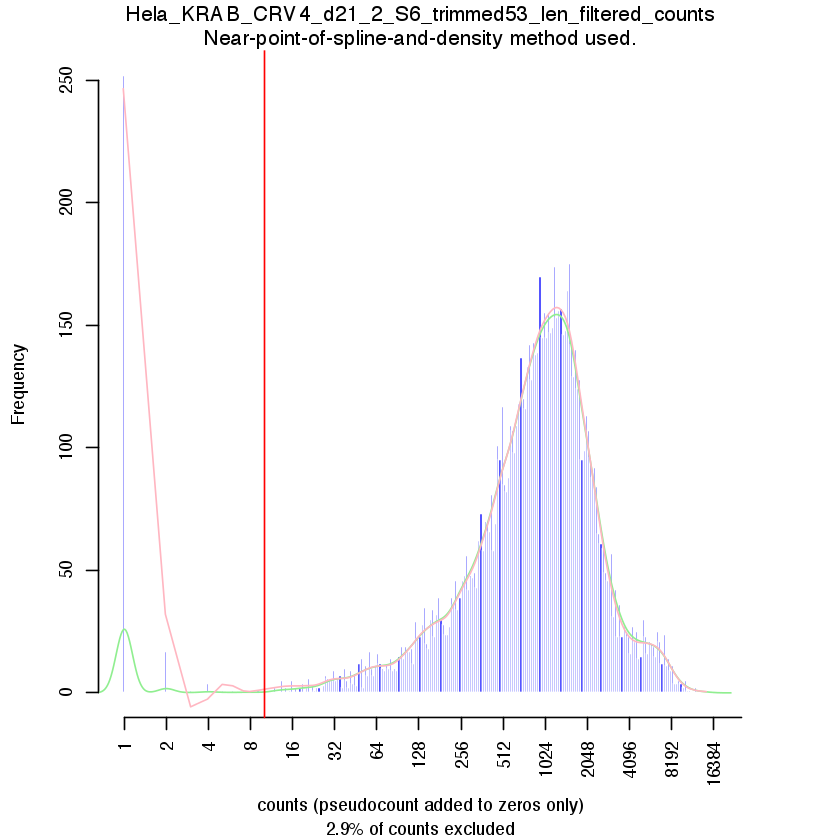

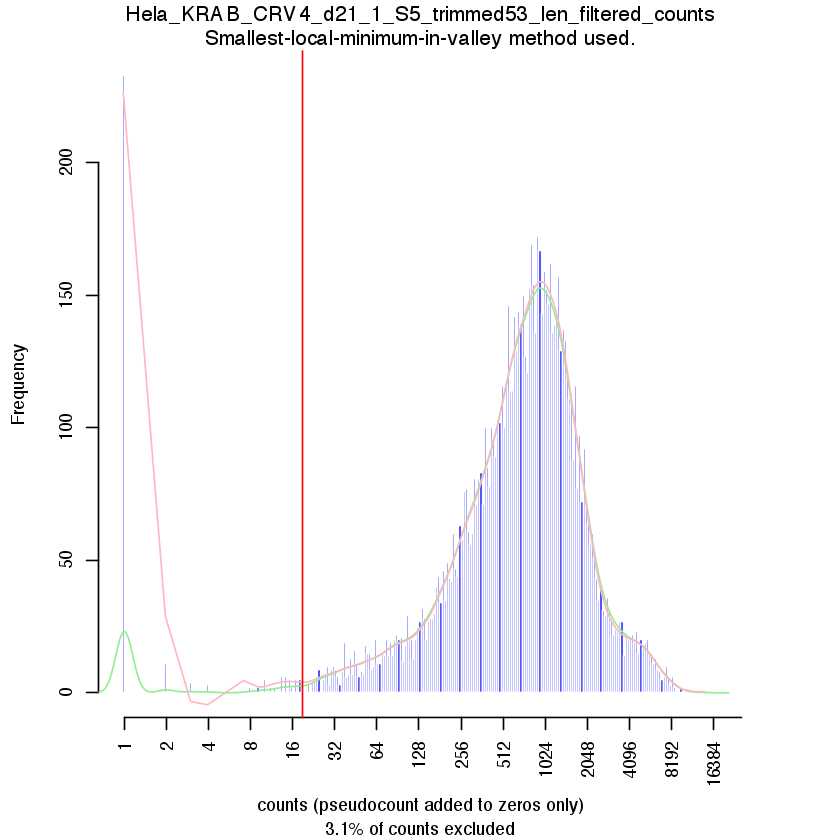

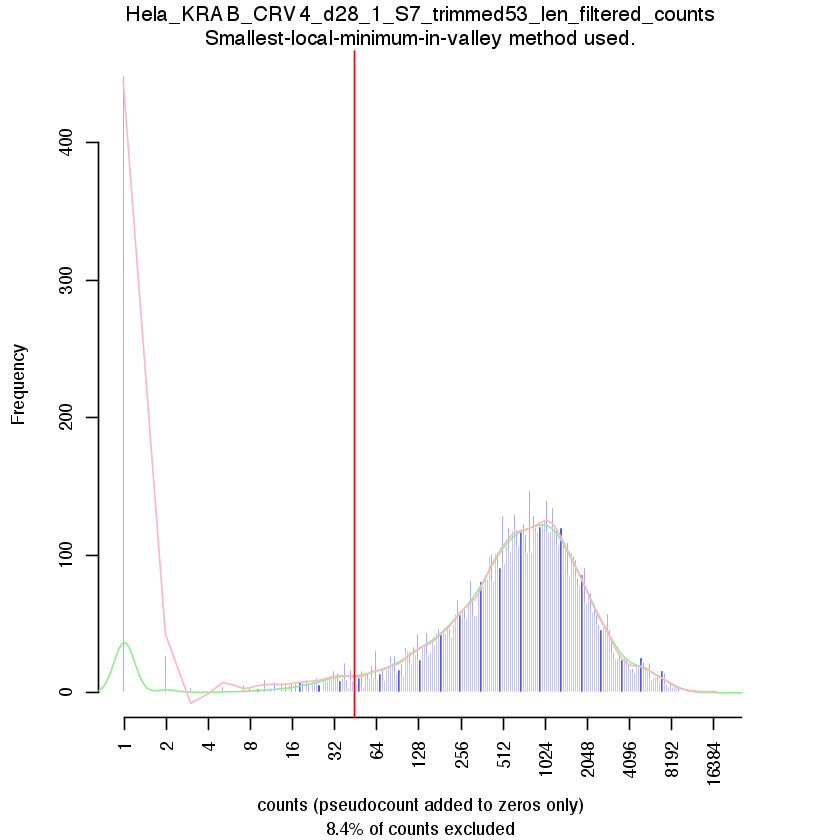

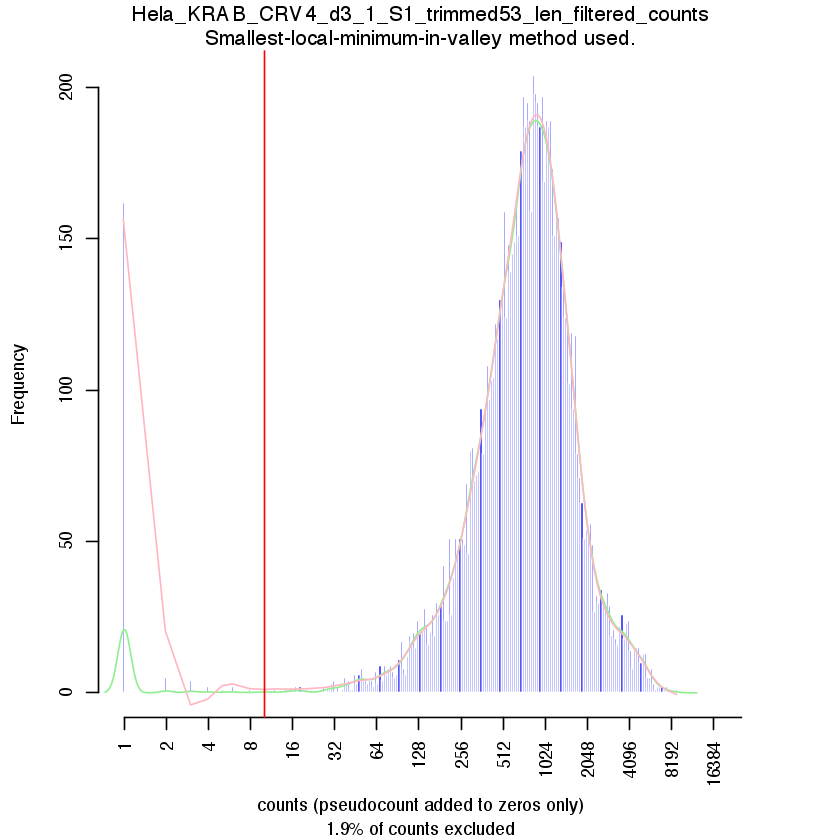

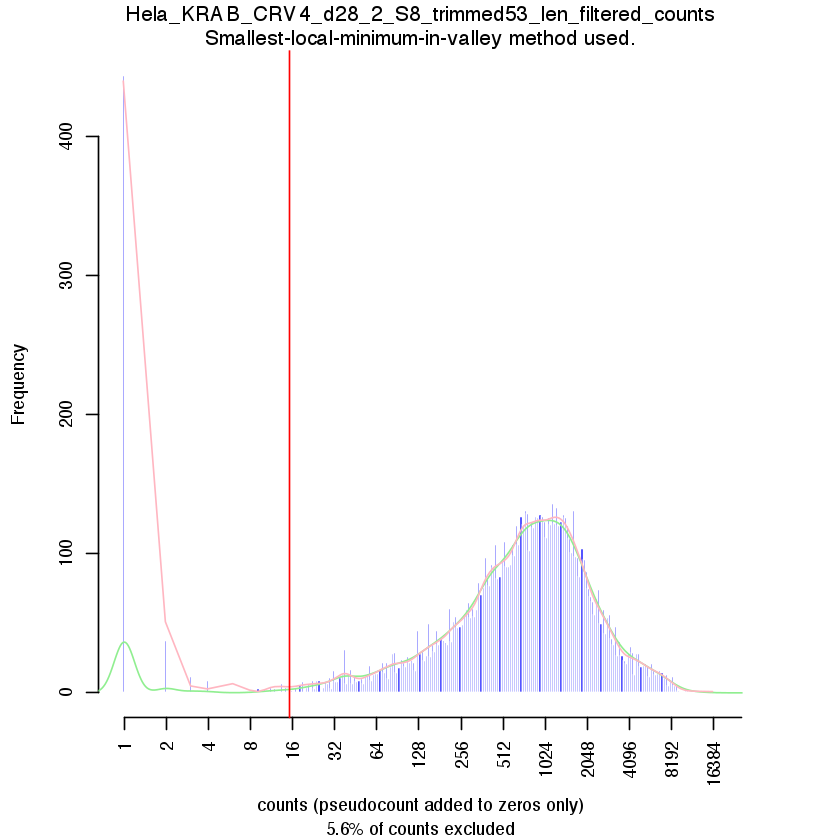

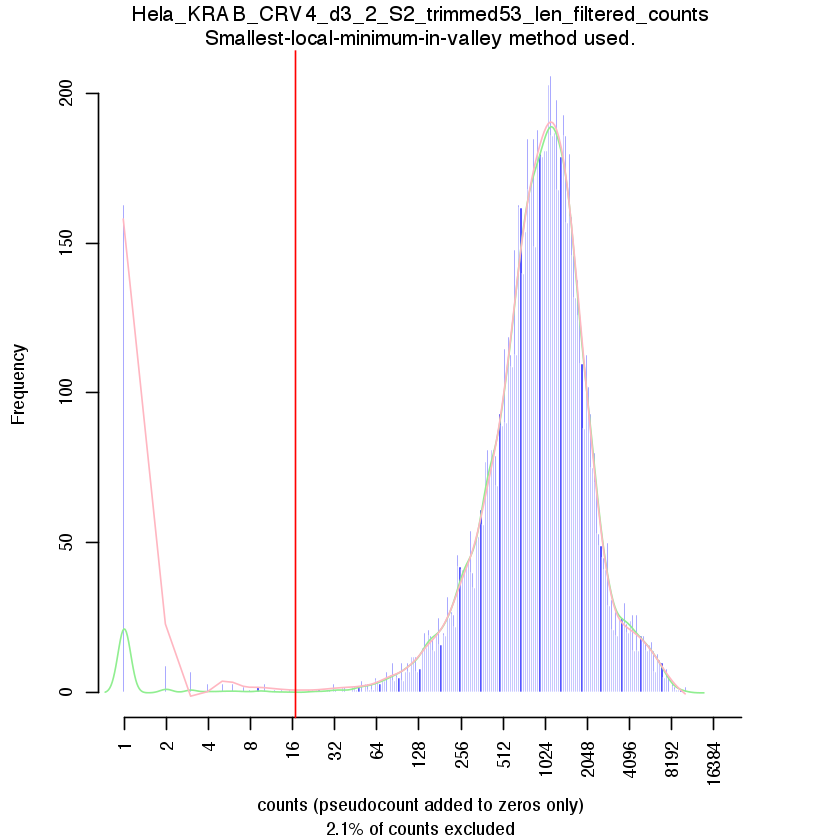

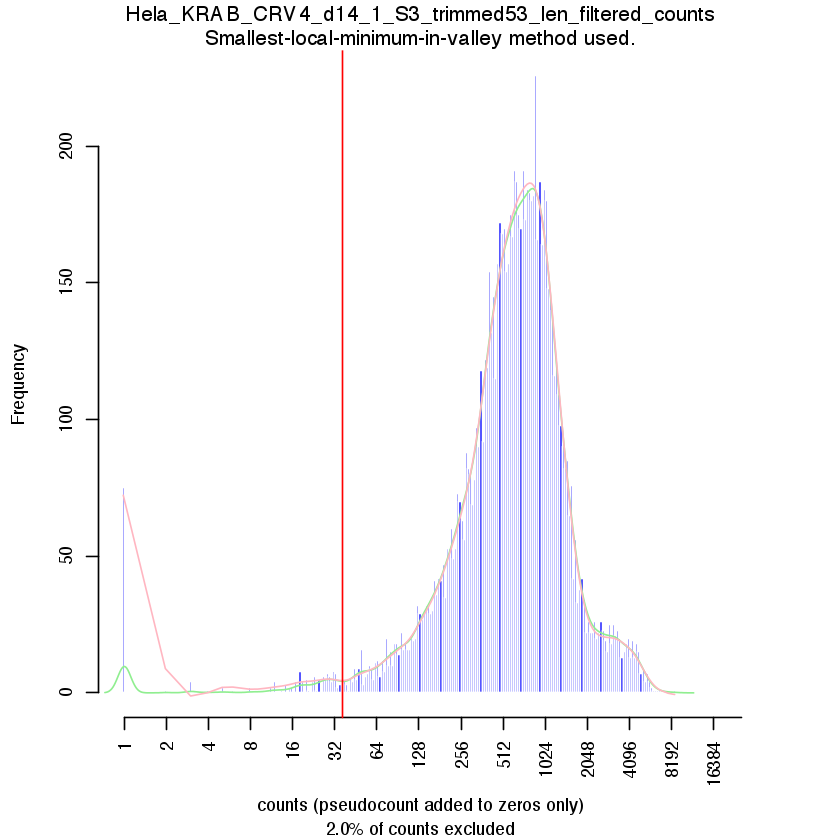

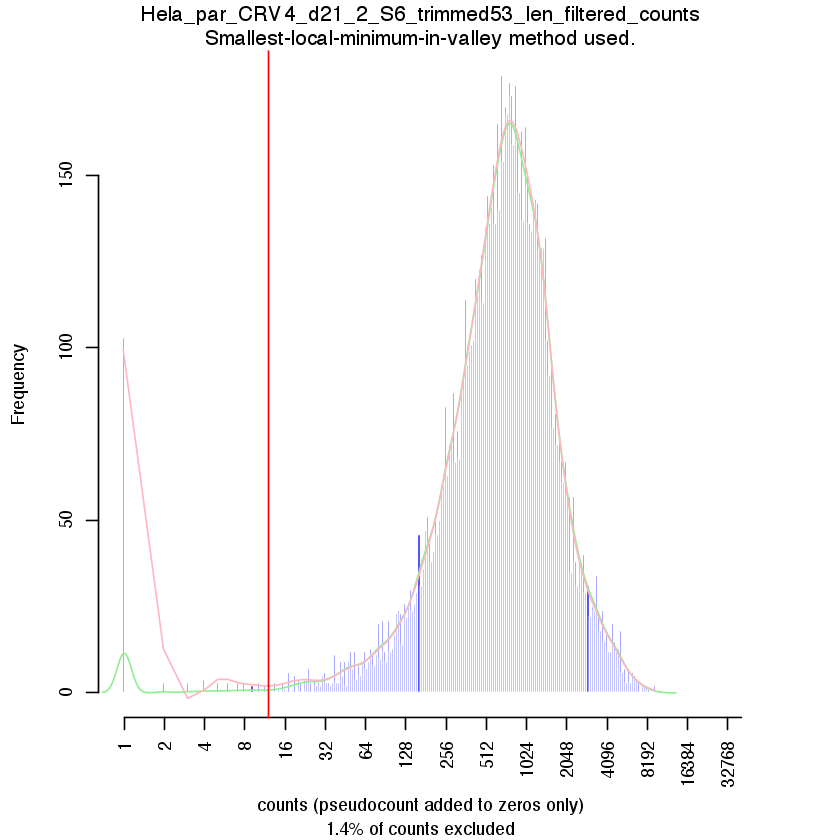

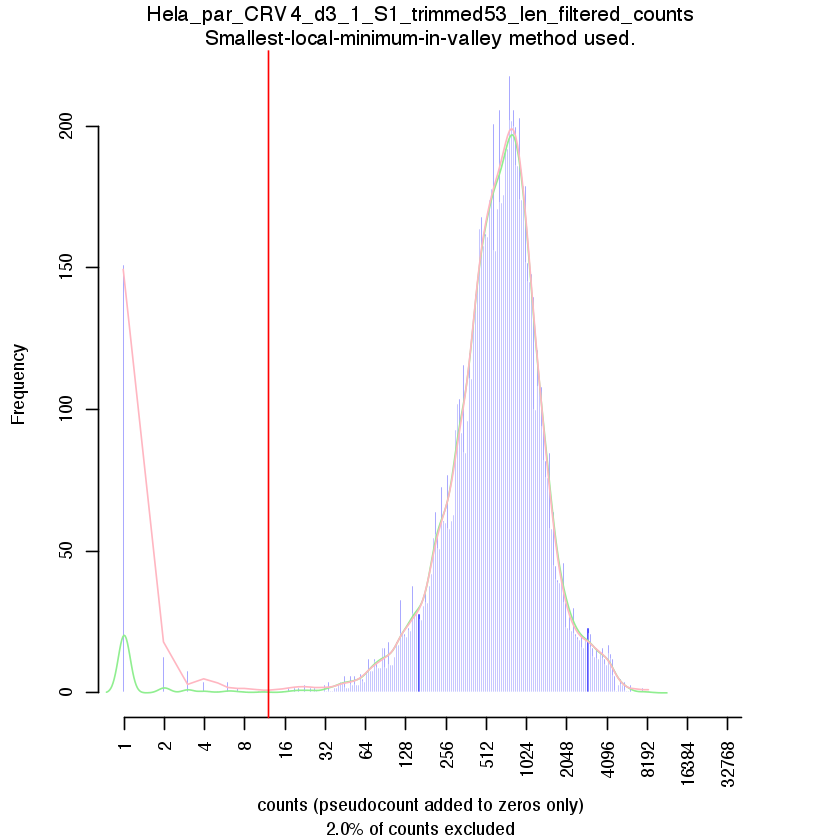

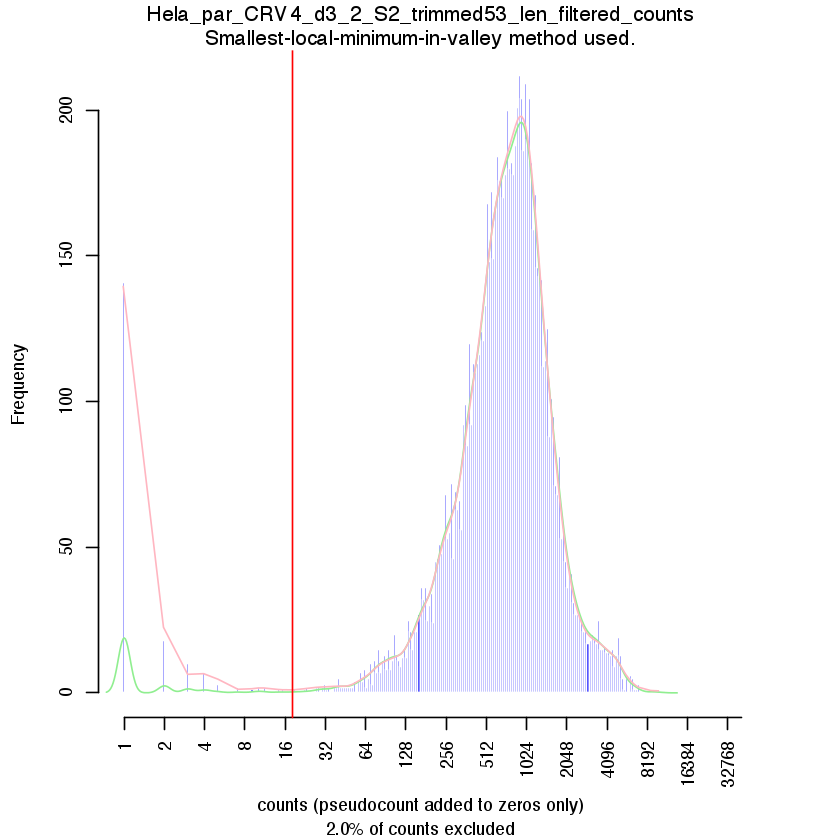

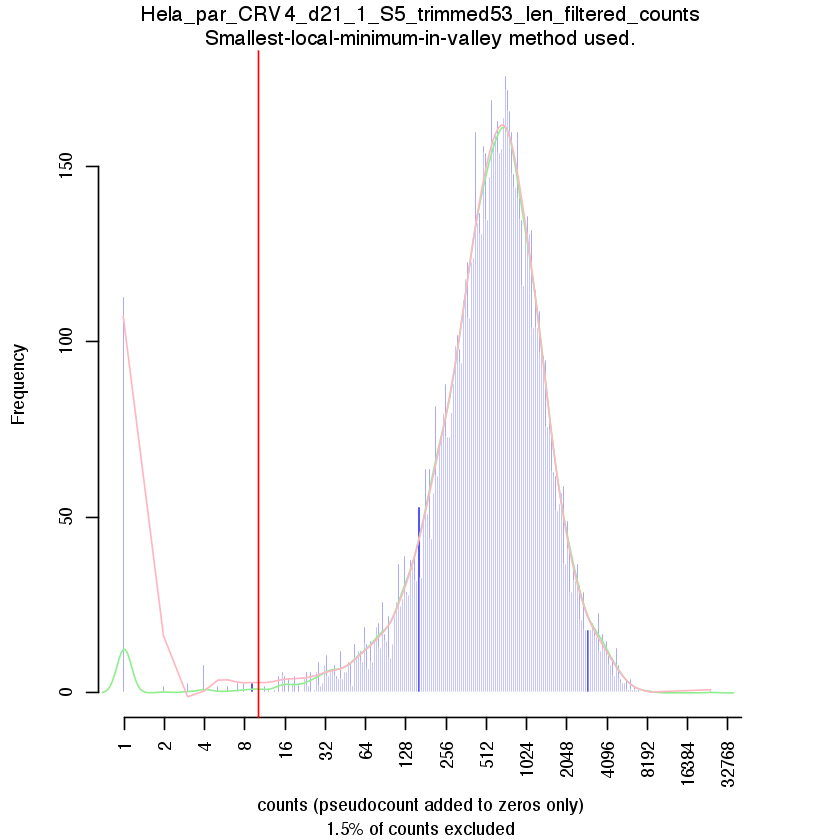

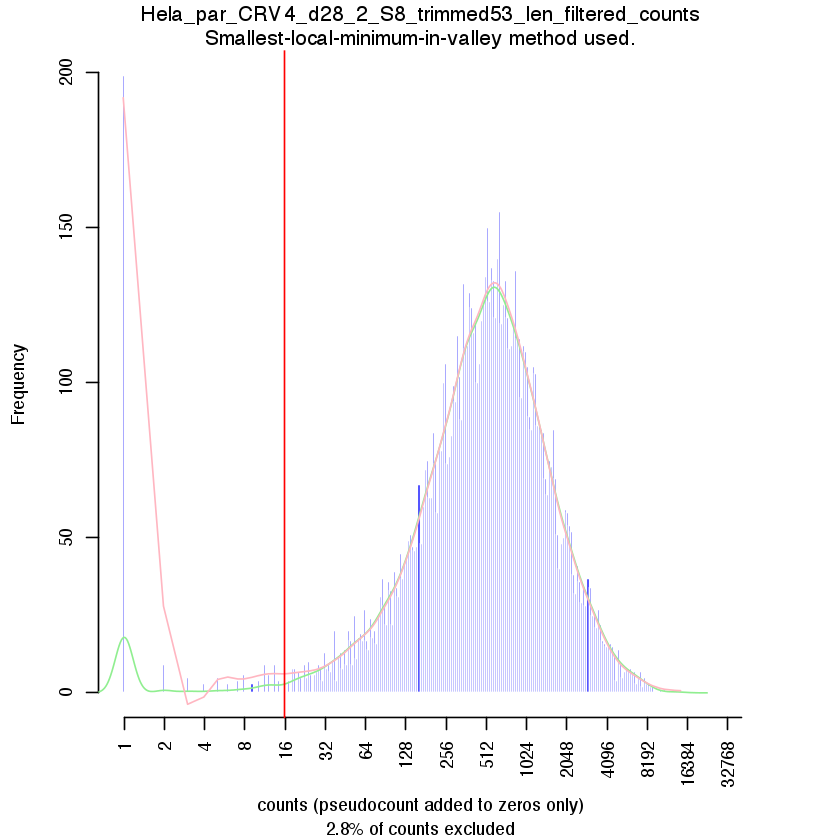

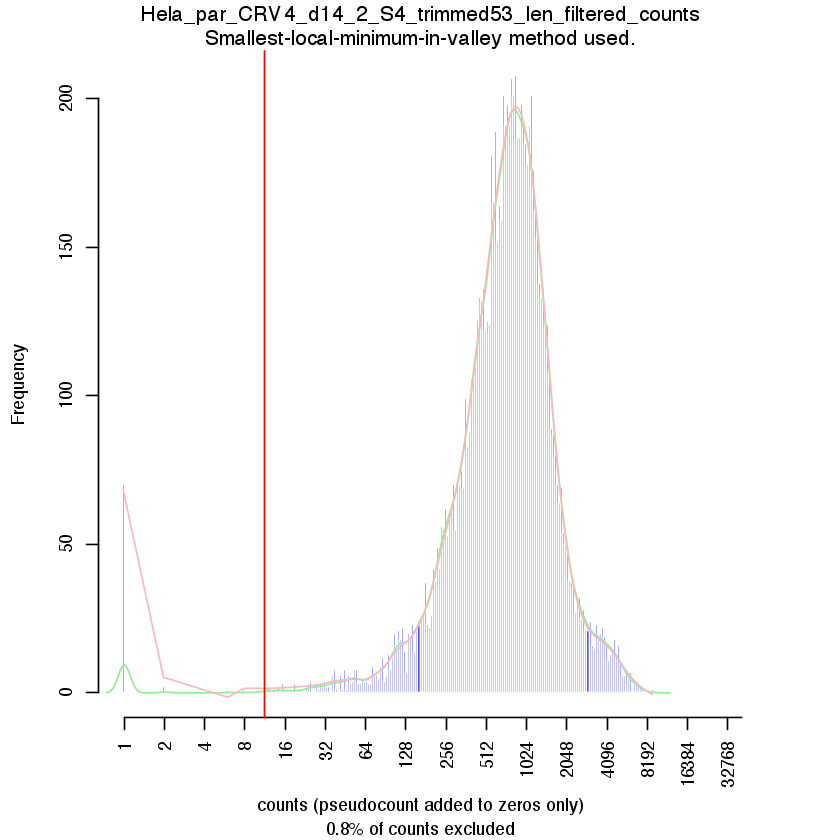

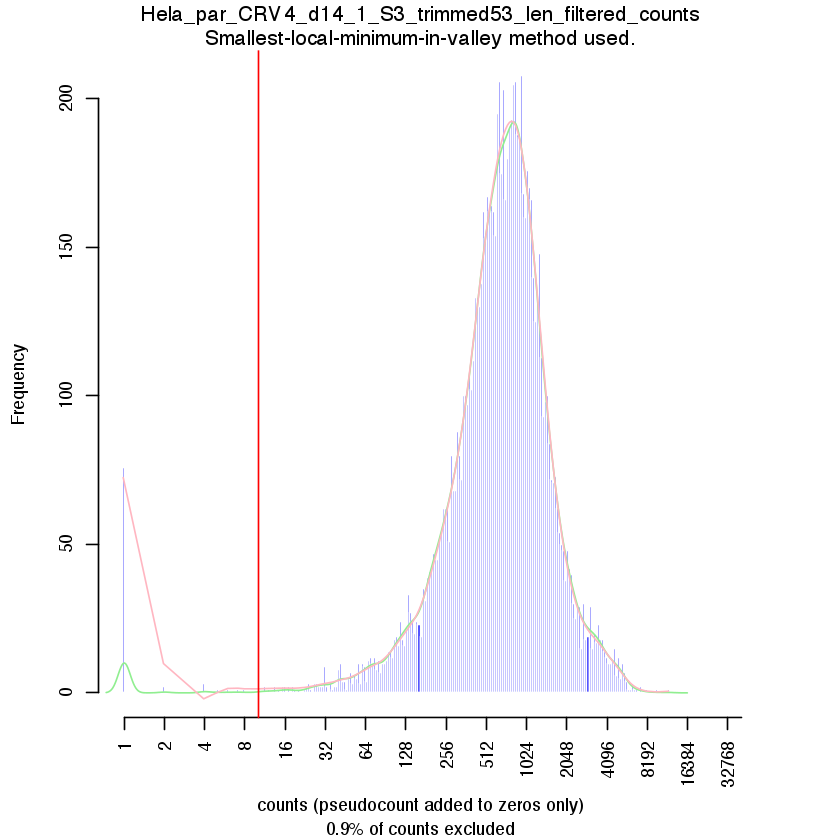

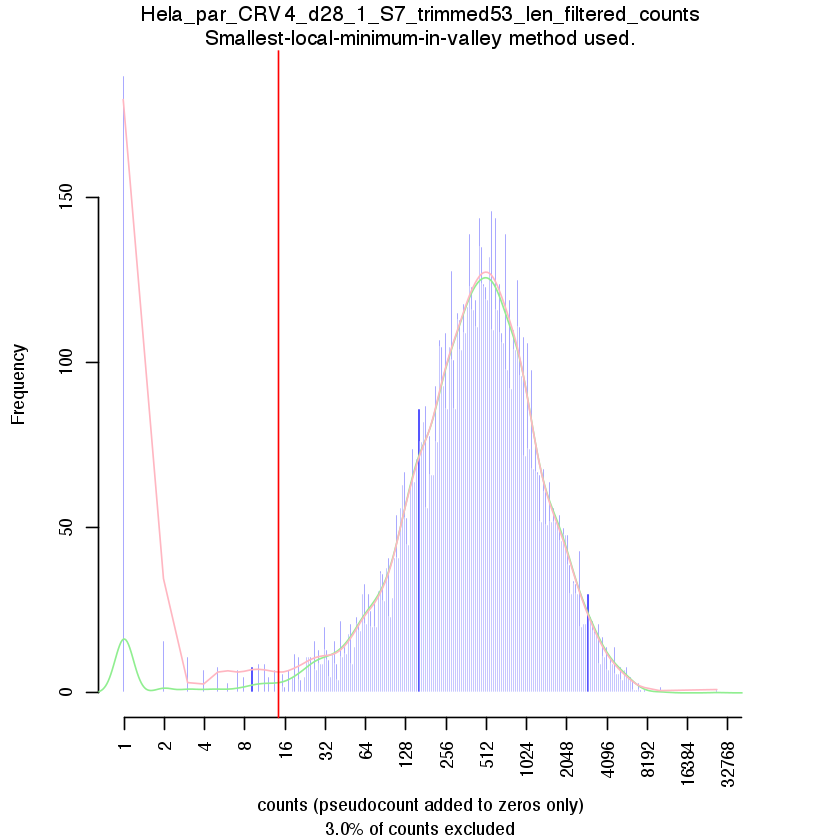

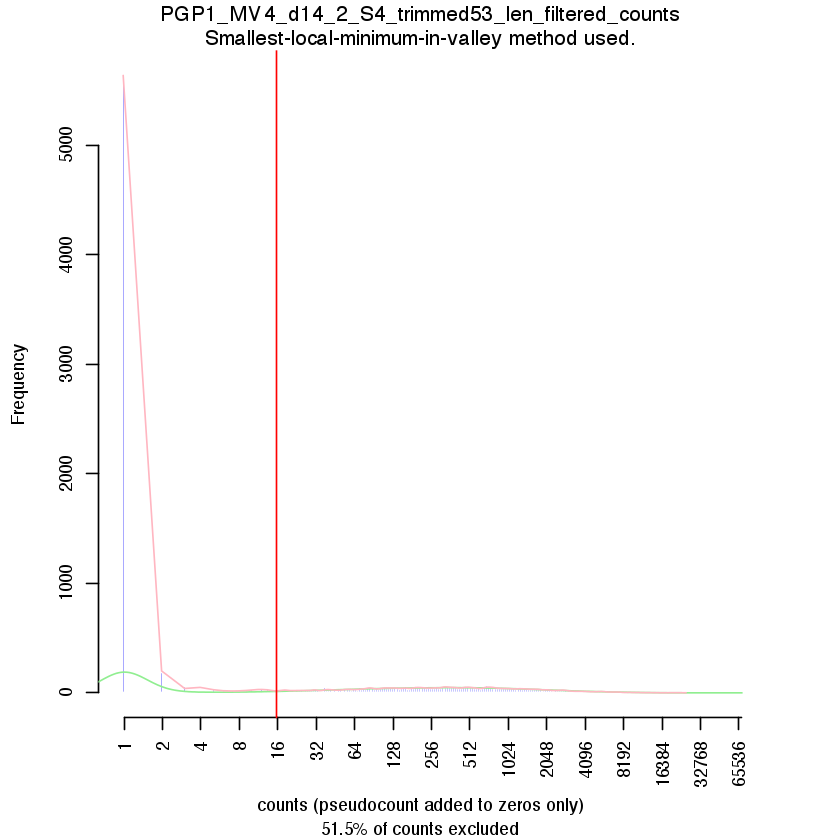

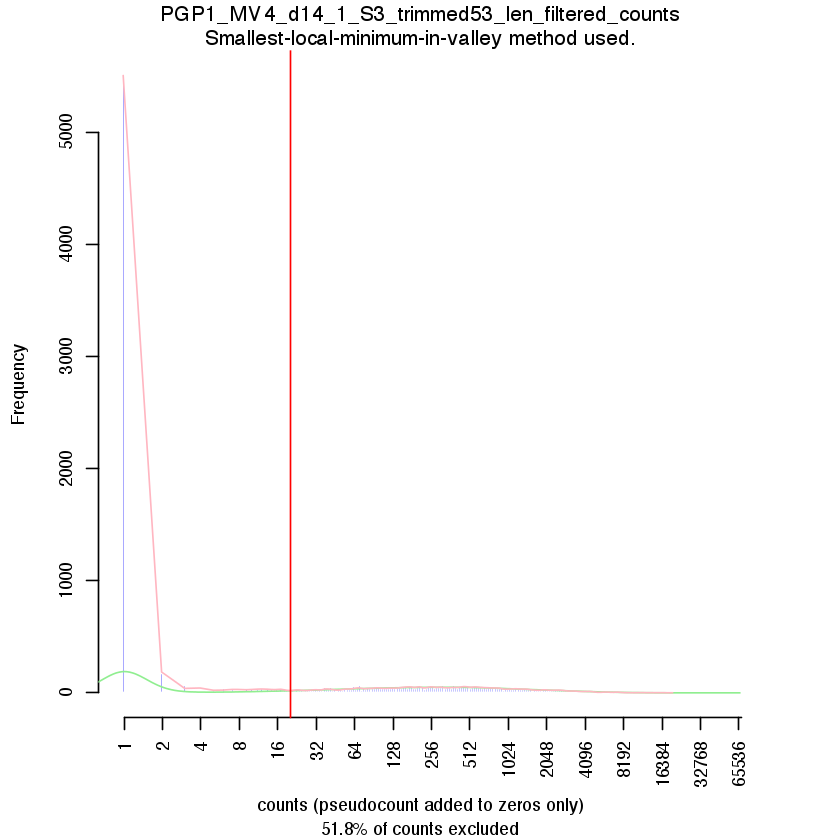

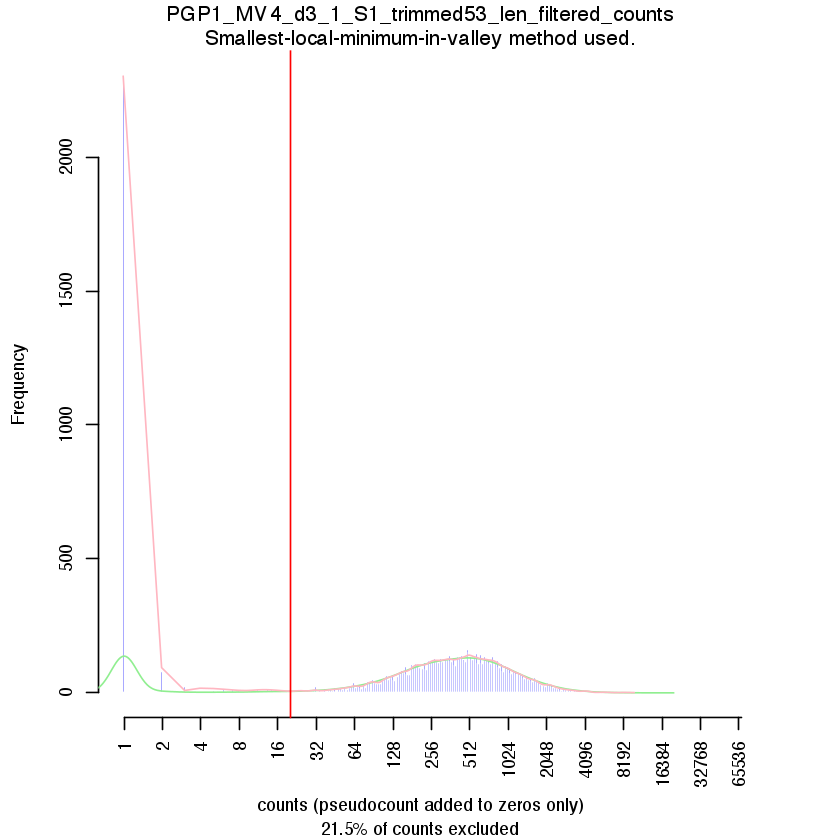

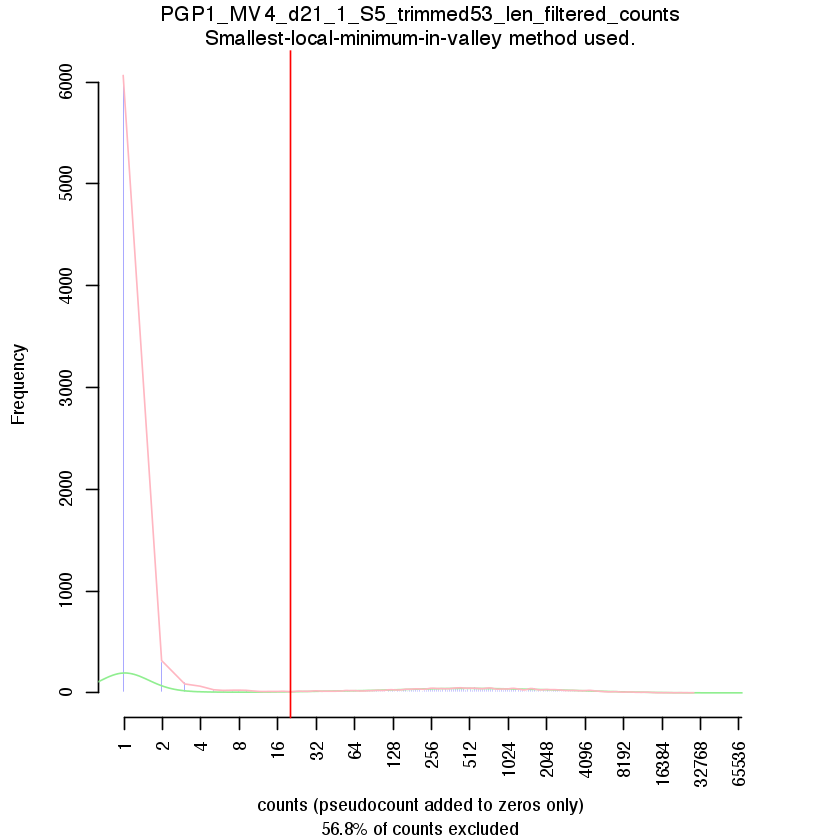

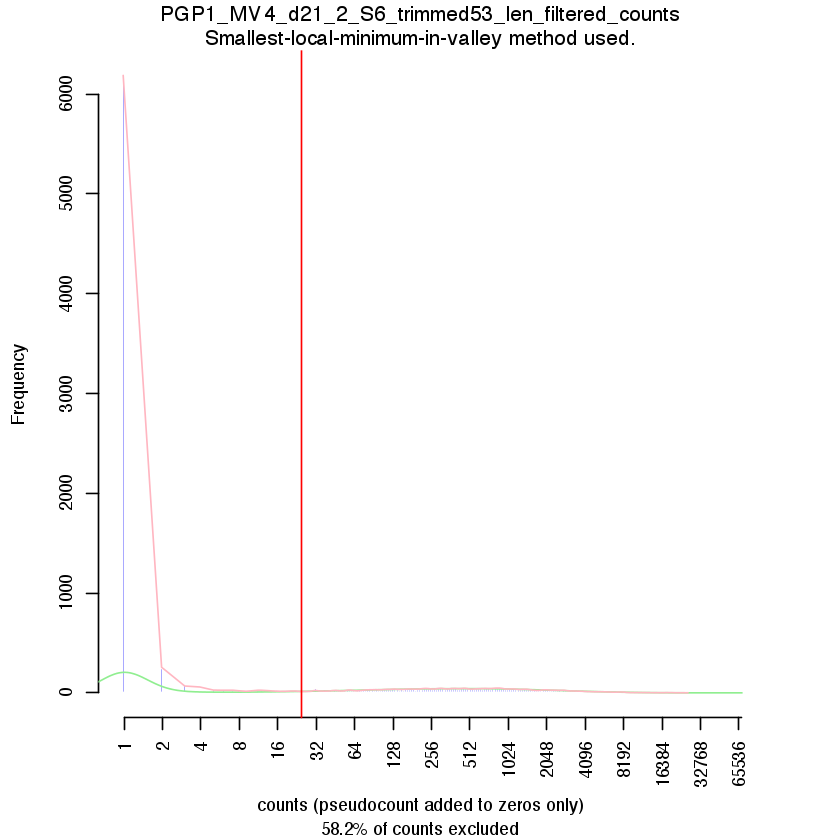

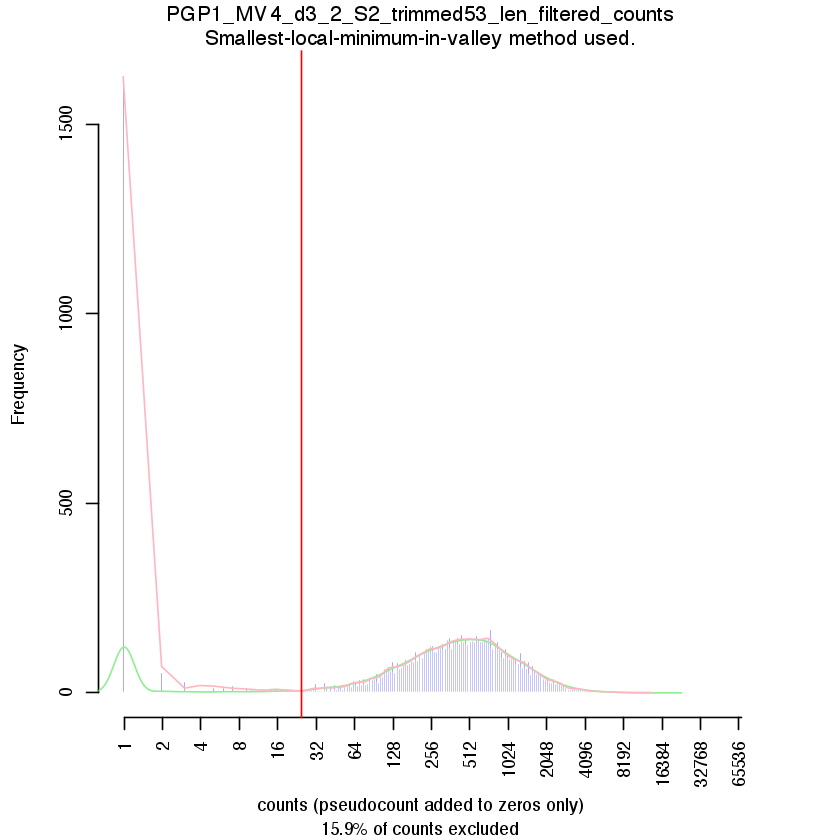

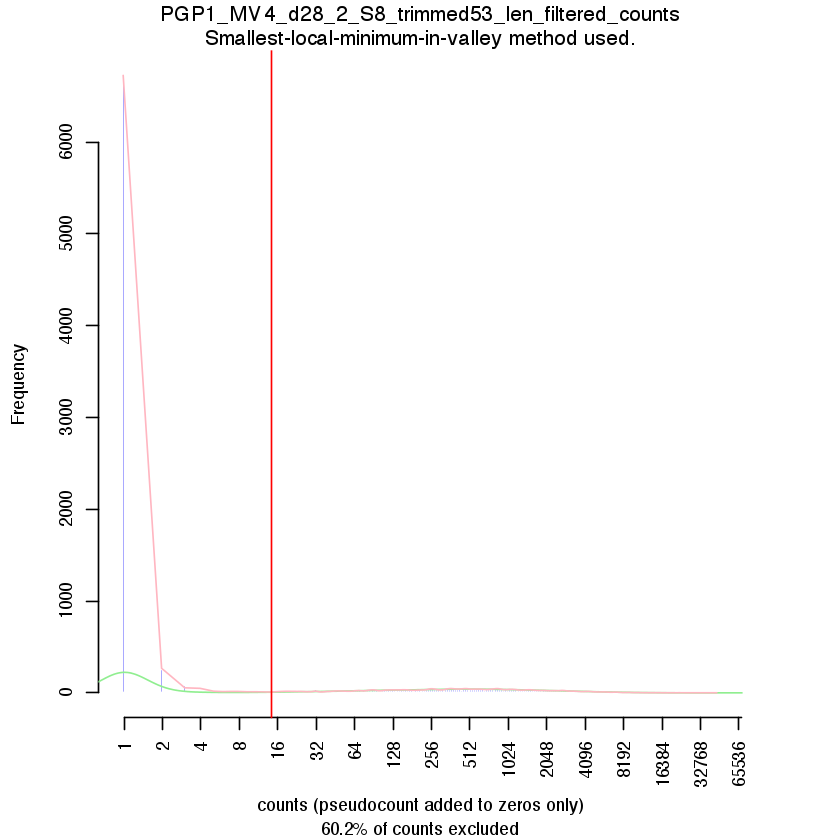

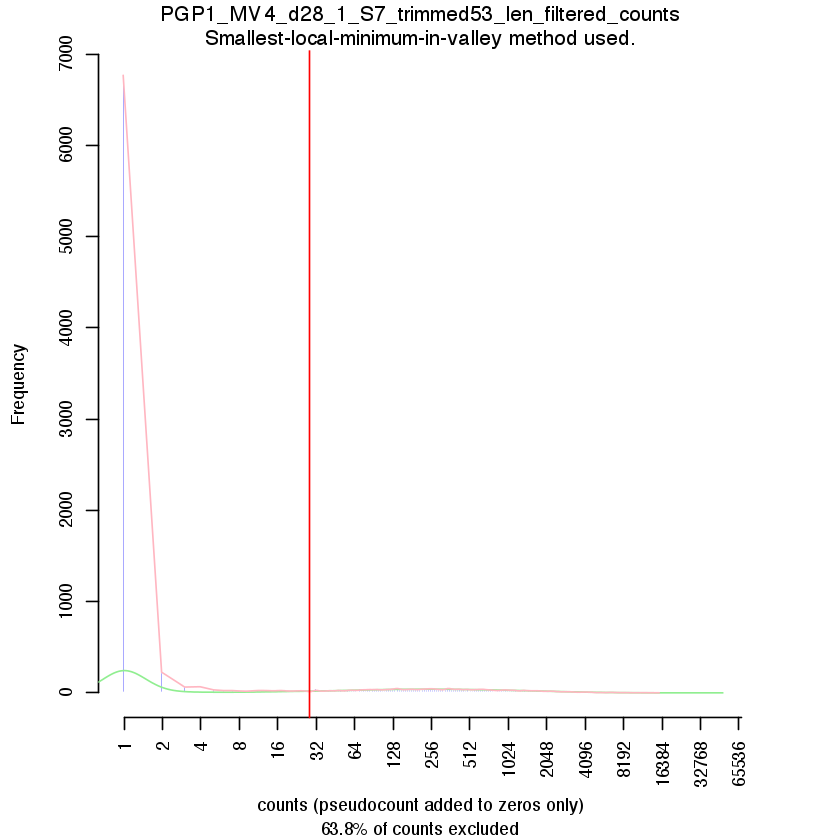

In [52]:
applyToAllCombinedCounts("~/Desktop/mali_combined_counts")

There's just one case (RuCTBt14_S7) where the heuristic makes a different pick than I would:

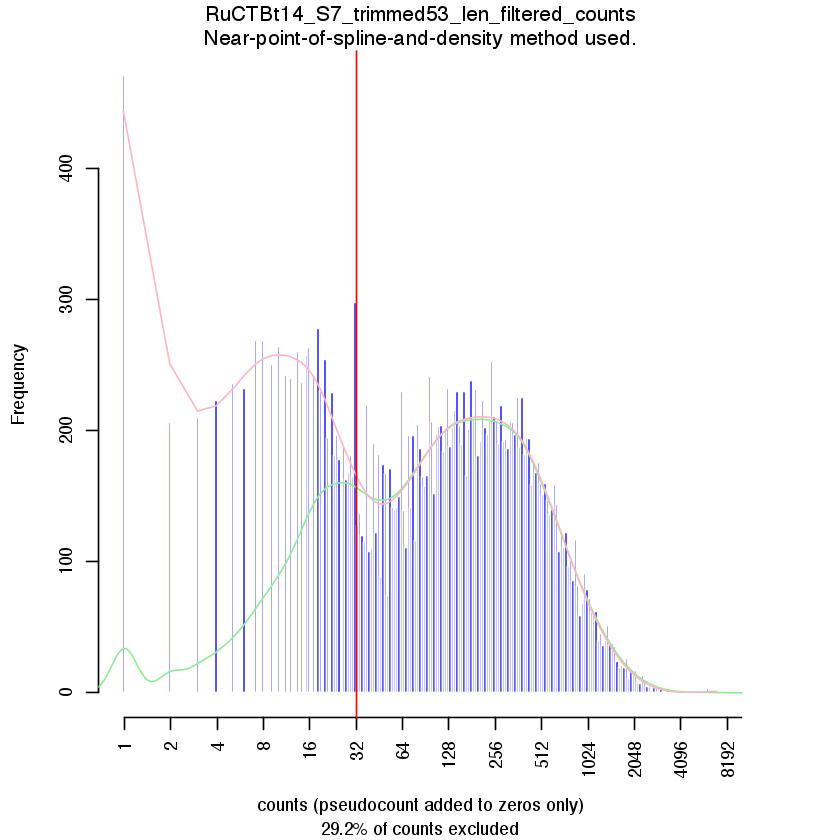</img>

In [53]:
displayInlineImages("mispick.png")

In this case, I would manually put the pick right in the "valley", but the heuristic doesn't because the local maximum to the left of tht valley is the highest and is greater than the global limit.  However, the "near point" threshold that is chosen instead by the heuristic is not a bad choice.  I think I can live with this imperfection.

[Table of Contents](#Table-of-Contents)

## Conclusion

I am content with the developed heuristic's ability to pick reasonable thresholds on test data it has never seen before, and believe it is ready to implement as part of the processing pipeline.  However, because future data *could* have distributional properties that violate the assumptions of the heuristic (or require adjustment of one or more of the three global limits), I think that plots like those above should be part of the output of the pipeline and should be examined by a human a sanity check *after the pipeline completes* (similar to the way we currently examine the count boxplots).  As long as they look good, the pipeline results can be used; if they look worrisome, then the pipeline results can be thrown out and rerun with adjusted parameters.

[Table of Contents](#Table-of-Contents)